In [2]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14
from IPython.display import display_html 
import pandas as pd


# Initialization

In [3]:
def initialize(spin, hl):

    CASE=1
    if CASE==0: dname="DATA"
    if CASE==1: dname="DATA_b"
        
    fname=dname+'/x_RBM_q0.1.dat'
    # loading data: each row is a list of visible units
    # NOTE: data "x" here is named "v" for "visible"
    v = np.loadtxt(fname, delimiter=" ",dtype=int)
    #v = v[0:500]
    # store in v0, because later we will shuffle v
    v0 = np.copy(v)
    # to start, take a small subsample
    # v = v[1:11]
    N = len(v)
    L = len(v[1])


    SPINS = spin
    #SPINS = False

    if SPINS:
        # sigmoid takes into account energy difference =2
        GAP=2
        # convert 0,1 -> -1,1
        v = 2*v - 1
        vmin=-1
        vv = [[1,-1,-1,-1], [-1,1,-1,-1], [-1,-1,1,-1], [-1,-1,-1,1]]
        v0 = 2*v0 -1
    else:
        GAP=1
        vmin=0
        vv = [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]


    print(f'each of N={N} data has L={L} digits')

    for i in range(min(12,N)):
        if SPINS: print(v0[i],"\n->",v[i])
        else: print(v[i])
    print('...')

    # RBM, nr of hidden units
    if CASE==0: M = 3
    if CASE==1: M = hl
    # range of each initial weight
    sigma = sqrt(4. / float(L + M))
    # random seed for reproducibility
    np.random.seed(12345)
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(L,M)
    a = sigma * np.random.randn(L)
    b = np.zeros(M)
    print("w=",w);print("a=",a);print("b=",b)
    w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)
    return w,a,b,w0,a0,b0,L,M,N,vv,GAP,vmin,v,v0,SPINS

## Plotting

In [4]:
L,M=20,2
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


# Energy and activation function 

In [5]:
def energy(h,a,b,wei): #return energy of the 4bit strings
    #print("IL VETTORE VV È PARI A",vv)
    #offset = np.array([0.25,0.25,0.25,0.25])
    #offset = np.zeros(4)
    #vv_off = vv - offset
    #E = [-np.dot(a,vv_off[i]) - np.dot(b,h) - np.dot(vv_off[i],np.matmul(wei,h)) for i in range(len(vv))]
    E = [-np.dot(a,vv[i]) - np.dot(b,h) - np.dot(vv[i],np.matmul(wei,h)) for i in range(len(vv))]
    return E

# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    

    return v_out

def activate_ohe(v_in,h,wei,a,b,DE, info=False, backward=False): #activate for one hot encoding
    if(backward==False):
        act = np.dot(v_in, wei) + b
        n = np.shape(act)
        prob = 1. / (1. + exp(-DE*act))
        v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's

        #print("n:",n)
        #print("vmin:",vmin)
        v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
        if info:
            print('input=', v_in)
            print('act=',act)
            print('prob=',prob)
            print('output=',v_out)

        return v_out #it's hidden variable
    else:
        v_out = []
        for j in range(5):
            a1 = [a[i:i + 4] for i in range(0, len(a), 4)]
            w1 = [w[i:i + 4,:] for i in range(0, len(a), 4)]
            E = np.array(energy(h,a1[j],b,w1[j]))
            #print("E", E)
            p = np.exp(-E)/np.sum(np.exp(-E))
            #print("p", p)
            v_out.append(vv[int(np.random.choice([0,1,2,3], 1, p=p))])
        return np.ravel(v_out)
        

#k = 0
#activate(v[k],w,b,GAP,info=True)

# Update Algorithm

In [6]:
def SGD(vh_data, vh_model, v_data, v_model, h_data, h_model,w,a,b,l_rate_m):
    dw = l_rate_m*(vh_data - vh_model)
    da = l_rate_m*(v_data - v_model)
    db = l_rate_m*(h_data - h_model)
    #if epoch<=1 and k<=mini:
    #    print('----------- epoch =',epoch,'  k=',k,'  m=',m)
    #    print('dw =',dw)
    #    print('da =',da)
    #    print('db =',db)
    # basic step of vanilla gradient descent, from eq.(211)
    w = w + dw
    a = a + da
    b = b + db
    return w,a,b

def ADAM(vh_data, vh_model, v_data, v_model, h_data, h_model,w,a,b, l_rate_m, t, mw, ma, mb, sw, sa, sb): #or RMS
        Beta1 = 0.9
        Beta2 = 0.99
        epsilon = 1.e-8
        #epsilon = 0.1
        
        dw = (vh_data - vh_model)
        da = (v_data - v_model)
        db = (h_data - h_model)

        mw = Beta1*mw + (1 - Beta1)*dw
        ma = Beta1*ma + (1 - Beta1)*da
        mb = Beta1*mb + (1 - Beta1)*db

        sw = Beta2*sw + (1 - Beta2)*(dw**2)
        sa = Beta2*sa + (1 - Beta2)*(da**2)
        sb = Beta2*sb + (1 - Beta2)*(db**2)

        mhat_w = (1 / (1 - np.power(Beta1,t)) ) * mw
        mhat_a = (1 / (1 - np.power(Beta1,t)) ) * ma
        mhat_b = (1 / (1 - np.power(Beta1,t)) ) * mb

        shat_w = (1 / (1 - np.power(Beta2,t)) ) * sw
        shat_a = (1 / (1 - np.power(Beta2,t)) ) * sa 
        shat_b = (1 / (1 - np.power(Beta2,t)) ) * sb

#        w = w - l_rate_m*mhat_w/ np.sqrt(np.sqrt(np.linalg.det(np.matmul(shat_w, shat_w.T))) + epsilon)
        w = w + l_rate_m*mhat_w/ (np.sqrt(shat_w) + epsilon)
        a = a + l_rate_m*mhat_a/ (np.sqrt(shat_a) + epsilon)
        b = b + l_rate_m*mhat_b/ (np.sqrt(shat_b) + epsilon)

        return w,a,b, mw, ma, mb, sw, sa, sb

In [7]:
def check_structure(v,vv):
    #print(v)
    def polar(w):
        w = list(w)
        if((w==vv[0]) or (w==vv[1])) :
            return True
        else:
            return False
    
    counts = 0
    #print("len v", len(v))
    for i in range(0,len(v)-4,4):
        if polar(v[i:i+4]):
            if polar(v[i+4:i+8]):
                counts += 1
        else:
            if polar(v[i+4:i+8])==False :
                counts += 1
                
    return counts
                

# Energy Plot

In [8]:
def Average_energy(v0,h,w,a,b):
    E = np.mean([(-np.dot(a,v0[k]) - np.dot(b,h[k]) - np.dot(v0[k],np.matmul(w,h[k])))for k in range(len(v0))])
    #Beta equal to 1
    #Z = 0
    #if GAP==2:
    #    h_values = [-1,1]
    #else: h_values = [0,1]
        
    #for H in h_values:
    #    Z += np.sum(energy(H,a,b,w))
    #Z = np.cumsum([np.exp(-(-np.dot(a,v0[k]) - np.dot(b,h) - np.dot(v0[k],np.matmul(w,h)))) for k in range(len(v0))])
    #logLike = np.log((1/Z[len(Z)-1])*np.exp(-E))
    return E
def En_plot(E_d,E_m):
    fig, (axE, axdiffE) = plt.subplots(2, 1 , figsize=(10, 5))
    axE.plot([i for i in range(len(E_d))], E_d, label = "Energy from Data")
    axE.plot([i for i in range(len(E_m))], E_m, label = "Energy from Model")
    axdiffE.plot([i for i in range(len(E_m))], np.array(E_d) - np.array(E_m), label = "Edata - Emodel")
    axE.set_xlabel("epochs")
    axE.set_ylabel("Energy")
    axE.legend(loc = 'best')
    axdiffE.set_xlabel("epochs")
    axdiffE.set_ylabel("\u0394 Energy")
    axdiffE.legend(loc = 'best')

def LL(Edata,a,b,wei):
    Z = 0
    for hh in [[vmin],[1]]:
        for i1 in range(4):
            for i2 in range(4):
                for i3 in range(4):
                    for i4 in range(4):
                        for i5 in range(4):
                            vvv = []
                            vvv.append(vv[i1])
                            vvv.append(vv[i2])
                            vvv.append(vv[i3])
                            vvv.append(vv[i4])
                            vvv.append(vv[i5])
                            vvv = np.ravel(vvv)
                            wei = np.array(wei)
                            Z += np.exp(-(-np.dot(a,vvv) - np.dot(b,hh) - np.dot(vvv,np.matmul(wei,hh))))

                        
    return (-Edata - np.log(Z))

In [94]:
LL(ESGD_data,a,b,w)


-5.1668112715445815

# Test noise reduction

In [9]:
def test_noise(amplitude,vv,v0,h,w,a,b,GAP,fname,SPIN):
    
    ampl=amplitude
    # original, non-reshuffled data in v0
    h=0
    v1 = np.zeros_like(v0)
    for k in range(N):
        # positive CD phase: generating h 
        h = activate_ohe(v0[k],h,w,a,b,ampl*GAP)
        # negative CD phase: generating fantasy vf with low T == large GAP
        v1[k] = activate_ohe(v0[k],h,w,a,b,ampl*GAP,backward=True)
    # difference between fantasy and data
    diff = (v1 - v0)/2
    str0 = fname+'_M'+str(M)+'-mini'+str(mini)
    np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
    np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  
    #print("number of errors in pol-nonpol of RBM genereted data",check_structure(v1,vv))

    def is_one(cell_value):
        color0 = 'background-color: gray; color: white'
        color1 = 'background-color: gold;'
        if type(cell_value) in [float, int]:
            if cell_value == 1:
                return color1
        return color0

    N1=12
    df0 = pd.DataFrame(v0[:N1])
    df1 = pd.DataFrame(((v1[:N1])).astype(int))

    df0s = df0.style.set_table_attributes("style='display:inline'")
    df1s = df1.style.set_table_attributes("style='display:inline'")
    df0s.applymap(is_one)
    df1s.applymap(is_one)
    sty = [dict(selector="caption",props=[("font-size", "150%")])]
    df0s.set_caption('Original').set_table_styles(sty)
    df1s.set_caption('Denoised').set_table_styles(sty)

    display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)
    
    
    #if SPIN==True:
    #    v0 = (v0 +1)/2
    c0 = 0
    c = 0
    for i in range(len(v)):
        c0 += check_structure(v0[i],vv)
        c += check_structure(v1[i],vv)
    print("number of errors in pol-nonpol of real data", c0)
    print("number of errors in pol-nonpol of RBM generated data", c)



In [11]:
def calculate_v1(v0, a, b, w, GAP):
    # original, non-reshuffled data in v0
    h=0
    h_m = []
    hf_m = []
    v_m = []
    v1 = np.zeros_like(v0)
    for k in range(N):
        # positive CD phase: generating h 
        h = activate_ohe(v0[k],h,w,a,b,GAP)
        # negative CD phase: generating fantasy vf with low T == large GAP
        v1[k] = activate_ohe(v0[k],h,w,a,b,GAP,backward=True)
        hf = activate_ohe(v0[k],h,w,a,b,GAP)
        h_m.append(h)
        hf_m.append(hf)


    # compute the second momentum between fantasy and data
    v1 = ((v1-vmin)/(1-vmin)).astype(int)

    return v1, h_m, hf_m


def moment_2(v0, v1):
    
    v1 = np.array(v1)
    
    Nv = len(v0[0])
    Ns = len(v0[:,0])

    Cij_mse = 0
    
    for j in range(1, Nv):
        for i in range(j):
            Cij_D = 0
            Cij_RBM = 0
            mi_D = np.mean(v0[:, i])
            mj_D = np.mean(v0[:, j])
            mi_RBM = np.mean(v1[:, i])
            mj_RBM = np.mean(v1[:, j])
            for n in range(len(v0[:, 0])):
                Cij_D += (v0[n][i] - mi_D)*(v0[n][j] - mj_D)*(1/Ns)
                Cij_RBM += (v1[n][i] - mi_RBM)*(v1[n][j] - mj_RBM)*(1/Ns)
            Cij_mse += (Cij_D - Cij_RBM)**2
    moment_2 = 2*Cij_mse/(Nv*(Nv-1))
    return moment_2




# {0,1} SGD 1 hidden Layer, mini = 100

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...
w= [[-0.08934175]
 [ 0.20902801]
 [-0.22670164]
 [-0.24254059]
 [ 0.85793698]
 [ 0.60813216]
 [ 0.04054832]
 [ 0.1229641 ]
 [ 0.33562896]
 [ 0.54398872]
 [ 0.43957347]
 [-0.56571727]
 [ 0.12001619]
 [ 0.09990577]
 [ 0.59046131]
 [ 0.38686948]
 [-0.87358614]
 [-0.16228539]
 [ 0.72842236]
 [-0.19140752]]
a= [-2.35562479e-01  2.08173325e-01  1.41795538e+00 -4.45700232e-01
 -2.51861548e-01  5.41709658e-02  1.32071386e-01  2.28592871e-01
  4.10370865e-04  

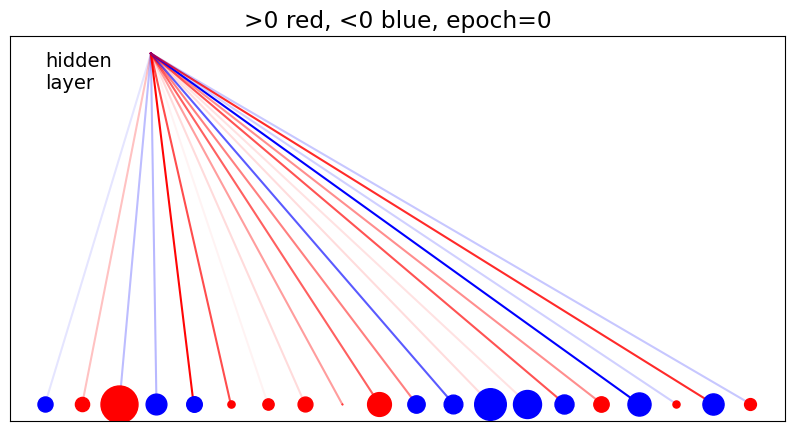

epoca: 0
epoca: 1
epoca: 2
epoca: 3
epoca: 4
epoca: 5
epoca: 6
epoca: 7
epoca: 8
epoca: 9


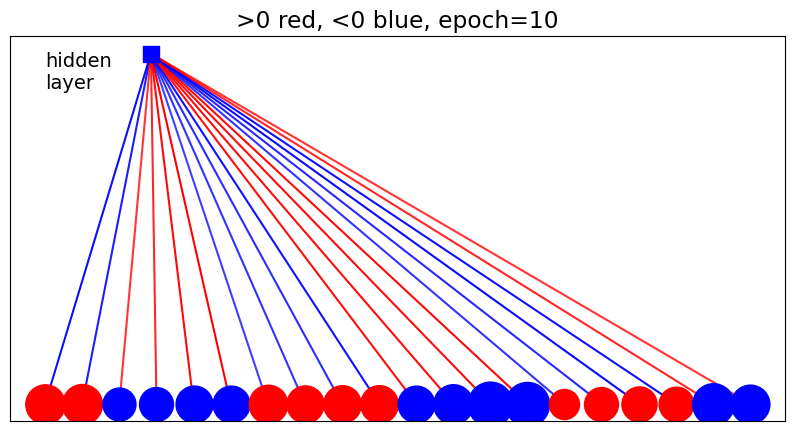

l_rate =  0.9090909090909092
epoca: 10
epoca: 11
epoca: 12
epoca: 13
epoca: 14
epoca: 15
epoca: 16
epoca: 17
epoca: 18
epoca: 19


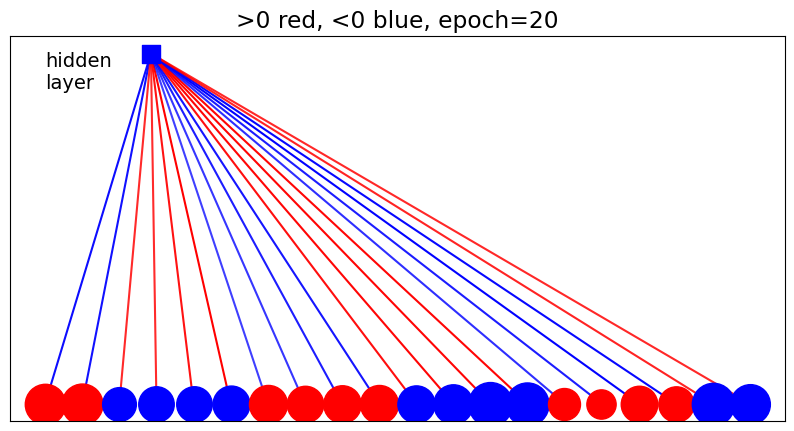

l_rate =  0.8333333333333337
epoca: 20
epoca: 21
epoca: 22
epoca: 23
epoca: 24
epoca: 25
epoca: 26
epoca: 27
epoca: 28
epoca: 29


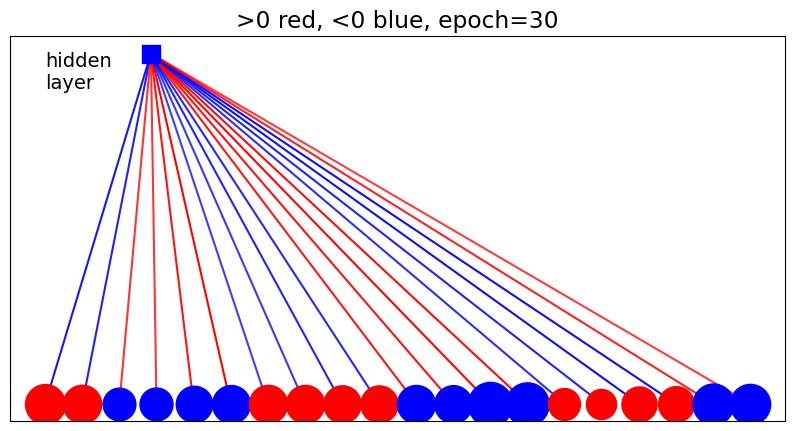

l_rate =  0.7692307692307697


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


number of errors in pol-nonpol of real data 3783
number of errors in pol-nonpol of RBM generated data 3690


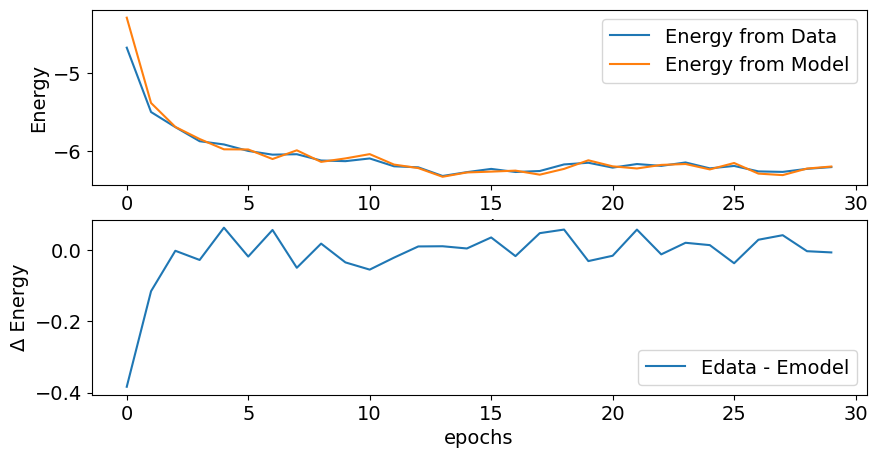

In [108]:
w,a,b,w0,a0,b0,L,M,N,vv,GAP,vmin,v,v0,SPINS = initialize(spin=False, hl=1)

# random seed for reproducibility
np.random.seed(12345)

plotgraph(0)

h=0

#additional iterations for contrastive divergence
iterations = 0

# learning rate
l_rate = 1.0
ESGD_data, ESGD_model, diffESGD_100 = [], [], []
LogLSGD_data, LogLSGD_model = [], []
# minibatch
mini, m = 100, 0

# third_momentum ini 
momentum2_SGD_100 = np.zeros(50)

# train model
print('===================================================')
for epoch in range(30):
    # aggregate normalization of batch statistics and learning ratenp.zeros(50)
    l_rate_m = l_rate 
    h_m, hf_m, v1_m = [], [], []
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

        # positive CD phase: generating h 
        h = activate_ohe(v[k],h,w,a,b,GAP)
        #if(k==1): print("i valori di h sono",h)
        #h_m.append(h)
        # negative CD phase: generating fantasy vf
        vf = activate_ohe(v[k],h,w,a,b,GAP,backward=True)
        
        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = activate_ohe(vf,h,w,a,b,GAP)
        
        for j in range(iterations):
            vf = activate_ohe(vf,hf,w,a,b,GAP,backward=True)
            hf = activate_ohe(vf,hf,w,a,b,GAP)

        v1_m.append(vf)
        hf_m.append(hf)
        #RICORDARSE        
        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        vh_data += np.outer(v[k].T,h) 
        vh_model+= np.outer(vf.T,hf) 
    
        m += 1
        #print("k", k)
        # minibatch
        if m==mini:
            #dividing by minibatch size to get averages
            v_data = v_data/mini
            v_model = v_model/mini

            h_data  = h_data/mini
            h_model = h_model/mini
            
            vh_data = vh_data/mini
            vh_model = vh_model/mini
            
            w, a, b= SGD(vh_data, vh_model, v_data, v_model, h_data, h_model,w,a,b, l_rate_m)
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            m=0
    #momentum3_SGD_spins[epoch] = moment_3(v0, a, b, w, GAP)
    v1_m, h_m, hf_m = calculate_v1(v0,a,b,w,GAP)
    #print(v1)
    #momentum2_SGD_100[epoch] = moment_2(v0, v1_m)
    ESGD_d = Average_energy(v0,h_m, w, a, b)
    LogLSGD_d = LL(ESGD_d,a,b,w)
    LogLSGD_data.append(LogLSGD_d)
    
    ESGD_m = Average_energy(v1_m,hf_m, w, a, b)
    LogLSGD_m = LL(ESGD_m,a,b,w)
    LogLSGD_model.append(LogLSGD_m)    
    #print("Data: ",E_data, "\n")
    #print("Model: ",E_model, "\n")
    ESGD_data.append(ESGD_d)
    ESGD_model.append(ESGD_m)
    
    print("epoca:", epoch)
    
    #momentum2_SGD_100[epoch] = moment_2(v0, a, b, w, GAP, v1_m)
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)#print('w0=',w0);print('a0=',a0);print('b0=',b0)
En_plot(ESGD_data, ESGD_model)
#print('w=',w);print('a=',a);print('b=',b)

test_noise(40,vv,v0,h,w,a,b,GAP, fname='DATA_b'+'/x_RBM_q0.1.dat',SPIN=SPINS)
np.savetxt('DATA_b/E_d_SGD_'+str(mini)+'.dat',ESGD_data,fmt="%f")
np.savetxt('DATA_b/E_m_SGD_'+str(mini)+'.dat',ESGD_model,fmt="%f")
np.savetxt('DATA_b/LogL_d_SGD_'+str(mini)+'.dat',LogLSGD_data,fmt="%f")
np.savetxt('DATA_b/LogL_m_SGD_'+str(mini)+'.dat',LogLSGD_model,fmt="%f")

#plt.plot(range(len(modata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAxoAAAGvCAYAAADc2KO9AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOyddZhU9RvFz52Z7aZ76e4G6e5SOgSUlkYUkBBEQgkBkQ6RVERaGn6iSFigAgKCinTHEhvf3x+Hu3dj4s7sIvV+noeH3Zl779y5M+j33HPe99WUUgqCIAiCIAiCIAjJiOVJn4AgCIIgCIIgCM8fIjQEQRAEQRAEQUh2RGgIgiAIgiAIgpDsiNAQBEEQBEEQBCHZEaEhCIIgCIIgCEKyI0JDEARBEARBEIRkR4SGIAiCIAiCIAjJjggNQRAEQRAEQRCSHREagiAIgiAIgiAkOyI0BEF4Ljlz5gw0TYOmaU/6VP5zkvLeX+Tr9qwxatQoaJqGjh07PulTEQRBsIsIDUEQAADR0dGYMWMGSpUqheDgYAQHB6NUqVL4+OOPERMT86RP77nm/v37GDt2LAoVKoSAgACEhYWhUqVKWLZs2ZM+NUHwmEOHDsFms5kWrkuXLkWlSpUQFhaGgIAAFCpUCGPHjsX9+/f/g7MVBOFxYHvSJyAIwpPn4cOHaNCgAbZt2wYAyJMnD7y9vfHDDz/g0KFDWL9+PdavXw8vL68nfKbPHzdu3ECVKlXwyy+/wGKxoECBAnj48CG++eYbfPPNN9ixYwfmz5//pE9TENwiMjISnTt3RnR0tMttlVLo1KkTFi9eDADImjUrQkND8dtvv+Gdd97B6tWrsXv3bgQHBz/u0xYEIZkRR0MQBAwfPhzbtm1DaGgo9uzZg2PHjuHw4cM4fPgwMmfOjC1btmDUqFFP+jSfS7p164ZffvkFWbJkwS+//ILDhw/j2LFj2LNnD0JCQrBgwQLMnTv3SZ+mILjFe++9hyNHjqBZs2Yut501axYWL14Mb29vfPHFFzh9+jR++uknnDp1CoULF8ZPP/2EHj16/AdnLQhCciNCQxCeQX788UecOXMmWY515coVTJs2DQAwceJEVKpUKfa5ggULYt68eQCAKVOm4Nq1a8nymi8akZGRWL9+faLHf/31V6xatQoAMG/ePBQsWDD2uUqVKmHixIkAmMU3c2dYEJ4GDh8+jHHjxqFs2bLo1auX022joqIwevRoAMCgQYPw8ssvxz6XOXNmrFy5EhaLBcuXL8fvv//+WM9bEITkR4SGIDyDrFu3DtmzZ0fFihUxe/ZsXL9+PUnHun//PgICAtC+fftEz9eqVQvZs2fHvXv3sG7dOreOrWezz5w5g++++w5NmzZF2rRpYbFYMHXq1HjbbtiwAY0aNUK6dOng7e2NNGnSoFGjRti1a5fD4yulMHfuXJQoUQL+/v5ImTIl6tati//9739unefjYt++fejVqxfSp0+PRo0aJXpeFxk5cuRAzZo1Ez3foUMH+Pv749y5c/jmm288Po9169ahSpUqCAsLQ2BgIMqWLYulS5e6fZysWbNC0zTs3r3b7vO7d++GpmnImjWrw2N48jknlb1796JVq1bIlCkTfHx8kCJFCtSsWROrV6+2u/2iRYugaRqqVKmC6OhoTJ48GYULF0ZAQABSpEiBhg0b4sCBA05f8+uvv0ajRo2QNm1aeHt7I126dGjatKnL93n9+nWMHj0apUqVQmhoKPz8/JAjRw68/PLL+Pzzzx3uFx0djSlTpqBw4cLw8/NDWFgYGjRogB9++MH1BUpGoqOj0blzZwDA3LlzYbE4X2b873//w4ULFwAA3bt3T/R83rx5UblyZSilYv+9CILwDKEEQXjmWLVqlUqdOrUCoAAob29v1aRJE7V69Wp1//59t4712muvKQCqatWqDrfp2LGjAqC6dOni1rH185swYYKyWq0qKChIlSxZUuXIkUNNnTpVKaVUZGSkateuXey2KVOmVMWKFVMpU6aMfWzcuHF2j9+hQ4fYbTJlyqRKliypgoKClNVqVZMmTYp97r/kxIkTauTIkSpHjhyxr69pmqpYsWKibatXr64AqE6dOjk8XpUqVRQANXbsWNPncPr06djX/uijjxQAlSJFClWyZEmVNm3a2Od69+7tdN+EhIeHKwBq165ddl93165dCoAKDw9P9FxSPuek8NZbb8UePyQkRBUtWlSlS5cu9rHu3bsn2mfhwoUKgKpcubJq1qyZAqCyZMmiSpYsqQIDAxUAZbVa1apVq+y+Zr9+/WKPnyZNGlWqVCmVKlWq2MdGjhxpd7/9+/fHO7dcuXKpEiVKxP5bDwkJibf9yJEjFQDVtm1bVatWLQVA5cyZUxUpUkT5+PgoAMrPz08dOHAgqZfRNO+//74CoN555x2llPGdcPTvcMyYMQqAypYtm8Njjho1SgFQNWvWfCznLAjC40OEhiA8o0RGRqpNmzaptm3bxi5+AKjQ0FDVpUsXtWfPHhUTE+PyOBUrVnQpIvTFQKVKldw6R/2crFareuutt+KJoIiICKWUUoMHD1YAVPbs2dW2bdvi7b906VIVEBCgNE1TO3fujPfcvHnzFADl5eWlli5dGu+4r7/+uvLy8vrPhMalS5fU9OnTVZkyZWJfE4AqXLiwmjBhgvr777/t7pc5c2aXIkIXgh06dDB9PnHFgpeXlxo+fLiKjIxUSikVExOjPvnkE2WxWBQA9fnnnzvcNyFJERqefs5JYebMmQqASpUqlVq5cmW857Zu3arSpEmjAKiFCxfGe04XGl5eXsrPz0+tWbMm9rm7d+/GfiYBAQHqzJkz8fZdtGhR7Hf+k08+UdHR0UoppaKiotSHH36oNE1TAOIdUymlzp8/H3s+1atXV6dOnYr3/IkTJ9SYMWPiPaYLDS8vL5U1a1Z16NCh2OcuXbqkypYt6/Df7Y8//qheeuklj/5s2rTJ7vU+evSo8vHxUXny5In9t+5KaLRv396liFiyZEms2BME4dlChIYgPAfcvXtXLVu2TNWvXz/eAjs8PFwNGTJE/f777w73LVCggAKg3nrrLYfbfPzxxwqAKlSokFvnpZ9HnTp17D5/9uxZ5eXlpby8vNThw4ftbqM7E7Vr1459LCYmJtYxGDRoUKJ9oqOjVZ48eR6r0IiIiFArVqxQ9evXVzabLfa1smXLpoYMGaJ+/fVXl8cICAhQANQnn3zicJs333xTAVANGzY0fW5xxYKjBVyXLl0UAFW0aFGH+ybEU6Hh6eecFO7evRvrInz99dd2t1m9erUCoPLkyRPvcV1oOBKBcb9f/fr1i/ec/r3s1auX3dfUXZ2E133AgAEKgMqfP7+6d++eqfeoCw0A6n//+1+i5w8ePBjrqN24cSPec3EFgLt/Egoz/ZqUK1dOaZoW71xcCY369esrAKply5YO3+fGjRsVABUUFGTqugiC8PQgQkMQnjOuXLmiZs6cqSpUqBB79xSAKl68uJo8eXKiaFX27NkVADV8+HCHx5w/f74CoHLkyOHWueiv7ShiMmPGjNiIiiPOnDkTGwGJiopSSil17Nix2GP/888/dvfTxVFyC42DBw+qjh07qqCgoNjjp06dWvXs2VPt3bvXrWPprsL8+fMdbjN8+PDYu9xmiSsWNm7caHeb3377LXabc+fO2d03IZ4KDU8/56SwYcMGh+6KzsOHD2OF+b///hv7eFxHI+ECXUf/fuXOnTv2saNHj8Zeu9OnT9vd75dffondJu5r6tfW2XchIbrQKFy4sN3nY2JiYiNUP/zwg+njesLkyZMVANWtW7d4j7sSGtWqVVMAVPv27R0ee8eOHbEukSAIzxYyR0MQnjNSpkyJHj16oEePHvjrr78wb948TJgwAT/++CN+/PFHNG3aNF6xrp+fHwDO0nCEPjDL39/fo3PKnz+/3cd/+eUXAMDx48dRoUIFu9sopQAA9+7dw9WrV5EmTRocO3YMABAUFIRMmTLZ3a9AgQIenasrZsyYEdvvv2TJknj33XdRq1Yt2Gzu/+fUz88Pd+/efazXPm4nq7jkyZMHNpsNUVFROHr0KNKnT+/R8c3g6eecHK958+ZNh68JIHaQ3NmzZ5EhQ4Z4z2XKlAkhISF299O/XydOnEB0dDSsViuOHz8OAAgMDHRYEJ8/f35YrVZER0fj2LFjyJAhA27fvo2//voLAFC+fHnzb/IRuXPndvje0qRJg3/++Qd37txx+7hmOXXqFN555x1kyJABEyZMcGvf/+K/P4IgPDlEaAjCc0hkZCS2bt2KpUuXYt26dYiMjAQAhIeHIyAgIN62YWFhAICrV686PJ7e1lbf1l0SvqaO3i3rwoULsZ1nnBEREQEAuH37NgAgbdq0Drd19lxSyJUrV+wC/dChQxgyZAiOHDmC1q1bI0uWLG4dKywsDHfv3n2s197RdbBarUiZMiUuXrwYez0fF55+zsnxmjdu3MC3337r0Wua+X4ppXDnzh2EhITEXsd06dI53M9msyFVqlTxrvutW7dinw8NDXV5rglx9O8LQGzXp5iYGLePa5Zu3bohIiICS5cudSjMHPFf/PdHEIQnhwgNQXhOUEph7969WLZsGT7//PPY/3GHhobi9ddfR7t27VCpUqXYO7g6efLkwd69e3Hy5EmHxz516lTstslJYGAgAKBfv36YMmWK6f2CgoIAABcvXnS4jbPnksKwYcPQtWtXrFixAp999hkOHDiAw4cPY8iQIXjppZfQpk0bNG/eHKlSpXJ5rDx58uDs2bOP9dpfvHjRrgCKjo6O/Y7o19MV+ndHdx8ScvfuXbuPe/o5JwX9NZs0aYI1a9Z4dAwz3y9N02Jfy8z3MioqCleuXIm3fdyJ1zdu3HAqVJKLn376Cb179/Zo32HDhqFu3bqxvx86dAgA29MmbFEb16nQ39eYMWPQpUsXAMb3+kn890cQhMePCA1BeMY5fPgwli1bhuXLl+Pvv/8GAHh7e6Nx48Zo164dGjZsCB8fH4f7lytXDvPnz8fBgwdx//59+Pr6JtpGn0tRrly5ZD33QoUKAYCpO85xyZs3LwA6G2fPnrUbn/rtt9+SfoIOSJ06NXr37o3evXvjjz/+wGeffYalS5di79692Lt3L/r06YNatWqhTZs2aNKkicM7zuXKlcOOHTsczsi4f/9+7LwGT6/9b7/9ZldoHD9+HFFRUQCAfPnymTqW/j4cLaT/+OMPu497+jknBf01v//+e8TExLic52CPs2fP4tatW/GEgI7+/cqVKxesViuA+N/Lv/76C+Hh4Yn2O3r0aOzwRX37oKAghIeH46+//sJ3330X+/jj5ObNmx5/Ho4+f1fiXn8+riDVv9dnzpzBP//8g8yZMyfab8+ePfG2FQThGeKJVogIguARZ8+eVWPHjo3tGKX/KVeunJo5c6a6evWq6WNdvnw5tmB0zpw5iZ7fsmWLAqB8fX3dOq5SymVh7OnTp2M7NjnqDGSPmJiY2CL2wYMH230+b968j7XrlD327t2runfvrlKkSBH72v7+/qpVq1Zq/fr1ibaPWxi8devWRM/Pnj1bAVDp06d3q0A6bkG3oy5OXbt2VQBUkSJFHO6bkCZNmigAqk+fPomei4yMVPny5bNbgO3p55wUbt26pUJDQxUANWvWLLf2jdt1yt5sj7jfr759+8Z7LmfOnA6vkVLG7JdixYrFe3zgwIEKgCpQoIDpWTh6Mfirr77qcBtXBfyPG1fF4JGRkbFtfYcOHZro+aNHj8Y2TTDTyU0QhKcLERqC8AwSt61lrly51KhRoxL13XcHfZETGhqq9uzZE/v4kSNHYmc9OGt/6whXQkMpo31rcHCwWrx4cey8B53z58+rmTNnJlrwzZkzRwEcVrhixYrYxyMiIlS3bt2cztGIu5h+HAuwBw8eqDVr1qhmzZrFijhHC62XX35ZAZwRcOTIkdjH9+zZo0JCQhTgvP2tPRLO0Rg1alS8ORpz5sxRVqtVAUg0X8KZ0FiwYIECOD8i7ryLmzdvqo4dO8Zec3udnjz9nJUyFsuOBt05Qu8M5e3trSZPnhw7u0Xn2rVr6tNPP03UIjlu1yl/f3+1du3a2Ofu3r0b2xrY398/0Xdbn6Nhs9nU3LlzY2fZREdHqylTpjico3HhwoXYBXetWrXUn3/+Ge/5kydPOpyj8SwLDaWUmj59euzn9MUXX8Q+/vfff6vChQsruGh/KwjC04sIDUF4Bpk+fbrq1auX+v7775PlePfv349tMwlwrkChQoVi7yTWqFFDPXjwwO3jmhEaUVFRqlu3brHbBgUFqeLFi6tSpUqpTJkyxT6ecDEVExOj2rRpE/t85syZValSpVRwcLDLyeCPW2jE5fr162r27Nl2J4MrxcVuwYIFFQBlsVhUoUKF4s0AefXVV00NXoyLo8ngpUqVijd5umfPnk73TUhkZGTsUEJN01S2bNlU8eLFla+vrwoNDY19LXtCw9PPWSnPhYZSSo0ePTp2ce/r66uKFi2qSpcurbJlyxb7eMK2u/Ymg4eHh6tSpUrFtjW2Wq1q2bJldl+zb9++se8nbdq0qlSpUrHTvQGoESNG2N1v//79sWJD0zSVJ08eVbJkydjHHE0Gf9aFRkxMTLyp8dmyZVNFixaNFa6FCxdW169f/+9OWhCEZEOEhiAISikuBD/66CNVokQJFRgYqAIDA1WJEiXUtGnTPJ5rYEZo6OzZs0e1adNGhYeHKx8fHxUcHKzy5cunmjZtqubPn68uX76caJ/o6Gg1a9YsVaxYMeXr66vCwsJU7dq11Z49e5wumL/77rvYheeFCxc8em/JSUREhBo9erQqUKCA8vPzUyEhIapChQpqyZIlHh0v4Xtfu3atqly5sgoJCVH+/v6qdOnS6tNPPzW1b0Ju3rypBgwYoMLDw5WXl5dKly6d6tChgzp9+rTTyeA67n7OkZGRsYMN4zoL7vDzzz+r119/XeXMmVP5+fmpgIAAlTt3blW3bl01ffr0RLNY4gqNqKgoNWnSJFWoUCHl5+enQkNDVf369dW+ffucvuamTZtUgwYNVOrUqZXNZlNp0qRRjRs3Vjt27HC635UrV9Tw4cNVkSJFVGBgoPLz81PZs2dXr7zyilq9enW8bZ8XoaHz6aefqgoVKqiQkBDl5+enChQooMaMGWN6gKEgCE8fmlIO2ocIgiA8p0yYMAFvv/02evbsiY8//vhJn47ghP3796Ns2bIoUKAAjhw5kqhr2uNg0aJF6NSpEypXrozdu3c/9tcTBEF4XnG/DYcgCMIzzjfffAObzYZBgwY96VMRXKB35Hr77bf/E5EhCIIgJB8iNARBeKGIiYnBt99+i5YtWyJbtmxP+nQEF3zzzTcIDw9Hq1atnvSpCIIgCG4iczQEQXihsFgssVOjhaeftWvXPulTEARBEDxEHA1BEARBEARBEJIdKQYXBEEQBEEQBCHZEUdDEARBEARBEIRkx1SNRkxMDM6dO4egoCDp+iEIgiAIgiAILzBKKdy+fRsZMmSAxeLYtzAlNM6dO4fMmTMn28kJgiAIgiAIgvBs888//yBTpkwOnzclNIKCgmIPFhwcnDxnJgiCIAiCIAjCM8etW7eQOXPmWI3gCFNCQ49LBQcHi9AQBEEQBEEQBMFlSYUUgwuCIAiCIAiCkOyI0BAEQRAEQRAEIdkRoSEIgiAIgiAIQrIjQkMQBEEQBEEQhGRHhIYgCIIgCIIgCMmOCA1BEARBEARBEJIdERqCIAiCIAiCICQ7puZoCIIjTpwAbt92f7+gICBXruQ/H0EQBEEQBOHpQISG4DEnTgC5c3u+/x9/iNgQBEEQBEF4XpHolOAxnjgZybm/IAiCIAiC8PQiQkMQBEEQBEEQhGRHhIYgCIIgCIIgCMmOCA1BEARBEARBEJKdZ1po7N69G5qmYdSoUaa2z5o1K7JmzWr6+IsWLYKmaVi0aJHpfTRNQ5UqVUxvLwiCIAiCIAjPI8+00BAEQRAEQRAE4enkhWpvu2PHjid9CoIgCIIgCILwQvBCCY0cOXI86VMQBEEQBEEQhBeC5yY69eOPP6J27doICgpCSEgImjZtijNnzsTbxlGNxrVr19C9e3ekTZsW/v7+KFWqFNasWeP09ebNm4eCBQvC19cXmTNnxuDBg3H//n2H29++fRsjR45EgQIF4Ofnh9DQUNSpUwd79+5NtG2VKlWgaRqioqIwZswYZMuWDT4+PsidOzdmzpxp6noIgiAIgiAIwpPkuXA0Dh06hA8++ABVqlRBt27d8NNPP+Grr77CkSNH8Ouvv8LX19fhvhEREahSpQqOHDmCcuXKoXLlyvjnn3/QsmVL1KpVy+4+Y8aMwYgRI5A2bVp06dIFXl5eWLlyJY4ePWp3+2vXrqFSpUr47bffULFiRdSuXRs3b97E2rVrUbVqVXz++edo0qRJov1at26N/fv3o27durBarVi1ahV69eoFLy8vdOnSxaNr9TRx/42BwOcDgIwZn/SpCIIgCIIgCMmNMsHNmzcVAHXz5k0zm/9n7Nq1SwFQANSKFSviPde+fXsFQC1fvjz2sfDwcBUeHh5vu5EjRyoAqkuXLvEe37JlS+yxFy5cGPv4iRMnlM1mUxkzZlQXL16MffzmzZsqT548CoCqXLlyvGO1adNGAVALFiyI9/iFCxdU5syZVerUqdW9e/diH69cubICoMqUKRPvmh87dkzZbDaVJ08eU9fncfPDD0oBnv/5DmVURFBqFTPmPaUiIp702xEEQRAEQRBMYFYbPBfRqUqVKqFly5bxHuvcuTMA4ODBg073/fTTT+Ht7Y3Ro0fHe7xWrVqoXr16ou2XLVuGqKgoDBgwAGnSpIl9PDg4GO+8806i7a9cuYKVK1eievXq6NSpU7zn0qZNizfffBOXL1/G9u3bE+07btw4BAcHx/6eJ08evPTSSzh+/Dhu377t9H09C9yHL7Tbt/Bw5BhEFi8NbNxIDSIIgiAIgiA88zwX0anixYsneixTpkwAgBs3bjjc7/bt2zh9+jTy58+PdOnSJXq+YsWKiTpV/fLLL7HP2ds+IQcPHkR0dDTu379vd97HiRMnAADHjh1DgwYN4j3n6n0FBQU5eGfPBi2xHIvwGirH7Ibt2Ak8bN4GXrWrQZswAcid+0mfniAIgiAIgpAEnguhERISkugxm41vLTo62uF+N2/eBIB4zkRc0qZN69Y+9ra/du0aAODbb7/Ft99+6/Bc7t69m+gxT9/Xf0VSdY43ItEA69AAGzEV/ZH+3jlg3WZY9x2AtdvrQP/+QGhospyrIAiCIAiC8N/yXESnPEWPJV26dMnu8xcvXkz0mL74t7ePve311xg4cCCUUg7/jBw50uP38aTIlQv44w/ghx+AQ4eArFkBiwVYYOuKg7Zy+AHFsQaNkRMn4OujYLMBfTAN36EsjiMXdqIGyuAAvkYdFMYvmIE3EBHji6iLVxE14UOoypWBVauAp0BUCYIgCIIgCO7xwguNbNmy4eTJk7hw4UKi57/55ptEjxUpUsThc/YeK1WqFDRNw759+5LhjJ8+cuUCihcHrFbg+nXAD/dQzHYYJbx+QXHbETTGehTFTwj0iYSvL7DAuzvu2YKQXTuD3DiB9WiExlgLCxQG4wNUxh4cQEncf6Ah6tfjiOneE2jWjGpGEARBEARBeGZ4oYUGALRv3x4PHz7EiBEj4j2+detWu5PE27RpA6vVismTJ8dzNW7duoX33nsv0fbp0qVDixYt8N133+GDDz6AslPsvH//fkRERCTDu3lybNlC4yGj3zX4+gKaxQJ4eUGzWVEdO5HK+yb8/YEYmze6afNw1hKOGM2CVLiKJeiArpiDdLiAX7VCqIrd6I/JuBCTCg+u30X05i1Qr7wCvPUWcP78k36rgiAIgiAIggleeKExePBgFCxYEHPnzsVLL72EIUOGoF27dmjQoAHq16+faPucOXNixIgR+Pfff1G4cGH06dMHAwYMQKFChZAzZ067rzFz5kwULVoUgwcPRpEiRdCtWzcMHjwYrVu3Ru7cuVG2bFncunXrcb/Vx8rmzRQa6X2uwd8PgJcX/1gsqI4dCIm8gqgoIDAQuOQXjoE+M3DdmhIKGnzxABMxGMPxHrLjT1itwHytK8rgAFahBW5F+iHy7/OImTkLqF8fmD8fcDIcURAEQRAEQXjyvPBCIyAgAHv27EHXrl1x4sQJTJ06FceOHcPKlSvxyiuv2N1nxIgRmDt3LlKmTInZs2fj888/R4sWLfD555/b3T5FihT47rvvMHHiRHh7e2Pp0qWYMWMG9u/fjwIFCuDTTz9FqlSpHufbfKycOwccPgzExADpvK/Bzx+G0LBakRMnkSXiGEJDVWxt92ZVB4v8e+GubwoAgAUKPTETU1R/5I/+FQFeD3HJmgGdtMVojRX4PSYv7t6NQfSR36GGDwdefhnYuVPa4QqCIAiCIDylaMpelicBt27dQkhICG7evBlvroMgAMDChcDAgVzzt/JZgw9TT0DA9bNAVBRw+zbw8CFmR3XGvAJTcOWuP6Ki6H7cux2Fz2OaobLlG3jducGDaRp+UkUxQJuMI76lcCvKH9HRGvzVXfRXk9ATMxFmvQVvbw1a5kxAjRrAgAFAjhxP9BoIgiAIgiC8KJjVBi+8oyEknc2b6WbYbECougY/PwDe3nQ0NA0IDEQ17ITXPQ4ZzJCBGsTibcPgoFn4JyYjVGAgt1UKxbSfsUS1R5X7W5DB9zpsNoUHtgC8bx2BmtiOnTFVcP2+L6JP/wW1YgXQsiUwaRLwqPWwIAiCIAiC8OQRoSEkiYgI4Jtv6FD4+wPZQ67BYoEhNB6REyeROeYvhIayvCIoiH/+isyAESHTcBtBgK8v++NqGjJZzmGh6oj6EauQw+88bDYFHx/gd0tBNNbWYxAm4c/ILLh3Kwrq11+B6dOBFi2ANWukHa4gCIIgCMJTgAgNIUns2gU8eMC5el5eQPZQDiiEr68hNB48gAagWsR6+Pnx4fTpGbXy8wO2x1TDJ9598TAgFPDxobOhaQiy3MVHMX3Q/u4nyON9Gt7eCv7+gLJY8ZmtIypr/8My1RqXIsMQeeEK1L59wIgRQOfOwE8/PaErIgiCIAiCIAAiNIQk8vXX/Dt1av6dyf+R0PDxoTvh68shGwCqXVoBREYyNmWhONH1yLzggfheKw8VHMJ9AcBqhU2Lxtsx4zAoYgxyxRxDUGAMfHy4zxVbOvTQZqGD9hl+elgQtx/4QJ04CWzdCnTvDgwfDtgZoigIgiAIgiA8fkRoCB4TE8M1PWCklVJb4wgNTQPSpePfWbIwPuVzCX5+1B4hjzSFtzcQY7FhkN/HuKylYQ9cH5/Ywg9NA9piKSbd743cET8jfZooWCzcTNOAb7yro7q2E5NVf5yNSosHt+5DHTkCrFwJtG7NavUHD57MRRIEQRAEQXhBEaEheMyPPwKXLwMBAcDdu3wsOPqR0PDz49+61REezvhUwH5oGt0Mi4VPPyrLwGVLWvSxfoxIeLHgw2ajgvHyAmJiUFHbi9n3OyLPle+QLdNDADyOUkCMrz/GqqFoYNmMbQ8r47oKRcy588DPP7N+o21bYPduaYcrCIIgCILwH/FMC40zZ85A0zR07NjxSZ/KC4kemypcmH/nyPwQtvuPFIcuNNKk4d8pUwIAql9dBQC4coWmhVKG6ZE+PXDQpwIWpRwI5e1NFaFpQGQkbY+oKOTx+hOLHrZBsX83InuG+9A0IDiYmsRmA0565UMz9SUGq4k48SAL7kV7QR0/Dhw8CAwdCvTrB/z5539zgQRBEARBEF5gnmmhITxZNm/m3xky8O9SOR65GV5eRp2F7mjYbACAHEe+QuaM0YiOBnLloo7IlImbXL1Kd2Ti/T44ka4S81WZM8cXG/fvI5XvHcx62Bk1/l6A8NQR8PPjU8HB3NQvwIIlqh1q2XZhyb3muKpSIub2HeC334AdO4COHYGpUznjQxAEQRAEQXgsiNAQPOLvv4GjR6kFNI2PFc70SGikSBErLHQnA7duASlTQnv4ANVz/BV7HE3jZPHChVmSkS0bEKNZ0eHmdNwPTcteuLlzGxt7eQF37sAvyIb3Hw5Cx7/eRdqA20idmk+HhfFvX1/giiUN+lhmoAM+xQ8R+RBhC4L65x/gjz+AZcuAVq2AtWv5woIgCIIgCEKyIkJD8Ag9NlW2LHDyJH/OmyaO0HjUaSpWaPzzD1C+PACgmmU3AODIEaBMGQqD7Nm52W+/AcWKAZdVKoxK8wmUzQZcvw7kzw88fMgK8EePWVKEomfUNAz/qwvCtOtIn571HsHB1CM2GxNce7QqqGvdhvF3++BSTCpEKwDHj1NwTJwIvPYacPjwY79mgiAIgiAILxLPndD44Ycf8MYbb6BgwYIICQmBn58fChUqhPHjxyMyMjJ2u5iYGGTLlg0pU6bEAwcdiUqXLg1vb29cunQp3uNr165F9erVERYWBl9fXxQsWBAffvghohMMilu0aBE0TcOiRYuwceNGVKxYEUFBQciaNWuyv+//Gj02Vbky3Q0gzgyNuEIjRQr+fe4cVQWAHMc3IUsWpqH0S/HLL0Dt2rEjNBAYCHz+dxnsq/Q2H7hxA8iRg3+nT08VcekSkD49GkSvxfTTDZEq+gLSpKG48PMzNImvL3Bf88OHlsGopzZh652XcNcrBOrGDYqNn38GevYERo3iMQVBEARBEIQk89wJjblz52LNmjUoVKgQunXrhtdeew1KKQwZMgStWrWK3c5isaBLly64du0aVq9eneg4R44cwcGDB9GoUSOk0QuaAQwdOhRNmjTBH3/8gZdffhk9e/aEr68v3nzzzXjHj8vnn3+OJk2aIFWqVOjZsyfq1auX/G/8P+T2beC77/izLhQyZgQCH1zlL3GjU4GBj/rXxsRGoLTvvkW1quz+dPo0H374kDUbXl5c9zdpwt27/tgdd8rVAKKieKy0aYGzZ4F8+Whf/P03kD07iqsfsOCPisga8ydCQ9k61+tR8yq9ha6PD/CnVx60snyO3hETcDYyHaK9fYG//uJxtmwB2rQBFi/mCQmCIAiCIAge89wJjSFDhuDvv//G8uXLMXHiRMyYMQNHjhxB586d8eWXX+Lbb7+N3bZz586w2WyYN29eouPoj73++uuxj23btg3jxo1D3bp1cfz4ccybNw+TJ0/GwYMH0b17d3zxxRd2RcvmzZuxefNmrFmzBhMmTMDMmTMfwzv/79i5k25EzpzAzZt8rEABANfsOBpKGdXeugC5cAHVcp8FAHz/PdCwIZ/+3//YhRYADh2iAXLvgQX9tY+gMmYEzp8HSpemevj1V6BCBbodx48DBQsis3YW838rixKWnxAQoBAayuJyHx+6Gj4+PC2LzYLPra1RKXoXPr3dDHetQVBRUcCpU3yNuXN5It98I+1wBUEQBEEQPOS5Exrh4eGw6ovcR2iahl69egEAtm/fHvt4unTp0KhRI+zevRunTp2KffzBgwf47LPPkCVLFtSqVSv28RkzZgAAZs+eDX9//3jHHz9+PDRNw/LlyxOdU5MmTVCjRo3keYNPAXp9Rp06rKkAgIIFEV9o6I5GVBQQHs6fL10CihcHAOT493+x8SmbjaUcV69SsAQHM9FUuTIFws4fQ7Gl6WxuuH8/8Oqrjyb1fUPrQ9OAn34CypZFsHYbH/1UCY18tsLHR8Hfnx129WnioaFGK9x7AanQT/sIzSKW4lh0Lrobly+znuSvv4AhQ4ABA4AzZ/6jKysIgiAIgvD88NwJjYcPH2Ly5MkoXbo0goODYbFYoGkaSpQoAQA4d+5cvO27desGpRTmz58f+9iaNWtw7do1dO7cGRaLcYm+//57BAQEYP78+Rg1alS8P1OmTIGfnx+OHTuW6JxKly79mN7tf09UlDENvG5dQ2gkcjR0oREdzRa1ABfvjwrCtX3foVo1PrxnjxGV2rQJ6N6dP3/2GdCnD38evLwYbvYdwV/WrgUGDuTPX30FdOhAsbF3L1CzJry0KAw90AR9AhfCZlVQihEvLy+ef+rUxs8BAcD3tgqodG8rxkf0xR1LEFRMDKNUly8DBw5Q2EybBty5k8xXUxAEQRAE4fnF9qRPILl55ZVXsH79euTOnRstW7ZEmjRp4OXlhRs3buCjjz5KVPhds2ZNZMuWDYsWLcKYMWNgtVoxb948WCwWdO7cOd62165dQ1RUFN59912Hr39XH5Edh7Rp0ybPm3sKOHiQTaDCwigu9Nl3DqNTcYXGP/8AVatyhsW336Jaf2DRImDfPqBvX2DJEjoZXbtyNse5c0wuFStGw2Lgb50xt95+aJs2Mr/VtSswZw6wciXVyaxZrFJv0QLaV1+h7Xe9kKncPxgRORwRERZky0btcPs2azgsFp6yzQYEBPlg4vWB+OJuY8xKMRQlvfbDeucOLZeQEGDVKiqs7t2BevW4syAIgiAIguCQ52q1dPDgQaxfvx61a9fG77//jrlz52Ls2LEYNWqUw0JtTdPQpUsXnD9/Hhs3bsTp06exc+dO1KlTB5n1BfIjgoODkTJlSiilHP45ffq03dd4XtBjUzVrAidOUAikSQOkSgX7QiMqCsiShT/HaXGLI0eQI/Wt2PjUkSOAnlJbt44DvAHqiKFD6UDs2q1hU/VJjGKdPUvF0KgR8OAB8MUXQO/e3GnVKroc3t6ovG885li6I1VoFO7cYUQre3aelj6iw2KhWZE+PXDGlhO1rq9Enwcf4oZ3aqjoaODCBXa7unoVGD8e6NKFJywIgiAIgiA45LkSGnqdRf369RPVaXzzzTcO9+vcuTO8vLwwb948LFiwAEqpeEXgOmXKlMHVq1dx4sSJ5D3xZwi9rW2dOqzHBh7VZ0RGGpO2HUWn/v6bVkV4OBATA+3ggdj41M6dwCuv8Oe9e4FSpYC8eXnIr782NMSID4JwY8JstpHasQOoVAkoUQK4coUb9u3LDefNA7p1AwICkOfAEiy62RR5sj1ARARw7x71jsVC1yR/fkaorl5lY6v0GTR89qA5il7diU0BzRFt8+bAwYsXgYgIFp/36AGMGcPXFQRBEARBEBLxXAmN8EdFx3v37o33+G+//YZx48Y53C9t2rRo1KgRNm3ahDlz5iBdunRoqLdCikOfRwUDnTt3xtWrVxM9f+HCBRw9ejQpb+Gp5tQpDufz8gKqVXNQn2GzAUFB8R0NvRj87Fm2uX3pJf7+7bexQmPfPtZOlCrFTdauBd56i88tWQLUr0/hceMGMOLzQlzkA8CkScDIkXRNTpwAfvjBUCVTp7LIIywMqX/ZjtnHq6JKyTuIjub7qFuX8zb+/puvnTcvXY4rVyg+btlSoM2/H6J51ApcDs5Bd+PSJYqNBw/YDrdVK2DpUgotQRAEQRAEIZbnSmiULl0apUuXxqpVq1CpUiUMHjwYrVq1QqlSpVC9enWn+3br1g3R0dG4dOkSXn31VdhsictX6tSpg+HDh2Pv3r3ImTMnWrdujbfffhtdunRB1apVkSlTJqxdu/Zxvb0nzpYt/Lt8eXaGsttxKiyMVkHcGo306fn7w4d0BfT41HffIUcOxManvv3WcDU2bmRtRvny1CrTpgETJvAwGzcC29O2BZo25fHfeYdqJDiYdsjVq3QzlALGjgXefBNInx5+x37CuB2l0aEeXYgffmBnqyxZuMuFC0CNGnyNkyd52tmyATsiyiHf31vwWeoBiPLy5caXL/NE790DPvkEaN+ew0WkHa4gCIIgCAKA50xoWK1WbNiwAZ07d8apU6cwffp0/P777/jwww8xceJEp/vWqFEDGTNmhKZpdmNTOqNHj8a2bdtQsWJF7NixA5MnT8aGDRvw4MEDjBo1Cm31QRDPIXFjU/fvczEO2CkEB+JHp2w2rtqB+HUa338PLSY6XnyqVCku/CMi+Hq6q7F+Pf/WP5rhIzTcGjaBwzwuXABmzABWrOBrLVvGYoxOnWiPDBkCvP02kD07LH+dRq+FJfFOuzOwWoEff6ThUqUKBc3339OtyZCB5sWFC0DFioDy8sYbJ/qiWuRW/JO5PJRStEIiIiiszp4FBg+mqNFHpQuCIAiCILzAaEq5vgV769YthISE4ObNmwgODv4vzus/59y5cwgPD0fFihWxc+fOJ306Tx03bnByd3Q0O0DduAG8/DJ1xf79gLZhPd2DcuWAKVOAcePoMnTtysruOnV4x3/BAvayDQ0F7t4FfvkFJ/0Lo0MHRrI2bWLpxeTJ1CZLl3L9vnYtDz17Ngf8nT4NtGgBjHv1GHNV9+9zw5AQFmsDHLy3ezcP4uXFuo2pU1nIHRKCHydsw+AlhXD7NgeOlynD04uJAXLkYIH7jh08VKFCrBf54w8ASmF0sTXoeW0MvG5d4w758/P9ALREWrQAOnZk8YcgCIIgCMJzhFlt8Fw5Gklh6tSpiIqKQnd9iIMQj+3bKTLy5aMDELc+Q9Pg3NEA4re4tdmAsmX5u534VK1aTEGdP8/f+/enTti3j+11x4/nrqtWAd9ezWs88OGHVENvv83fe/ZkpOmVV3jwrl0ZsypbFrh5E8UHVMGCzt8gc2YmurZvp4OSMiXrUX77jbv4+1ObXL9OjWTz0jDi52YocXMXjhdvBWWxAMeOUX2lTs33vHw50Lo1lVNMzGP6VARBEARBEJ5eXmihcfPmTYwfPx49evTA5MmTUaBAAbz88stP+rSeSuJOAweMjlMFCjzaIKHQiFsMDhgF4f/8w7/j1GloGmLjUzt2cBq4Xov/xRdAxozsVgsAEyeydqN9e/4+dCgQUb85i7JjYoBevfinZUuKi5YtuZHeBrddO0apatYEIiKQpXt9LGi6HsWLMwW1cCHFRYkSbHm7bBnQpg1QpAhw8yZ1Q/36FFx/3QxF6Z0TMCr/53gYnouWx48/UpmEhfGavP8+Z2/8/nuyfA6CIAiCIAjPCi+00Lh+/TqGDBmCxYsXo2LFili9enWitrgC1+vbt/PnunX5d7xCcMC10Ig7HRwwhMa33wIA9Fr9779nAqlpUx7il18YV+rRgy7H8eOMUb35Jusozp6lkYH33mPbqMuXgTfe4PC+8uWpDpo2ZZyrTh0Wb7dsyQO8/DIQGYngrq0wrfgiNGxIrTJ/PlCypCFuVqygUdGlC92bzZtZ8/3qqzRnpn5XGgX+3oyfa74J5ePDkzx6lPkrHx+KjK5dKTr06yQIgiAIgvCc80ILjaxZs0IphYiICOzatQt58uR50qf0VLJvH8dIpE4NFC9O4XH8OJ9zKDQSRqfiDu0DGF/SNI4Wv3AB2bMb8am9e1kfUbUqN/3iC5Ze9OjB36dMoQh5/33+/umnwI9H/TjdLyCAJ/zxx8Dq1Vzs//UXHY9Fi2id3LnDDFSfPsBrrwExMfDq0wPD/Kegd2+e1po1TEKNH88WuN9/D+zaxd/TpeNpf/EFzYoCBYBL171Q+fM30L/ANtwvXYlvZPdudtrSL9KmTTyP5culHa4gCIIgCM89L7TQEMyht7WtVYsNlk6coFERHMxYEwDHjkbCGo2//6YdEBpq5K727YOmGa6GXouvt7rduZMdZdu3p4tx4QLFRcWKNCWUYlnGg0w5HtkbYD/cw4eBDRtYdHHwIFXB558DFSpQOTVoQJti4EAAgDZsKNodH44J4xV8fSku1qxhAXq2bHzdceNY+lGvHrXCnDk8p169qK0W7gxH/kOfYl+b6VRLf/9NCyRXLh4kIoIiqEMHvoAgCIIgCMJziggNwSlKGW1ta9fm34kKwQHX0alMmfh3RASrqoF4dRqAUaehx6fy5qUZEBUFfPUVU0j9+3ObWbPoOAwbRqfl1Cl2uEWjRsw0AXQs/P3pbHh78yBjxgDr1rHF1PXrzIK1bcvoFQB8+CEqf9Ebcz6JRqpU7G41diwFRp06PJeJE1mCMW4c60n27OFLjB3La3L1moY6Mxuha65duNusHY+7cycryitW5M7//AMMGsROWWfPev4BCYIgCIIgPKWI0BCc8scfwJkzXOTrUaZEheBRUayFAOgeAImjU76+7CELGPGpOBPCASSKTwFA8+b8e9061nI3akQBcvs2MHMmI1XvvsttZs9+VHM9ahRQuDCFRPfuRt9agO1tly6l01G8OGs6atUCGjem06BpwPz5yPP+q1g05yHy5OFhBg3iJkOHUkOtXcvo1OLFvA7XrgHDh9MsGTiQb3/l5mAUWjsWu3p/idgDLVvGFlr6ZMDvvqNV88knFGGCIAiCIAjPCSI0BKfo3aYqVjRGQiQSGjdu8G+LhXkqILHQAOLHpwDD0fjhB+D+fbvxqQoVqE9u3gS2beNL6EP8liyhGVC7No2J6Gg+F2XxpuURFMRjjxvHAvAxY7hj375c4G/axAEZFy6wC1W1asBnn1EIrF6N1D2bY/aUCFSuzFKLkSO5+2efMRV1/DgPNXgw9QzArlXbt7OgvEABRr6ajCmBjmk24fYbQyi4fviBB6lUiVXnkZEUP61bM6cm08UFQRAEQXgOEKEhOCXuNHCAi/ljx/hzbCH41av8OyyMSgBIHJ0CjIJwXWjkyMHc08OHbAuLxPEpq5V1GAAdBKUoPl56iYeeNInPjRrFso/ff+ecPoSHs2ocoOjYsoUqRJ8W3qYNnZWvv6ZFcvYsXYaSJZmD8vcHtm6F3yv1Mf7tG7HtdOfNAzZuBL78kpveucP6jKAg1ninTs2GU716sQxj8GBqrjXrbSjySXdseXM7raHISBaa/PQTW+5myMDrOGYMq971iywIgiAIgvCMIkJDcMiVK6yhBgyhceoUI0z+/sZojET1GYA5R0PT7ManwsPjx6fq12fnpzNngEOH+Njgwfx7wwaWPqRKxVl8AOvAT50CbQ59Sni/fhQWH39M2+TuXWahHj4Etm41ulPVqkUrYuNG5rK+/x6WOrXwRvOLGDaMwmfrVgqbjz8GOnfm4T/5hG7GV19Rrzx8yCjVb7+xoFx3N1oMzIwO0Qtxc/wnQJo0fFPjxrGVVdu2dDx+/ZXnPX68Uc8iCIIgCILwjCFCQ3DItm10EAoX5g13IH4huG5e2BUaCbtOAfGng+skKAiPO7xPj08FBLDLE0BXAwDy56dOAFicrRQ71uoxp7fffvTSw4axFuPWLeablAJWruQBzp1j0UdAAN9seDgVSq1aVDzbtlEMHDkCVK+ORkX+wvTpdC90LdCmDTB9OoXXd9+xDv3NN6kdvL15iB49KEwGD35U37FOQ7Fh9bBhwE7uoGks+vjkE0a8atbkeW7YwDjVqlXxnSFBEARBEIRnABEagkMSTgMH4guNWJwJDXvRKUdC41FtQsLhfQDjU5oG7N9vzPzr35/lFN9/D/zvf3z+vfe46P/xR5ZBwMuL0anQUE7/Gz2aTsW6dXQRjhyhWkifnsUVmTKx+KJ2baqrnTsNAVK1Kkr4H8WCBdzswgXg9ddZ//7VVzRFLlygVtBFRt68wKVLNCsePKAborsbbbsHocOZ0bi24CsKn5s3+QZ+/ZVKKXduZrOmTQM6djTsJUEQBEEQhGcAERqCXR48MByFuEIjUSE4YD46lbBGAwBKlOCq/NKlR3knjptIGJ/KkMHQJKtX8++MGY3p3RMn8qUyZOAaHQA++OCRpsmYkbYDwHzT+vV8ga++oirZsoWtcMPDqQ7Sp+cbrVuXKmLnTiBfPuD8eaB6dWS5dAgLFtAoiYgABgwAfv6ZpkS9etRWI0eyVmTtWs4EBGhYvPkmH491N9YCJV8virWvr2f2y98fOHCAVeZ58zLyFRLCiFX//sCQIXRiBEEQBEEQnnJEaAh2+fZbugnp0gFFivCxmBgPHA17QuP6dd6pB1iTUKIEf3YSnwKMVrdbtjAJBTCWFBzMNrxr1/Kx1q2B0qWBe/eYnFIKPGDv3txg0CCO9i5RgraHpnH1P3kykDMnbYfUqVmoXb8+s1Lbt7P6+9HsjZCfdmPaNM78i4nhnMBPPgE++oh6wWqljmndGujWjS+TIgX1S506TJHt3Gm4Gx062/Dq3i649vkORqeiolgEMm0az7t5c2bVvvmG9sjcucD9++58pIIgCIIgCP8pIjQEu+ixqdq1jaF8Z85w8e7ry5hQLGajU4GBjDAB8V2NBHUagP34VJEi1AEPHrB8AeDN/h49+PPkyVx7WyyskfDxoWDS6zowaBBQtixFTteu3LhhQ+4I0ApZvZpOwpYtfD8HDnAbHx+24Kpalfs3bgyvr9fjnXfYYQrg0PFBg4BWrYwOVH/8wd0BxruqVOHLDhzIkR5ffkmXQxcmJRtlwFcN5nHkeLp0zIl160a3Z8oUox3u4sVUMdu3SztcQRAEQRCeSkRoCImIOw3cXn1G3ryGjgBgCA19WB9gPzoF2K/TSNB5CrAfn9I04JVX+POXXxoapn17RqYuXuT6GwCyZjWmiI8dy+dgs3HKX6pU7EE7fDg3eOMN/gFYC7F/P+drbN5MJfPtt0DTpnzTa9awgPzhQ6BVK2ifLUGHDmwQ5eMD7NvHuo1MmSiGSpWiUOrenamtZcs4YNDLi42tatWi+Ni1y3A3Xn0VeHVZbVxZtZO5K4uFdk3HjhQaY8cy3nX5MqvMe/WiohEEQRAEQXiKEKEhJOK334B//6VzUbly/MeBBLEpwJij4crRABK3uAWAcuWMF3g0/M/e8D6Aj4WFsfXu7t18zMfHEBWzZhkdYTt3pl64fRsYMeLRjf+0aY0J4MuWGXbHhx/Serh/n6Li9GkWYWzcSCdm1y4ju7V0KYtDYmLojMyYgapVaUKkSsVUVqdOFDfLllF4AJxc3qED0KIFHaOcOVn20awZy0a2bYvvbpSuGoCvCo/gk4UKMS82bBitkOHD2fbK1xc4fJiC5IMPjAntgiAIgiAITxgRGkIi9NhU1apcx+roQiN2UB9Ax0Jf3JoRGvYcjXTp2E5WKboJj4g7vE8v6fDyog4AGFXSU0ONGtFpuXOHpoV+ChMm0MjYvp2DwAFw4t/Agfz57bfZZcpq5ajx4sXpFDRoQKemTBku9PWi8dat+aKzZrGAHKA6GD0aefMoLFzIZlHXrwM9e1KfDBtGbePvz/fSoAGdmh076MYoxdqOpk1ZfpHQ3ej4YUFcmb+W7kVAAFtqNW3KovB58zi4Qym6Hi1bUjwldJIEQRAEQRD+Y0RoCImwF5tSyoGjceMGn7RYjPoLwHV0Kq6jATiMT2XNykV5nIfRsCEFx/HjxjlZLEa3qc8+M3RMnjxc8ANcp8fOv+vTB6hUiUUn3box3xQQQCshSxZGkZo3Z0FIhQqMTPn6UnR06MD3NX48DwqwKGTAAKRJFYM5c4CKFZmueucdaoG6ddlRN2dOOh0tW3I8xqRJjFSFhrL2vEoVprp27TLcjTVrgDLlrVibohPVSZ06FHCzZlGZVK4MzJjBg9+5Q8ejY0fghx8gCIIgCILwpBChIcTj4kUueAEWguucPcvkjpcXkCtXnB30+oyQkDgT/GC/6xRgPzoF2C0Ij9t9ascOY9OwMNY2AHQ1dF56iX+iooz6boBCI3dunuqYMXHOb/p0RqlOnKBKUYq1D+vWsZXV//5nDPmrVo1Ogbc3/37tNUan3nqLdoSmceHfuTP8bJGYOJEaAGCDqJEj+dbXrqWjER3NWo1+/Xjo3bt57hERbDL1xhv8e+dOjti4coX6puOQ9LgydjYwfz4LU86epaiYM4diZ9AgfhanT7NF7rBhzGcJgiAIgiD8x4jQEOKxdSv/Ll6cQ7F1dOcgTx6KjVjsdZwC3ItOAYbQ2L8/3j56ncb+/UZ8CuAAP4DdXi9cMB4fPJhr/g0bOIsP4PmOH2/UVO/a9WjjVKnYk9ZqZXX5smV8vEABTg+32WiP6Oqkdm22k7LZuG337kadxqJFfHzlSqBlS1ge3EOfPsDQoTz8li0UPA8esGPtiBF8fN06TjR/8IANr4YNM2o0qlTh47t3J3A3ygBr79ZgHqxrVz6xcSMjVLdu8ZxffplveM8eKp7586UdriAIgiAI/ykiNIR42JsGDjgY1Ac4Fhq6GnHkaFy8GH/hW6AAXYQ7d4wXg+P4VPbsHIMRE8PFt07+/EDjxvx54kSjhqNIERaHA1zM3779aIcyZehKAMw56YqqRg2j2GPMGNZvACwGWbKEi/hFixjBUooV3qtWMV61eTO3u3kTjRtTWAQFUfh06kSzoVMnYMUKirkTJ7j51q10ODZuZMets2f5+NSpNFwSuRu9AnCl2zDuUKwYr93w4SzsqF2bmazixZnhWriQE9B37pR2uIIgCIIg/CeI0BBiuX/fuNtft2785xx2nHLX0UiRglXRAFtbxd2+bFn+HFdRwH58CjCaQG3YwMiRTr9+1Dnff8/0U9zHw8OpccaPj3OgHj1onTx8SIdAVyGdOhkipFs3ugMAe+wuWEDrZPZsxpWU4kXbsIGCae9eLvYvX0bJkjQUMmViiun113luJUty8zJlWCLSsyfw/vtA0aJ0MVq1MoYBNmrES2fP3Vh3Ih/tkDFj2CHrl1+Yz1q+nAccM4YRsUuXaKX07h07hV0QBEEQBOFxIUJDiGXPHoqNTJl451zHYSE44FpoJHQ0NM1xQbidOg3AcXyqdGkaJHfvGk4MAGTMyJv6AF0N/RT8/FjGANBN+P77RztYLKyzyJiRUwl14QAAo0fTrYiMpMA4doyPt21LkQHQsnjnHe7z0ku0JlKl4oK/enXgn38QHk5tUqwYz7d/f5Z6pE7NbrlduvBQc+fSeLh3jyUks2fTDTl4kFGqjRv5UnHdjfbtgY6vWXGlXgcqRb0IZO5cThmPjuaLdO7MGpOff6aImjRJ2uEKgiAIgvDYEKEhxBI3NqVPAwdYA3HtGrVDnjwJdnIkNBx1nQLcKggH4sen9OF9APWBPsDviy9491+ne3fWRP/xB+sddMqU4UIeAIYM4YIeACvMZ8/meW/YwFiU/iLz5/PcbtzgIv7iRT7XqRPVAEBFM3Ysfy5ShEogc2bmoqpVA/74AyEh3LxBA57rBx9wrQ+wluOTT9j46sABbnPoEGds7NnDwX+3b9NYeeMNNpjavZuaKJ678X0a9tJdvJivf+4cC9f79KHjsmwZ+xbrmbPWrfm3tMMVBEEQBCGZEaEhAOC601F9hu5m5MoVf64GAPejU4DjgvAyZbiwP3OGC+Q42BveBzCdFBTEzfftMx4PCaHYAIApU+KXg7z1Fkd3/P03n4ulWDFjWvioUbzzD/BNr14N5MgB/PUXZ1joWa3u3ZltAthG6oMP+HOuXDzZPHlYbFGtGvDzz/DyoiOht9xdtYpi4e5dXvd169gh69IlRqcWLKDDtG4dC90tFtabV6nCUpbhwxkpi+dudASuFqrCCYA9e1I8bdnCi7hpE9/btGksdLl1i2qnc2fj/QqCIAiCICQDIjQEAEz5XLzIO+r6SAsdh7EpwJgKnjJl/McdRacAx45GcDAnYAOJXA29TiNhfMrXl3M1gPitbgEuujNk4PtavNh4PDDQMB8WLkywvn7tNaBePQqkbt2MaFGqVHQ6UqRgjqljR8NC6dvXOODQoVzEA1QI27dTwFy9yp6833wDTWO0a/x4TjX/7jtGpy5c4Np/zRrWZERHs7yid292n3rzTY7xyJyZeqd+fRaKFy6c2N0oXRpYt82PqmrTJlbO371LMdSoEYtYFi4EBgygUjt1ilbJiBGGYyMIgiAIgpAERGgIAHjDG+CC3scn/nNOhYYn0SlHjgbgND6VLVvi+BTA9rAWCwXDyZPG4z4+XEcDHHERO6wPdASaNDFGYTx8+OgJTeMQDr3tU9++Rr1Gzpxsg+vtzdW8PiEQoN2guyEDBxr1G6lS0SqqWJHZp0aNYkeUV63KzVKl4jq/Y0e6FP7+FBCjRhmda5s04XsrXZplGE2b8tKOHct41ZUrhruRL5/hbnTqBFxNlYfZsnHjKOZ+/ZXnMWYMxc+KFTygxUIXpk0bipAHDxJ/PoIgCIIgCCYRoSEAsD8NXMdha9uYGNYtAJ5FpxI6GoDdCeE6jrpPpUlD4QBwPR2Xhg258L5zx+hWqzN8OI2YkycTPBcURAXg7c34kS4a9PObP58/T5kS/7nhw2k7AHQH9DqP4GAO8KhfnxmuFi24uAfPbeFCxqWuX2cDrG3bEOt6rFzJhlEnT7Jt76ZNjIXNns1h4AEB1GRVqtDtKFaMNR0DBxrjQUqXBtZtsFBA7NrFA8XE8IWrV2fmbMAAvq8iRSgw5s9nwfvu3dIOVxAEQRAEz1AmuHnzpgKgbt68aWZz4Rnj7FmlwsKUSplSqcuX4z936ZJSOXIolTOnUnfvJtjx2jWlypThn8jI+M9dvapUvnz8ExMT/7lz55QKClIqNDTxfn/+qRSglM2mVEREoqfKlVOqUiWlbt+Ov9vvvytVubJSNWrwpeOydy/PP29epf7+O/5zGzcqlT27UrlyKXX0aIL3t2SJUhkyKJU5s1IHDsR/7v33eY7e3kpt2mQ8HhOjVP/+fM7LS6lly4znHj5UqlMnpXx9+WfmzNinIiKUGjhQqdKl+WfePOOyXb6sVKtWSmXNyj9jxhiX7c8/lapZU6lUqfinXz/jc/rxR340wcH807GjUleuPHrB//1PqYoVlcqShX86d+YXISZGqe3blWraVKmXXuKfPn2UOnVKCYIgCIIgKGVeG4ijIcTGpkqVYownLnpsKnt2Y/xFLHpsKiTEiErp6I4GEL8dFMBb9N7ezP6cPx//uaxZWakdFcW2S3FwFp/Kl4+OS2QkzYO4vPQSUKECDzl5cvzn6tZleig6mhGqeEmvtm2NjFL37kY9CsDYlF6n0aYNi1wAWhGTJnEeh1LMLq1ezee8vIB584xK8AEDGGdSCn5+bFzVti2fmjOH0amHD/mZfPaZUdw+fz5f8tIlXo+NGzkjRNO4XbVqwOHDTtyNdWCUa+tWFoDYbKwlqV6d51e5MrtTvfoqz/mHH/hep06NM+lQEARBEATBOSI0BIfdpgBDaBQsaGdHR/UZQHyhkTA+ZbFwZgWQOD6laR7FpwCj1e3atXFqLh4xeDAPvWEDF+FxX+7dd43SBT0VFfvkhAmszbhwgYtyXTRpGvNW1aoxl9WoEWs69OemT+dCPToaaNeOL6y/9w8/ZOspgHM6Bg8GYmJgsbAL7ZAhvHxffw306sVIldVKITR7NovZDx5kC9yDB6kFhg1j2Uj69Kz3qFOHXW69vFjfnbB2o3Nn4OpdX1aQb9lCBXLvHvDeezzw0aOsUF+2DKhUie/7iy/YCmvdusTiURAEQRAEIQEiNF5w7t41pmcnnAYOeFgIDsR3OJKpIBwwhMaBA/G7TwFcD6dNy7KR7dvjP5cvH0sTADoHccsO0qThQh3gTfvTp+PsGBDA1b2vL+0BfW4GwFX8ypU8+LlzfAH9jr/Fwv1at6bQatnSsI40jS+ot8KdMYMdrh4JsiZNOD8wKIiiqHNn45xq1TJa4F6+zMPPm2fMCty9mzohMpKOSIsWbCKV0N1YvZrdhNevB4XUypU8n9BQioymTVlzEhjI6eJTp9JtunmTF/D11+MrNkEQBEEQhASI0HjB2bWLd/+zZePoh4R4LDTiOhrOhIa9gvC4QiNBIXLc+NQ33yR+yWbN+PMXXySuYe7Xj4mt/fu56I7Lyy8zTfTgAR2FeDfs8+ZlL1qAbkRcARQaytV62rRceOvCQj+hBQt4Ug8f0nLZtcvY9403qBKsVmae2rSJHfhRqhSfypTJmLm3f79xDdasoSDRO0/16kXRmCIFX3LyZE5C37OHAmzLFnbhiutuXL5Ms6VzZ+DqdQtVyc6dPE+lgE8/pbLbuJHtcRctYheuwEBOQuzZk2rm0qXEn6EgCIIgCC88IjRecPSb7AmngQN0Bv79lz/ny2dnZ0+jU4DjWRoAULw4V8VXr3JBmwDd1Ug4vA9gYydfX+DPP4Eff4z/XMaMQIcO/PmDD+LrH01jasjfn3GkZcsSHLh5c7oSMTFcYMddXIeHc/y4nx8vaNyWuDYbsGQJbYb796kO4kbC2rZlByofHwqWJk1iXZGsWRnlKlqUIqJfP6Pcw9+fYuLdd/kSmzfTUDlxgu+lfXsKioIF+TG1a8fo1f37LtyNlClZY7JiBQtzLl3i++3YkfU0zZvzuUaN+ELbt1Mgffpp4ryaIAiCIAgvNCI0XmCiow2hUbt24uf1trZZsrCGIRG60Eg4rA9gdEhXLu5Gp7y9eUsfcBqfSji8D+DNdj0ClnCAH8CC6pAQ6pevvor/XKZMRnfaCRMMkRXL2LF0Ny5f5uI77vsqWZKuhKaxkjvuyHFvby7Oa9XiRPGGDZn90mnQgIUlgYFUAHXrxhaeh4YyrVW/PjXOxIkUGDExfKkOHThdPF061mY0aWKUg+TKxc9Xrz1fsACoUQP4/XcX7sZVAOXKcef+/RkR272bO3/yCc9z8GBaLoUKUb3MmcMDfPONtMMVBEEQBAGACI0Xmh9/ZHFwcDDXlQlxWggOGF2Y7DkagPOhfc4cDcBpnYYen4qKShyfAhiD0jTg++8T65iQEM6qAKgF7t2L/3y7dkwJRUSwXjvemtnPjwvqgADOnpg0Kf7OjRoZj731Fts86fj4MM9VpQodi3r1gJ9+Mp6vXJkL+xQp2OWpRo1YpePtzXIJXTCsXEk3IiKCvxcrRnFRvjwf692bNeZRUdz33XcpRtKkAY4fB2rWBObO5XvT3Y0BA6gN47kb3t60UbZu5Rfk/n1GyOrV4znmycOC+BEj2Brr3DnmzgYOBM6cSfzBCIIgCILwQiFC4wVG7zZVowZvWifEaX0G4Dw6BZgb2nf2rP0ORnrnKTtCA3Aen8qUyRBOetQoLu3aARkysEh68eL4z1ksXEt7e7NIfs2aBDvnyEFbAWDFdtyaC4Cr/F69+POrrxqFFQCFyldf8b3dvEnnQreNAEbGduzgyR07xjf5aNS5PsBv3Dhqlu++Yz32hQvcNWVKppd0MbJwIctFLl7k71Wr8v3UqsWE09ChTDxducLjjRzJl9YNm3juRvbswPLlVGYpUlCtNGtGUXHrFg+6fDnzWl5edGtefZVWTELLSRAEQRCEFwYRGi8wzqaBA8kgNJw5GhkycFX/4AFXtgnRlcLvvxuvEwdn8SnAaHX79ddcC8fFx4d38AE2hrp+Pf7z2bOzzAJg3Uai02vSxCj26N2bd/LjMmmSUZPRtGn8NlYBAWwbVaoUV/G1a3PhrpM3L8VLzpx0e/ShGHHe96xZFBanTnFMh/45Wa2Mfs2Zw3TToUM8DV3rpEzJdJcupLZvZ6G4LtaKF6cYsetuaBrFxc6dLBoHWMhStSpjX76+7Jy1ZAmHlkRH03pp1Yp2i7TDFQRBEIQXDhEaLyh//cWb5lYrHY2E3L7NbQAHQiMmxlihe+JoeHlRbAD241OpUxttsL7/PtHTruJTxYrRfLh/n02TEtKwIWsT7tzhvImEdOnC933zJhsrJWLUKNYnXL/OLFbc92i1csFdrBhVSsOG8dVMcDBPqmhRFlvXrEnVoJMlC+2FwoW5f61a8Zyd/PnpWOTKRQ3WvXv8dr41a3JtnzcvHYu2bY2olKaxg9X27UZtRsuWjIk9fOjc3bh2DUBYGCvpV62iGLp6lcM/2rdnXCpTJiqZSZP4Pm7c4O9du8Z3bwRBEARBeO4RofGCosemypVjwXFCjh7l3xkycG2ZiNu3DafC7gYwhIY9RwNIUp0G4Hx4n6YZrsaXX9qfGfjWW/x56dLEtRxWKwvC9cF5+vWKxceHdkhQEK2DcePiPx8YyDv9mTPTsWjePH5XprAwWkoFCrCbU82ahrIDWFCxdSuvwc2btCb0yn2wm+6cOTQPHj7kWI4FC4yakvBwvm99sPn77zNWpbs/+fLx8K+/zt9nz6ae0c0Ve+5G6dKP3A2AVsfXX3Pgn7c31V7NmoxLRUby+cWL2cLX35+qtnt3YMwYqh9BEARBEJ57RGi8oDibBg4YN59dxqaCguwXeADOo1OAITTsdZ4CnE4IB5wP7wOA6tW5nr982RhKmPDwFSpQhEyenPj5fPm4NgZ4l//GjQQbhIcb3aVmzYonBABwTPe6dbxGe/YwWhS3ujxVKu6TOzevQY0axnRxgJXr69czXnXvHpXTF1/EPu3vT3OhdWv+Pns2C791PePnR2NhzBh+FF9/zXp1vWOwry/10dKlNKV++42nsHgxT9ORu/Haa48+fi8vRse2beMQkocPOWekTh3mtby8GJ1asYJtswC+39at+aKRkYkvuiAIgiAIzw0iNF5Abt0y1u722toCJjpOuarPAJxHpwDnLW4Bw9E4cMDuojRufMqekPD2NqaB22t1C7BLq6YxamRv0PUbbzAhdOUK6zUSUbcuc1YAOzQldGcKFmStgj6UL+FB0qaltZA9O6NHNWvS4dDx92dMqXlzvtEOHdhW9hEWC1/27bf58+bNPGc9qaVpFAeff84WuKdPs8Rk3TrjJWrVoiFRtSqjZoMGsZZb/4iLF6dO6t+fr/HFFwncjaxZGRWbNo2FICdPso7jzTd5IilSsHB8zhzmvu7dY5vc9u0dulWCIAiCIDz7iNB4Adm5k2vWXLlYx2AP046GM6HhytFwNh0coKUQGsqerfZUAOhaAPa7TwEUGl5ejILp4inhS+hiZOLExCMgvL1ZYqBp7ECVcKI4AOaWihenguvePfHgupo12QYWYN/Zzz6L/3zGjHQFwsO5SK9dO34Furc3izK6duUJ9u5NKyPOyTZtyiZYgYHAL7+wpiJuDXrRoiwLeeklrvP79mWZia7f0qSh8TBmDK/X5s3suKsLOF9fbu/Q3dA0Xshdu1gUAlAgVavG3JVSFBmzZrEgJEUKujeDB1PZOPoOCIIgCILwzCJC4wXEVWzq3j1O1gacCA1XMzSApDsaFovRfcrD+FRYmFHsHid1FI9+/biW37/fvpAoVoyDsQFqirt3E2zg5cUFdGgoV/mjRyc+SOfOXFQDFAwJXyhLFoqNjBmpiurUid9ty2oFpk41CktGjODJxBEbpUtzknjGjGyE9frr8ecCpkhhlE0A/LlVK6NFrsVCnbRlC0XohQtMa40ZY2gnl+5GSAgLQr78knM2rl1joUebNvxSWSx8b8uX8zGbjcX+HTqwKj/RxRUEQRAE4VlFhMYLRlQUkzqAY6Fx9CjXr2nSsPmTXZIjOqXXaPz1l+Np0i4KwrNmdR6fAoyi8D17jLkSccmY0ehWO3GifQNmwACe7vnzxhiNRAeZPp0/L1wYZ+UdhzFjGCmKjORJxW1rC/CNbNvGONXhw4xl3bxpPK9ptBXGj+fvU6YkmlCeNSuLwosUofDq2zf+3ECrlfP05s1j6ciPP7LOfN8+Y5tChehcvPoqP5Zp0zijT2+Mpbsb27dTS+juxuuvx9FGJUoAmzYx0+Xry8+vVi2KpYcP2ea3Z09GrsqV4we4fDnrNzZvlna4giAIgvAcIELjBePAARY1p0jBUQ72cBmbAowVZcqUjrdxFZ3KlIl/371rp9L6ES6EBuA6PpUjB+/Ex8TYGcD3iO7deTP+xAn72/j780Y9wORTXKcglmrVGGsCGAeKm10CeDd//nwurG/c4Ar/0qX42+TKRSWYKpWhAm7fjr9N3750UCwWYNEirvIfPIh9OjQUmDGDOiUmht2zpkyJv3avXp1aKF8+mlPt2rGYXNd7fn6s6160iK7QL7/w7S1bZmxTogTFne5ufP45m01t2PDoRWw2tv7dvp0T0SMjeSK1axvKJnNmxsAmTuT34do1YOxYfiC//27nIguCIAiC8KwgQuMFQ49N1axp6ICEuCwEB9xzNBwJDT8/wzJxlNEvXZrH+ecfhxErV/EpwHA11q9nNCwhISFcEwO86W5vm/LlOXMCYG3z/ft2XmjQIKBsWZ5I166JN/L1pcWgF383bZr4xfLnZ34pLIyxosaNWacSl1df5arf25vTxl9+Od6b9/Zmxyj9Pa1YwVOLe5jwcJZPvPwyRcj48Vzfx9U19esDu3ezO1dEBDVOly6GLkzobly6xBKNeO5G5sxULDNn8vP+809mtgYMMCJ45cvT3ejRg9+L33/n9Rs3zu7ARkEQBEEQnn5EaLxguJoGDpiYCA4kT3QKcF2nERjIHBDgND6VPbvz+FTZskw33b1rZybGI9q14zYXL7J+wR5DhjDZdOYMBUkibDYuqFOm5GJ5xIjE26RKxdv+KVJQHXXsmDgqVLgwP6zgYLaEatYssWhp3Jj2S0AAs07168cbDKhpPPT771N4fPstRYJekwFwTf/BBzQRvLxopjRqFD/VlSEDazGGD+fbW7uWBkXcOYou3Q1N4/nt2sWcmqZR5VSrxqJxpXgCbdtSFelf0I0bjRa50g5XEARBEJ4pRGi8QJw6xT9eXoYLkJAHDxgfApJBaLiKTgGuhQZgKj7lbHgfwMWv7mqsXm2/BMDHhzfZAcaI4g7z1gkKYqkFwBTUkSN2XixtWhY2axrnRdirQs+Viyfi7U2HY8iQxNuUKMGFti4kWrRI3NGqWjUKktBQipaaNeMrCTAmNWsWP6qTJ4FOneJ34NI01mV/8QVFhW60fPWVsY3VygHgmzaxlOTff6lzxo0z1v+m3A39Aq5Zw9zWjRtsg9uyJU8OoEh75x1+CHnz0kqZMYMuzv79di64IAiCIAhPIyI0XiD0O/kvvcT1nj2OH6cuCAvj3AW7KGWswpMSnQLiF4Q7wsXgPsAQGgcPOo5P1alDg+TsWcfr1QYNmFy6c4dawR7VqwMNG1KsvPWWgxvtFSsaquXtt40peXGpUMGYiTF5MudMJKRsWQ698POjoGjTJvELlirF1X26dFQQ1aolqg8pUIA16jlzctHfvXtiUVa4MB2IihWZ5urfn/GruC9XrBhrYVq14vufPJkOSNyPT3c3+vWL725s3Ij4B9qwgYLCz48fSO3aLAzRnZsCBXhNhgzhF/Lvv1nJ/tZb8QcbCoIgCILwVCJC4wXCVVtbIH5sStMcbHTnjrH6NONoJCU6BRiOxs8/O2x/aiY+5edHIQE4HuBnsRgdZJcudVw6MmIE177Hj9MtsEvfvsaqvWvXxHUWALssvfsuf+7d236uq1IlOgA+Pswtvfpq4mtaoABjSdmyUWRUq5ZocEi6dMDcudRtDx8CQ4dSfMRt+BUWxsf0mvZPP6XZENckCQxkg625c5nsOnSIUaq4xo2vL9/Wtm2Gu9GmTQJ3w2ZjlmvHDvYgjorigfUJggA/kPr12ZGqVSuK12+/5bC/WbPsF9MIgiAIgvBUIELjBeH6dSNT70xo6B2nTBWCBwQw+uMIM9Ep3dFwNrAtc2YWT0RH07JwgN59ylF8CmAkyGJhQye9XWtCypenPoiK4h17e6RIwbv9AFM99gwLWK18Mk0a5tGGDLHfxnfIENYtxMRQeNgbTli9OmsZvLyokrp0SZz/ypqVdkPBglQGNWokao/l70/ToHVr/j5rFgVB3ESW1UozZv58ComffmJ724SGUpMmLBQvXZras0cPdqyNW0xesqQJdyNjRjo7c+ZQDf31Fwtm+vThSHaA6uaNN1g8U7o0he5nn1F8bNniuD2yIAiCIAhPDBEaLwjbt3Odnj+/YSLYI9k6TgHuRaecORqaZsSnTNRpHDyYuCOsTtq0nHgNOB7gB3C2nqZxQexgKDkaNOD6PyqK6Si7bzNVKuCTT3gtvviCd+YTomncpmpVrtgbNbIfDapXj52mrFYusnv0SCw20qVjRXfp0qx/qFs3kfKyWLjwf+st/rx5M9fwCTsMV6vGLl3581OodujAOve4L5k5M02Wt97iaX3+Od2NQ4eMbUy5G5rG6NTOnRxuaLHwwFWr8j3rL5o1KzBpEltkZcjArlVjxvBaHDtm5wMQBEEQBOFJIULjBcFMbCoy0ug2lOQZGoB7XaeuXXM+FVqPTzmp0wgPdx2fAoyi8O3b7Rd8A6xBbtKEP0+YYP+GuaZxjRsYyDkTixY5eMGyZY081rBhiSJNAOgMrVrFAmm90tqeWmrShHkmi4WT+fr3T3xyYWGs2q5Rg3GthJXdj2jWDPjoI+P8O3dmIXhcsmRhzXrz5lzrf/AB0K0bcOuWsY3Nxta569dTePz9N0XY5MnxxZcpdyMggFbRunVUu7du0fGJO+BQ01jf8tlnPBlfX1pxXbpQgDj6UAVBEARB+E8RofEC8PAhF9WAc6Fx8iTFRlCQMUvPLmYdDTPRqeBgDrEAnMendKGxb5/TqdGuhvcBFFH58vG9rl3reLt+/bj+P3CAU8XtkTYtax0ALqwd1rT36MGTe/iQ9Rr2RERoKFfr+mTwNm3si7QWLZhr0jRaDG+9lVhsBATQQWnWjG+0bVu7Sqh0aR4qQwbqm9deSzyM0NeX8/TGj+f12L6dpktCA6FUKUapmjXjRz5uHHVRXHMmrruRO7fhbnTpkkAfFCrED2fkSL6XH36gozNhglGX4e3NWo3ly1nXoRQLzFu3pmhzJnAFQRAEQXjsiNB4Adi3j+va1Kk5IdsRcSeCOywEB4wha8kRnQLMFYQXLcpq7uvX4w95SICZ+BTAO/QA17IJO8bqZMjAuBDAhbajt9GiBYd937/Pm+92dZDFQvsgY0baBoMG2bdJwsPpPvj50Ybq18/+du3aMW4FcNq2XjASFx8fuh+dOvGkevSwO/wja1aaI0WKMLnVt6/96egtW1K7ZMxIQdW0aeLtgoNZ9/Hxx9QH33/PKNW6dfG3K1mS9d66u7FqFUVPPHfDZqPNsmMHY1VRURRWNWtS0eikTs3q/E8+oXq5cweYNo1DRJzU9AiCIAiC8HgRofECsGUL/65Vi4s6R5ga1Ae4X6Ph6s6ymYJwLy+uRAGX8akcOVzHpypV4vr0+nXn7kf37jRcTpywv/gGKMrGjTO6tK5c6eBgYWGcDWGz8c67o6xVyZKckq1p3N7uZEDQfvjoI/48bhwn8yXEauWqX2+1O2QIF+UJxEtYGOvW69Y1poRPmZJYNBUqRNOlcmUKqwEDOMgvrljTNIqv3bvZ6vbmTZ5q377x03Gm3Y306VkoPm8e1d8//7DzVq9e3Cnuyc2bxwKbkBAKuv79+Z7PnbN/DQVBEARBeGyI0HjOUcrcNHDAZMcpwP3olFmh4czRAEwN7gMMV8OZgLDZGPEBWCvgqGlRSAg7KQFceDvqppo5M0c8AFzznz/v4IWLFePKHOB0u59/tr9d48ZsDwUwGvXll/a369mTdgtAV2PSpMTbaBpHf7/3Hn//4AOu+hNYNN7ePES3bvx9xQrO0kvYlTcsjHGrvn156M8+o7BIuJbPmpWipH9/brdsGT+bX36Jv509d6NMGZaZxKNmTea2unShgNqwgcXin35qvBeLhbmuFStoW1ksPHjbtuzHm3C6uiAIgiAIjw0RGs85x48z5uLjwzWZI6Kjjcx9sjsarqJT4eH8O5mFhqv4VIMGvKt+6pTj9T7AlFLGjLx57rDgG4xZFSvGu/bDhzvpuPraa6w3iIriqv7mTfvb9e5NIaEU7+AnLJ7Q6d8fGD2aP7/9tuNJgwMH0rbQNC66O3ZMlBvTNKaVxo6l8Ni7lyUlFy/GP5TVSmGwYAHF2C+/8HomNJu8vFjD8tVXNCP+/JOuyfTp8d2ShO7GxYsstejaNYG7ERDAIX8bNjBOd+cOL3azZsDvvxvbBQVRCS1eTFslMpI/t25NsSLtcAVBEAThsSNC4zlH7zZVqRJnKDjizz95s9ffn3einfK4olPOpoMDLIQAqJ70+Qp2MBufCgoyXB5HA/wALrj15NHs2XFasibAamXkyMuLs/MS1iXEommsHA8PZ6W0ozoMfbv69fnhNGmSuC2UzpAh7GgF8Hj6xPGEvPYaHQAvLxZctGhhd5BgjRqstUiRgrGxTp3ir+N1qlSha1GwIAVB+/bUMgkjV+XLM0rVsCHX/KNH03BI6PwkdDdWrnTgbuTPT5dHb/v1889UOu+9Fz+flS0bo2fvv88I1uXLdJJ69XIw/EQQBEEQhORChMZzjpm2toBRn5E/v/M6DiiVvF2nAHPF4ADb6ebNy5/37XO6qZn4FAC8/LJxOHujK3QaNOC1uXvXsWEAADlzGlO1R4826uYTERRE1eLlxbkXc+bY306fmVG0KBfJDRo4bt86cqSR3+rZk4LCHq+8QpHh58cCngYN7LoqBQpwSniOHHwf3brZv56ZM/NwLVvy6zFpEp2IuC1wASNyNXUqX/p//6NQ0aN9Orq7sXWrC3fDaqWNtHMnxVh0NJ2aGjWMNmsABVulSryOXbrQ3jt8mKLrgw8cO0qCIAiCICQJERrPMZcvG013atd2vq3pQvCICCNuk1zRKd3RuHABePDA+bZuxqcOHHAen8qcmWMulOK8CEdYLMYojGXLnNetd+vG9rk3bnDB7JBChXhHHmBWyVGHpMBAtsfKnJluTosW9ltl6VXpvXrxDXXp4rgyvVYttngKCaHKqlUrfmH1I9Klozny0kt8ySFDGB9LaMD4+NDN0Vvg7thB9yKhC6JpLJfYuRMoXJiatUMH1oIkrH8pVcqku5E2LbtRLVrEvsznzlFEdOsW3zLx8WEEbflyihGleF31dlquvqeCIAiCILiFCI3nmG3buJYqUoT5eGfEbW3rFP0WvZ8fbz07w2wxeMqUPB7AYQ7O0CeEO+k8BRjxqeho5/EpwGh1u3kzI/+OKF8eqFiRb2fyZMfb2Wwc92C1ci2/bZuTF2/XjpGo6Gi2uHJkgWTIwCxWUBAzSN27O45bTZnCsdsxMVxYO2qXVa4cbYM0aXiHv1o1u/E1f3/Wpbdsyd8/+YT6yJ7WadmSgi1TJoqxZs3sC7icOY2J5AA1Qo0aiWcZmnY3ABYhbd/ONr42G+286tVpy8QVEWnSMD41YwZP5M4d2iydOnFehyAIgiAIyYIIjecYva2tq9hUTIyxwEu2jlOAeUdD04z4lDOrADAcjYMHHQ/AeISZ4X0AZ4tky8YyiHhzHOwweDBPd+NGrs0dUaAADQWAtcoO0zmaRlWSIwcdnT59HA8kLFiQt/WtVra/HTvW8TE//phWQXQ0LQRHb6xwYV6g8HBWxVerBhw9mmgzi4V1KoMH8+eNGxkRu3HD/mmuX891/4MHHBkybFjij0vvcvX55zQl/viDxsqcOYk1lO5u9O0b391IGLuCnx8L4jdu5Ad79y5FRZMmhprWKVqU1eyDBnEAyJ9/8gXeecdJ2zBBEARBEMwiQuM55cEDxlcA17Gpv/5iIsrHh+tdp3giNMxMaDbb4jZ3br72/fvOW0UhfnwqYb1AXDSNZQsA64ud6aK8eblmBagPnDUv6tMHyJ6dEbZx45ycaGAgV9e+vnQrZsxwvG3NmkaRyLvvAkuX2t/OYuExW7Zk9XWLFo6tlRw5KDby5WPsqEYNh3f2X36ZN/8DAnj5X3vNfn16aCgjVwMGGK1tX3nFvmFVpQonr9euTTEybBjQqhWvW1x8fVn3snUrkCsX3Y1WrRy4G3nz0kp5/32KiMOHmeUaPTp+sbjFwg90xQraLxYLP4O2bVlQIu1wBUEQBMFjRGg8p+zdS/GQLh2jU87Q3Yy8eQ1t4BBdaKRM6fokzBaDA+YdDYvFcDVcxKeyZGEyJjqad8OdUbMmF8cXL7retl8/3o0/cIALZEfodQuaxrv2e/c6OWjevIYa+eAD5zUor73GogaAtomjbJjVythQ06Zcwb/8suMTzpCBsaMSJfgZ16njcNsyZbgGz5CBBfSvv26/vMRioeuxaBGv7ZEjrDu3d31TpqRJM3Eir9vOnazfjlvTrWPa3bBYKBh27eJckpgYnnj16obdpxMcTFW0cCF7FD98yJ/btOH+0g5XEARBENxGhMZzStxuU5rmfFvTsSnAPUfDHaFhZjq4jsmCcMB89ylvb65FAeetbgEusF99lT9PmOD87ZUowZavAOdJ2Okka9CiBR2ImBh2jbJTnB3Le++xuCQyklaBo1atXl7stlSvHqutGzd23LErRQqu1qtUYd1C48bMQNkhWzamjooUYbF9nz6clWGPSpU49qJQIUatXn018RwNgN/TTp0oLvLlYwfj1q3pcCTsEeDnZ9/d6NbNTpwrVSpg2jQqmfBwxqK6dqVCSjhlMEcObjtmDPNcly4x+9a7N6NlgiAIgiCYRoTGc4hS5tvaAm50nAIeX3TKbItbIL7QcHGn2Wx8CuC62suL18NOmUI8unVjw6aTJx0P7dZ5800O/Pv3X5oVThk7lu7G5csUG45UjMXCu/NlyzI31KCBY2Hi7c3b/jVqMDbUoAFw6JD9bYOCWDzesCFX961bO4xnhYUx5VWnDkXDuHHARx/ZLzHJmJECrnVrfmSTJ9OMsVe7kjcvU156jcucOazd0AdKxiWhu7FihQN3A6Di2bqVosFm44tUr86WuHG/o5rGApOlSzm90NubObFOndi7V9rhCoIgCIIpRGg8h/z6Kxe1fn5cWzlDqf9AaCRndArg6tJm491oF9u7E59KkcIoIHflaoSEUAcArFlI2Jo1Lv7+Rt32kiUuGhv5+XFlHRBA52HSJOfbfvkl7YXTp1lj4OhEfH1Zs1CpEhVX3boc5+1o22XLaMVER/POv4O6EW9v1lp37crfly1jwbi90/DxYcnEBx8Y8aiGDRN3moq77fLljFX9/jt10sKFibWl7m5s2UJ348IFJ+6Gry+Lv7/+mt+jiAi6Qw0bJq758fWl0Fi2jMIjJoYirHVr/u2oaF8QBEEQBAAiNJ5LdDejalXXHWj//Zc3aG021lm75HFHp86dc+2A+PszRw+4rNMADFdDL453hl4Uvnu38+QSwM60GTNyu0WLnG9bsSKPrRSbIjkdF5IjB4sVAFoEu3Y53jZ1auaSwsKA/fuBjh0dL4D9/Tk3olw5rsBr17a/ygf42c2aZfSfffNNxonsOEiaxrKR996j8PjmG7oRFy/aP/Qrr1AfZc5MA6tZM8fCrkYNlqBUq8ZrNngwm2nZm85eujRfu08fE+5GrlzAqlW8ziEhVDJNmjAmlXDwSrp0fO/TprG6/9YtCsBOnVw2JBAEQRCEFxkRGs8h7sSm9I6fefIwNuSSxxWdSpeOJxAVxVvSrvCgTuPgQdfxqZw52fU0JsZxzYGOt7cxiHv2bPuL37gMHUpd8OefrFFwSpMmXFEDjPokrCWIS+7cdCu8vbmCHzrU8baBgay7KFmSMztq13Zc32GxcCE+ciR/f/99ugEOhEzNmpyxERYGnDhBM8BRBC1/fp5GtWqsux48mMMA7QmwNGnobOhC5uuvaczYq1X386MmMOVuWCysidm1i2pHKU5Tr1aN7XETiqrixWmp9O/PiNmpUxRiI0e6VqWCIAiC8AIiQuM548IF4KefeJfZVVtbwM3YFPD4HA2LhfYAYC4+pQ/uMyE04sanXA3vA4wBfuvXu+5uWr8+r93du0bXWUeEhDDiAzAd5chMiGXUKFZQX7/OIXTOBFvFiqw1AHi3Xf/Z0Yls2sRK7osXqRD+/NP+tppGC2bKFP4+cyajVJGRdjcvWJDuTo4cLObu1s2xIRMSwtMcOJAvs2IFr/3Zs4m3tVh4rLiD+155hR1+7Y1TceRu6CI8HilT8v0tX84Y2qVLzMV16pT4ZKxWdu9asYJiUNNolbVuzTfuarK9IAiCILxAiNB4zti6lX8XL867565wS2jcu2esvM20t3XH0QDcKwgvV45///JL4qiLHcx2n9IPnSEDD5uwC2pCLBbejQdYO2xnsHY8atViA6joaK7fnV4aHx9aJUFBLN4eP975wdu0oTgB6II4O/mwMGaK8uenW1KzpvOT796dd/OtVi7IW7VyWA+SLh0FRPnyXHe//TaweLH9un2LhabA4sU8pSNHWC7hqAtvgQLsStWxI3+fMYPlJvYaQsV1N3LmpAhv2ZJvxd6gQZQvz4379aO7tmsXi3ZmzUr8QYWE0N3RW289eMDBIe3a8eSlHa4gCIIgiNB43nAnNqWUEZ1yq7Wtry9Xca5wV2i40+I2UyYKk5gYtpRygTvxKYuFN60B4IsvXNf8li/PKE90NLspuWLkSM6V+P13OhtOCQ83DvrJJ4aSdMTQocZE8FatnI8vT53ayBj9/TfFhr2JejqtWrGuwdeXjkjjxg4vZkAA8OGHXNgDNELGjHFohKBiRZaaFC5MEdCpk+MOVn5+LCjXxcnhw0aTKHvr+9KlOcOkTx8aEMuXO3E3fHwYjdq6lR297t9nO6369YEff0y8fa5cVDujRvF6nj/Pfrz9+rFAXxAEQRBeYERoPEfcu2fEVMwIjYsXqR2sVtZouMSd2BTgXnQKcM/RAB5rfKpuXS6W//nHlI7Bm29yEbtpk/O1PcCxDsOH8+dp09gi1yn16hm9Xvv2dX59NI2CpGpVzsJo1Mi5eEiXjm1e9c5VNWs6r5GpV4+ZsuBgZpNq12ZGyg5WK2fgvfkmxdvGjTRaHHWHzZCBReFt21IwTJ3KInO77sOjU9mzhyLl3j2u7R1tr7sbW7eadDeyZ2c8avJkqpljx1jHMXRo4jegaaxaX76cQ0K8vNha7NVXqZZMOG6CIAiC8DwiQuM5Ys8eJjgyZ2YixhV6bCpnTtfdqQCweBgwLzTcaW8LGELDVf5Ix+SEcB134lP+/hw3AbhudQtw9kPTpvx5wgTXyZnGjTkXLzKS0SKXl2jYMHbaunWLq2N7hQk63t50HvLmpcho3Nj5YjdjRoqNLFlYxe1EPAAAKlSgE5IqFbsuVa9uv7DiEa+8whKIgADWD3Xu7Pgj9vZm0fekSTQXdu9mlEp33hKSPj1dpxEjqGvXrwcqV3asPd1yNzSN1tauXRymqBRtk2rV2L0r4Yfs60tBuHQpLa6YGH55WrUC1q2TdriCIAjCC4cIjecId6aBA4+5EBzwPDpl1tHQhca+faYWce7EpwAKB4uFN6fNpGD69eNC+cABLpCdoWlcUOuL7yVLXBzcy4v1GqGhXNyPGeN8+9BQZpHSpGEdS9u2zj+H8HCKjQwZmOmqU4dF6I4oWpRF0JkysWtV1aqOu1eBKaR58ygMzp6l8+BoZiBA82DNGp7W2bNc769caX9bi4VOyebNNCLOnWOd9vvv249que1uhIUxq7VqlVHl3qcPI2r2FFOGDHzxKVOArFnpgEycyCL6I0ccv2lBEARBeM4QofGcEBPjXn0GYNwlfmxCw9Po1Nmz5oppCxfmSv3WLS6OTRzenfhUunSM5QC8a+6K9OmZlgG4rnT1ttOnp5sBsJ7Bpb7KmJFZK4BFyBs2ON8+PJw9ev38uArv39/5dc2enWIjbVqKk3r1nCuy3Ll5tz93bn5m1as7nSuRPTvryQsXpsHSpw+NAUfky0cjoHp1Gjhvvw289ZbjTmBFi9KtatOGb3PKFLohZ87Y3153N3r3NtyNsmWd1NDr1segQVSU//sfo2YzZthXNKVKsRNV375sK/zHH+we9u67nPwuCIIgCM85IjSeE375hV05AwONG/2u+M8cDbNCI0MGrvju3ze3ELPZuPgD3I5PmRneBxitbrdudX6DX6d7dzYkOnmSIy1c0aoV38K9e4z/u9RX1asbQ/QGDnRttZQqRbtE09g96aOPnG+fOzdX2ilT0nJo0IC1Ho7IlIkXs2hR3umvXZurdweEhbENcO3a/Fq8/z61kyNDKjiYBfN6nceqVfxMHImygAC+xXnzuO8PPzCitmqV/e39/Ogs6Z2pzp9nSsqhu+HtTWWydSsjZA8e0O2oW9d+MY/NxhNevpyqR9Mo5lq35swOZxE4QRAEQXjGEaHxnKC7GdWqMdvuiitXWAyuaebqOQA8/uiUtzfFBuB+fMpEQThgCI1DhxwXJcelQAGWOkRGMv/viuBgoFcv/jx1qsMOsLFYLGxq5OvLt2CmHgRvvkl1cucO0LWr62EfjRtzMQywF6+rSYQFCvALFRrKWFqTJkBEhOPtU6XiSr1CBTogDRs6GMdNvL15U79rV/6+dClPy9G1slg41uLTTylUfv2VL+FsYHrjxqxZKluWM0569aJ4cGTQlCnjpruRLRvw2WdUNSlTsraleXO+EXsKJSyMdsy8eWzxdv8+FVS7dnxhaYcrCIIgPIeI0HhOcDc2pbsZ2bOz8NkU7haD66PGzToagFGn4W5BuEmh4W58StNYzAywZsBRe9a4tG3LlNOlS4wKuSI8nKkmgHf4L150sYPNxs5SKVMyMjZihOsX6dOHsR2lWFtw8KDz7YsWZQutoCCu2F95xbmgCQ5mzqlePW7XooXjogrwur72mjHt+5tvKDycDdh+6SV2ripalCKxc2fGoxx9vTJloqYaMoSad/VquhuO3rojd6NHDwfuhqZRhO3cSYcC4HuuVo12lj3xkCcPP7sRI/j5nTvHTNjAgY4zXoIgCILwjCJC4zng7FnWmFosjIybwe3YFPD4o1OA+wXh+uC+kydNrNBJ9er820z3KYCL01SpGJ0ys4+3N9eNAG9a65fNGZ06GbULI0aYuMGdNi0zSJpGS8BVEYmmsVVrvXq0Dpo0cb2wLVWKdSABAYz7tGrlPOrj58eWsK1b08Xq1IkF7E6oWZPr7rAwljB06sROso5In55r+fbt+fu0aRQcjmJteovd9espMv/5h27Ihx86NtoSuhvLlrlwN0JDOUxx9WpGz65epXJs08b+xHVN4+TG5cvpaHh5MXb16qvA9OnOo2qCIAiC8AwhQuM5QF8AlS5tbmA38B8LDbPRKcD9WRqhocab2LfP1C7uxqdsNqN17eefm0u51K/P07p7l3rAFVYr2+LabJx8vXGj631QsSJX0QDvijvp+gSAB1+6lJbApUtccbsqPClfnraAry9Pql0755+nlxfjQbp70q8fF+FOLlrBgnR+9IZOXbs6j0V5ewOjR9PN8PWlM9WggfOGTqVKsRNY8+bUvRMmUGs5+pq57W4AQMmSdIHeesvIwtWqxXiVPYHm788815IltGuio6miWrfmtZZ2uIIgCMIzjgiN5wB3Y1OAB0Lj/n0jRP+4uk4B7k0H13EzPpU5Mwc6m41PAVyT+/jQOHE1kA+guzR4MH9eutRcEix3bqO+Y9Qoc8Xn6NvXmFjXtavzWgqA3QLWrmWu6Ngxrp5dFSRXqcIokLc382OdOjn/TC0WDsIYOpS/v/suF99OFs7p0wNz59KgevCAumnxYueirkkTowXuuXNsgbt8ueN9goI4oXzmTF6G/fv51pyVrOjuxhtvmHQ3vLxYULJtmzEoZfJkVr9//739fTJlovKZNIlC+/p1Fu507ep4gIggCIIgPAOI0HjGuXOH+XbAvNC4ccOYr+Z2IbiXF6M0ZvDE0QgP599mHQ3AmBBusvMU4N7wPoAlCLVr82dHHYwSUr4857ZFR3OtaYYePRjjv36dd+1dYrWyvWqaNCxIHjLEteWSIQPrKYKCeJtfdx+cUbMm37jNxnhU167O77hrGsef60Xo06fz7r2T70JAANfaeqevmTPpKjiri8mbl7GomjW53dChFHjOykmaN+fbLlmSxeFdujAm5Six5OcHjB1r391w6IhlycLWth9/DKROzQhVy5bM1DnK0pUpQ3X1xht0O44d4zV77z2jPkoQBEEQniFEaDzj7NrFG9LZs/MuvRl0NyNLFi6gTaEvjlKmNDcNEEhajcbff5vvxKM7GocO8Xa4CeIO7zMTnwKMovDvvuMddDO8+SYv16ZNbEHsCi8vJo0sFmoBU0IoVSoWOlgsrNVYscL1PoUKcTurle2c3n/f9T7169Oe0ffp1cv1Z/TGG7QqrFZGhNq0caoCrFaOqRg0iG9nwwaKAGefUVAQO/e+9ZZxCV5+2bkpFh7O6ztwIPdZsYLfiZ9+cryPPXejTBl2urWLpjHTtXMnC/A1jSdXrRpFm71r5+XFWpgVK3i9AVqWrVrx2pvpRiAIgiAITwkiNJ5x9AhH7drm1///SX0GYESn3HE0dKFx+7Z5BZAzJ+8aP3wI/Pij6ZfJlYs35c3Gp7Jk4cJSKdb9miFvXqO+Y8IE83MIX3uNP7/zDi+FS8qW5UobAIYNMzXAELVq0Q0BmNVatsz1Ps2a8U69prEWY8AA12+qXTtmmry9aT80beryTTVvThfI35+L/86dnQsHi8Uod0iRgm+/YUPnQs3LixGtr75il7DTp1kr72yuh+5ufP01a0rOn+e59uzp5OsaHMxR5GvWcArh9etUoK1aAadO2d8nRQq6U3Pm0Ha8d49isn170xFBQRAEQXjSiNB4homONoTGY63PADwTGp44Gn5+vEMPmK/T0DS36zQA94f3AYarsWkTC73N0K8f19gHDzKyY4a+fXnX/eJFOhym6NmTb+rBA0abzCiU11+nfQAwQ6Tn8JzRqhVFBkChYiau1bAha0MCA3kR6tZ12Y6rXDm+TPr0jPp17swBfM4oX5511MWKMRb12muMYzn7CpYrx1Nq1IiaeMwYfs7nzzvep2xZJvV0d2PpUhfuBsCT2rCBQtDPjzUbtWrxBB05cfnz064ZNoz/9s6eZTZs0CD36pgEQRAE4QkgQuMZ5ocfGN0OCeHCxyy60ChY0I0XS4rQcMfRANxvcQsYQsODOg2z3acA5vqzZuUNZlOdocCFcseO/HniRHO6y8/PEBgrVphsqGWx8HZ8hgy8PT9okDkLZexYrqwfPmTmyFX3KoBRoJkz+fOkSeYKSqpUoRWQIgW/vDVquMyg5cjBjlSFClE39e7NyJMz0qVj86YOHfj7jBm8/s6K60NDKWqmTaOL8s03QOXKzj9jj9wNm40icMcOfgGjoviitWo5nqhusVCYLV/O6JnNRpHSoQNrQMwqXkEQBEH4jxGh8Qyjd5uqUcOYjeeKO3eM8QmmC8GBpEWn3HE0AM8KwuM6GiZrOzyJT8Ud4Ld6tfm31q0bBeHJk+ZjV6VLc/gfQNPAVUMpABxIMXs2r/2GDSwudoXFAixYQLV6/TrrCi5fdr1fly7sMQuwYNmM9VKiBPv3ZsgAHD0KVK3qOD4U5y3NnMm1eHQ0F/fTpzuvRffyYrOrKVMoCPbuZcmDszoZTWNn2Z07gSJFeCk6dqReczbh3Z67UbasC3cjY0Ze81mzOBPlzBl+2H37Oi78DgigilmyhC8QFUXx0bo1J7FLO1xBEAThKUOExjOMJ21tjx7l3+nTu6cZ/rPoFOBZi9uSJbm6vHiRd/NNog/vcyc+VbMmY/cXL5o3UIKDjda1H33kfOEal8GD+Vn984+xpndJ8eIs7gCAkSOBn392vY+fH1vYZsvG69e0qbmTfOMNQ2AMHw5Mnep6n3z5uJrPkYOfcbVqLnsG67MzunTh7599xpIUV6fYpAlrMLJlMxyHpUuda9EcORiN0wf2LV7M74mzTrMJ3Y1z50y4G5pGp2LnTioaTePJVqlCAeFIOGTOzImDEyeyNe61a3zx7t3N1eYIgiAIwn+ECI1nlDNn2P3SZjMWy2bQF0tuxaaApDsaZjtIAcbQPneEhq8v75YDjz0+5eMDNG7Mn822ugV4wzpjRs7KW7jQ3D6BgVxDAtzHWVekeLz+OhexUVFcgJp5c6lT0wUJC+OQiU6dzN0lHziQxeQAi5w/+cT1PuHhXGAXLswLUquW4zkTj9A0vq0xYyg8/vc/OkWuzJfcuRm3ql2bTZveece1S+HtzQntX3zBKNaJE9x/1iznl0R3N3r1csPdCAyk/bJuHf9h3rrFKvXmzYHjxx3vV7483Y0ePah0fv+dsaxx48yNoxcEQRCEx4wIjWcU3c0oV475crPoQsOtQnAgfntbs+iOBuBerMMTRwPwqCA8UyYjPrVnj/mXatKEOurXXyn4zODtzTU5wGZCZteClSvTYFCK609X8/UAcJU7eTIX9P/8w4p0M2Ivd26urr28mPEaNszcSQ4dypMDgD59GAtyRZo0XIGXK0chVK+eixU5qVWLpQlhYVyHd+zo+jMIDKT+GTKESbEvv2QDLVeDFCtV4veibl1e9+HDWQt/6ZLjffz82C1482Y33A2AomvtWiqcgACq33r12K7MkSry8qKCXb7cGPSycaPRIlfa4QqCIAhPEBEazyiedJsCPOw4BSQtOgV41uLWnRoNwBjc52b7T90RMju8D6De0t2QL74wv1/9+rz2d+9ysWyWd97ha5486cZ+wcGs1/Dy4gJ+zhxz+1WqxNkXACM6eocpZ2gas039+vH37t2Zb3JFSAhdlNq1uZh+5RVTF7RwYTo82bMDV67Q2XDV0UvTeMN/6VJey2PH2Axr+3bn+6VIwfjUBx/QONu1i5do2zbn+5UrZ9/dcLqfzcZWWdu385pERbFApWZN528wVSqqoFmz2FM5IoJV8K++SndKEARBEJ4EygQ3b95UANTNmzfNbC48Zm7eVCp1aqXCwpQ6dcr8fhERSuXKpVSOHEpdvOjGCz54oFSZMvxz65b5/e7dUypfPv65e9f8fjduKBUUxD/u7HfunFKAUprGY5jkn3+UKldOqZdeUur6dfMvd/y4UpUrK1WtmlKXL5vf77vvlMqZU6k8eZQ6c8b8fps2KZU9Oz/D3383v5/69FOlMmRQKnNmpQ4cML/fmDFK2WxK+fgo9fXX5vaJiVGqd2/u5+2t1KpV5vZ78ECpdu2U8vVVys9PqXnzTO12+7ZSffsqVbo0v56ffspTcMX580q9/LJSWbPyzwcfKBUV5Xq/Y8eUqlRJqVSp+Oftt5W6f9/1ft99p1SxYkoFB/NPz54mv6JbtihVtqxSWbLwT69erv/xRkcrtWGDUg0a8Ev90ktKDR7ML7ogCIIgJANmtYE4Gs8gO3bwRmfu3Lyja5ZjxxgRSp2aqRXT6G6GlxczKGbRazQA9wrCQ0KMkeXuuBrp07PqVym37uJmysRr6U73KYD7FCnCt7Zmjfn9ypXjHfHoaHaGNUvdurzJHR3NlJLpS9quHbNe0dF0Ghx1NUrIsGFsoRodzc5GR4643kfTWBDeuTMvaPv2jAO5wtubgwC7dOHn98Ybpi5OYCA3a96cu82YwZoWV4mhdOmYNtLbDn/8MW/+u4qz5clDc6hbN/4+bx7NBr3JgiMSuhuffWbC3QCYE9u+ndfFYuHAw2rVWJvhKI5osdA6W76cESqrlS/evj0dD7OdCARBEAQhiYjQeAbxpNsUkAyxqbAw8+PHAS54dNydpeFJQTjgUZ0GYMSg3IlPAUar2/Xrgfv3ze/35pu8lJs3O2+5mpBRo6jBfv3VXKIJAF9owgQWDFy4wBoKMzUzmsbChipVOMSiUSOXcy8A8HOfOZMCRxcpmze73s9qZUuuN9/k7++8Q7HjorbEamVx98CBxlq8Tx/WVDvDy4tNufTZGd9+y/W5qyZdPj7s5rtyJRNLR49SbMyf7/xU49ZuZM/OS/nKKxQfTms3AgJ4LTZsoLK9fZu/N2vmXOEEBlKwLV7MXsmRkVQ4rVsze+lOgwZBEARB8AARGs8YUVHGXVB3hcZ/2nEK4KpPFxv/RYtbwKjTcKPzFBC/+9SNG+69XPr0XNSaqGOOJW9eFngD1ABm13xp0hida6dOBf780+QLBgayRsPXl1n/GTPM7eftzdZaefJwKnXjxhzG4gqrlXUezZtzgdu8ubkewnqtx7hx/H3yZK7ETXx/WrSgu+HvD/z4I00VM1+fhg3pSGXPTh3WvDkNA1efSbVqdMCqV+dg77ffprZyZRiVK0cd3LOnm+5GgQI80dGjKT5++onK6P33nQ9ZyZqVF2b8eM4vuXKFrbt69nTe1UoQBEEQkogIjWeM/fu5EE6RAihVyr19/9NCcJ2kztJwtyBcdzS+/96t1/Q0PmWxcJg2wBpmd5pr9evHu+MHD7LA2CzNmjF69fAhuyiZfs28ebkoBVjZbGrcOOhkbdhAlfPzz+xyZMahstl4N71RI67EmzblyG0z9OtHN8ViYdV3hw48hgvKl6fTky4dvzqdO1N0uCJ3bia89I7AI0YAAwa4ThmlTs2E0vvvU5Nt3crPxlVhup8ftVRCd+ONN1y4G1YrM167drEjVXQ0C/5r1HAu5DQNqFCBqqZbNwrOI0fYL3jCBOdj0wVBEATBQ0RoPGPosalateI3dXLFgwfAH3/w5yciNP6r6FTBgkBQEO+6O5uwZgdPuk8BXJz6+/NUDx0yv1/69FwzApy9ZlYXaRqjO/7+fL2lS9042ZYtees/JoZ3tJ31aY1L1qwcJufnx2l2AwaYs2G8vIBly2i/3btH0eFiXkYsHTtyYezlxX60r7zCdl0uyJGD2qRgQaaM3niDcSpXBAayVmPoUH5tv/qK2ujMGef7aRpLKLZto/Fz6RJdkZEjXbciTuhu6EO/XbobadNSiC1cyOEs//5LVdW9O20ZR3h7s1Zj2TLmvZTixWndms6Vu/9OBUEQBMEJIjSeMTytz/jjDy5kQ0O5wHULPQviidDQC8I9FRruOhpWK1dqwH8WnwoIYIIFAD7/3K2XRLdurH0/dYpjK8ySMSOnhgMUKf/+68aLvv8+3Y1Ll0zHkgDQQvv0U6N2Y9o0c/v5+HARW706BWD9+sAPP5jbt2lTxoUCAlgUXb++qQ8nRQqjK2x0NIXZjBmu3R9dNCxdyvqL48cZrXK58AeQPz9PsXNn/j5zJv+dnjjhfD/d3di0yU13A+CXdvt2CgyrlRZJtWosrHf2uaZJQyU0cybtnDt3+Hl27EiLTRAEQRCSAREazxAnT3JB6u1tLIrNosemChZ0r54bwJOJTnnqaAAeF4RnzOhZfApgnMli4RrN1R3wuAQHc0EJsObCnYZAbdsCJUsynm+iZtrAz49xG39/XqPJk82/aJMmVDYAi7a/+sr8a65eDVSsyIKWunWBw4fN7Vu9OlfhoaHMDtas6fyu/SN8fFiK8Npr/H3JEtZRmLnGZcowLVayJNfgXbsyYeTqa+zry+2WLOE/lyNHePqffeb68ylf3kN3w9+fGbqNG4Fixej6jBzJz8qVq1e4MLNmgwdT8Z45A/Tvz+OZKfwXBEEQBCeI0HiG0N2Ml15yr8sskIRCcODJRKf0Go0LF0yOwo6Dh0ID8Dw+lT49I/CAewP8AKBNG4qcy5eZhDGLxcI74d7eLH348ks3XjRnTkMwfPSR66KCuPTtyzvoSrF2wuwd8IAAFkKUKcOagNq1XfeF1SldmivutGn5Za5WDTh92uVu+pC+d99lAmvPHrpIly+7fsm0aVl/oTsUs2bx7ZrpDlynDl+rcmUKm/79eRxXpRDO3A1XXbSQLx+/BGPHMj54+DDtmNGjnUfOLBZG2lasYObLYuEXqm1bFvS7005NEARBEOIgQuMZwtPYFJCEQnAgaUJDj06562ikSsVVl1Ju5oLA28CaxoXo+fNu7eppfAowWt1u3Woi8hIHb2+2ZwXYGMrsmAuAi1F9GPd775lbQMfStCnz+koBvXubv1aaBkyZQlfi3j3eOf/rL3P7BgXRKihenN2PatVynS3SKViQRdBZs/KzrVbN+GK7oE4dpoTCwhiH6tjRXMMlm40Dt2fMMAygBg3MFZinS8fE2KhRFDkbNlB4mEn02XM3ypRxPcUcFgtbX+3aRfEQE8O+u9Wru26LFhREEbl4MVCiBLuFLV5MJbx9u7TDFQRBENxGhMYzwrVrRg2tu0IjKorD+oAnIDQ8jU5pGltBAe7Hp4KDgUKF+LMH8ak8eTyLTxUqxOjVw4fAunXu7VuvHtfRd++yINkdXn+d+966xcSMW7z7Lne+dg3o0cO882SzsaC4SBHWejRoYF6ZhYbyln2hQnSsatY05U4A4EDGnTv5Rb5wgd2WTDoqhQsDCxbwEFeu0OnYs8fcy9avTzNGH0XSsiXLVVytvS0WlsFs3sx9z5+nvjMzVNCeu/HyyybdjdSpgenTeZJZsvCFu3ThH1eRqGzZmOMbO5ZW3aVLVEtvvGFeFAqCIAgCRGg8M2zfzsVvgQJGqsgsJ05wURMU5P6+iIxk6x7gvy0GBzwvCAeSFJ/ydHifpjF5ArB0wdVCMi4Wi1HcvWyZe3UeVitHJFitnMNmZjZeLD4+tFGCgrhgHz/e/L6BgVx9Z8xIJduihfmYW8qUtOjy5qVjVbOmeUGZPj1jVKVLU9zUrWv6w8qQgSUJZcowEfTWW+bqJwCmzdaupSiMiqKo69/f+QgLnSJFeIrt2vG1pk6lNjOjr3R3o0cPN90NgBbKtm0UCTYbXY3q1XkRnP2b1DTu+9lnVLI+Ppws+dprwIcfumfZCYIgCC8sIjSeEZIjNpU/vweF4Hqo3GKhU+AunjoaQNKEhj64LwlCw5P4VJUqXENfvepe2QPAVqeVK/NSuVOfDTCe3707fx450s3zDg83XvCTT9ybPJgxI+2bwEDGdXr0cG/64NatXMH/9RdjVGYLkMPCWPxcvTptoKZNqQJMEBjI5Ncrr/BUp09nIy4zwjAggDGqd97hV3vtWr60GcHg78/XXbCAddc//ghUrcrSCFeXzM+PGnDTJhoObrkbvr4s3N+8mZ3DIiJYJd+okeux9D4+zJktW8ZrHRNDFd2yJYv7Pfl3LQiCILwwiNB4Bnj40Lh7+UTrMywefF08LQYHDPvFbP4/Lrqj8cMP7rVyQtLiU15eLFkA2OrW3Vj7m29SDG7e7HoNmJA33uCa/epV1mu4Rb16jNUAzOm7I+4KF+Zq2WplVEef6m0G3Z3ImpUt1WrVMj/bIzCQi90mTfiPpE0b1hSYwGrltR44kF/rdev4tl0u2sHP57XXWCieOjVbRzdsaNwMcEXDhoxslStHjdS7NwvUzZgE5ctzzmJCd8PM0HXkzs2ikYkTqXR++42T3keMcD3tPW1axuxmzGAG7M4dqqZOncy3KhYEQRBeOERoPAPs28f/r6dOze6V7vLEOk4BnheDA0lzNLJl4+IoMtKjhZDuaphawCWgUSMWeP/xB9ubukOePLxDDvAOtjtCxdub+2gaR0+YrT+IZdgwfsFu3aI94k63r9q1aQ0AtFSWLze/b6ZMVNKZM7NCu3Zt8xXxPj6M93TsSGXYvbv5+R5g2mvSJDoGP/xAAWH261aqFAu8S5WiYOjRgxrLzFc9Y0Z+RsOGUfSsWUN348AB1/vaczeaNaNgcSmULBa6Ebt28YumFMVZtWo8oKsvXNGitGQGDqTD+eefVGjDh5tqOSwIgiC8WIjQeAbQ75TWru2+qRAdbXQQ/c8LwYGkCQ3d0fBkloamJUt86ocf3I9PhYTwswLcH+AHsIuUjw+jW7t2ubdvsWK8yQxwEevqRnU8vLw4XyM0FPj5Z8Zr3KFLFy5AAeb69+41v294OGNU6dNTGdepY/7CW61sKaW333rrLRYvm1Rp5cuzMVO6dPyqdepkrqsUwPTXsmWGGTRnDuswrlwxd9r9+jEBFh5OgdOwIQ0HMwagXruhR+Y+/dQNdyNlShaKLF1KN+niRSqlzp2Bs2ddn3jTpnSx9AEyu3bRUVqwQNrhCoIgCLGI0HjKUcoo7vUkNnX6NP+/7+fH9YTbJFVoJCU6pTsa//7rmVDR41NuTggH4sen3HYGwPw8wLW2u3PP0qfnDXqAi05333r//tRo588bozJMkzGj4QgsWMBb9u7w/vt88w8f8u8//jC/b86cFBupU1Po1K9vLssEUFi+/z5nRgCcmtevn+tR4I/IkYNvt0AB9j7o3dv8W7fZgKFDqXX8/dkdrkED80ZaiRJcp7dowdP94AO6YmacFX9/vlWP3A2Aw1+2bqUrYbOxYr1GDQpOV/9mg4OBAQM4/KVYMX7mCxZw/sauXdIOVxAEQRCh8bRz7Bjvsvr4sNDYXeIWgutrfrfQhUbKlB7sjKQ5GunScf+oKM9iGXE7T3mw6PF0eB9AUVeqFF/WrUF6j+jalc7IqVPuDwD09zfKJJYu5TBtt6henT1ZAToU7rTAsli48CxTht+dBg3cG+6RNy9bZ6VIwRxRo0bOh83FRdNYeDFtGn+eM4f2hMn2XylTsha+Zk1+5caMYathk1oFdeuy1iNnThoELVsCixaZ++oFBfG1Zs0yGoBVrsxIlRleeikJ7oaPDwXD1q2cQXPvHkVb/frmrJ0cOXjNx4yhxXPxIqNUffrwCywIgiC8sIjQeMrRY1OVK3MB6S56fYZHsSkg+RwNT4SG1co77IBn8anixbmIunIFOHnS7d2TEp8CjFa3mzaZXyvrBAezuBvg4G4369lRrhzQqhV/HjLE/f0xeDBXqnfuUPW4E4fx86O60gfrNWvm3gkUKsQvfkgI3aimTd3bv0sXrrRtNhY/t2hhrgct+HUZPZq1GgAP4871y5GDnagaNOBX/t13aRaYfHm8/DK7lZUqRWela1d+D8xE4By5G336mHQ3cuRgHOrDD9nV69gxHmDYMNcH0DQWmSxbxviVtzfw008UepMnm3emBEEQhOcKERpPOUlpawsYjoZHheDAk41OAUkrCPfxAUqW5M8exKcyZOANdk/jU6VKMXsfEeHmbItHtGnDOunLl2kSuMvbb7Me/q+/KFbcwmZjFihlSn6J3J0EmCYNs0dhYcwSde5s3hoAGMXZtMlom9u8OfDggfn9X3mFVpCfH/8RNWxoevaDxcIFvj7Re/duOgVm6i4ALvinTWMzJ6sVWL+ejbHM3tzPkoXOyKBBPJeVK7mGN1s3ktDdWLzYDXdDHwazcyf/VorF9lWr8qRc2TO+vvysly6lBRsTQ9HZqhXtGXe+A4IgCMIzjwiNp5jLl1kQDBjFxe4QE5PE1rbAky0GB5JWEA4kaXAf4PnwPoBrNr1WY/Vq99dY3t5GbfXs2eYbMekEBRltbufPBw4fdm9/pEvHdqaaxsXm6tXu7Z8nDxf7Xl78+5133Nu/dGmu0v39Gadq3dr9TlgbNtAZ+e4791rnglGojz9mbfyxY6ybOX7c3L6axpv5K1ZQc504wRSYWcFps7Gmfd06is0zZ5hkmjrV3D+luO5G1qweuBspUtDZWLmSY8mvXGHhx6uvmvu3mD49v3wffUR75dYttvfq3Jn1N4IgCMILgQiNp5itW3kDsWhR/n/bXf7+m5EdHx/mxj3iWXY0gGQTGp7Gp2rVYgzq/HmPTBXUq0c3KiKCi153qVaNC9yYGDoc7kwrBwBUqsTqcoArX3eKu/X9587lzx98QMXjDhUqcECcry9FR4cO7n2Xypc3CswPH2b9iRuitUgR1jdnzUrh37Ur8M035l++ZElqnTJl+Bn27MnyB7O6u0wZOiqNG/Ntjx1LwfDvv+b2f+kltsf2yN0AWLOxZQsVr7c3rb0aNfhlNPNlKlGChSr9+9OdOnmSWbCRI90SfYIgCMKziQiNp5gtW/i3J24GYLgZefN6WAgeFWXETZ600Eiqo/Hbb8aUczdIanzK15epHcCzVrcWC9f3AOPv7tRl6wwfzgTT8eMsdnabfv244L93j5PlzBYc6LRtyxwRwCJzdyaPA4ztfPEFF7qrV/OuuDsOWeHCtKSyZOFCt1o1WhQmyZgRmDePBsv9+6w3X7rUfH+B1Km5fdeu/H3uXMbizNbIh4Rwn+nT6VR89x1TSWa7YjlzN27fNnEAb29uvHUrlcuDB2xnVq8eq9ZdYbXS2lu5kopJ06h0WremCHEnEicIgiA8U4jQeEp58MC465jU+gyPY1M3bnA1ZbFwteMJTzo6lSaNYed8/71Hh0jK8D6AtcxWK2+ou2sIALypXLkyL+GkSe7vnyIF6w0A3oh2+xysVkao0qThzkOGuN/F6513gPbt+SZatXJ/kmHt2hwCaLPx7+7d3cui5cxJsZE3L+2A6tXNFz2AMbSpU7leVoo1GOPGmdfPVisv2yefAAEBbKjVoIERjXSFpvGy7dpFh/PGDUazBgwwr/t0d6NbN/6uuxumY4HZslExffQRa3f++IO1MG+9Zc7uCwmhSps/n+LvwQMquHbtgP/9T9rhCoIgPIeI0HhK+eYb3kBOn57/T/aEZKvPCA11f1KgTlK6TgGGo3H2rOcLkWSKT/34o2fxqVSpjGN44moAXJ9pGuuaPYm416/PxEtUFNeFbn8cqVNzlWyx0F1YscK9/TWNvVsrV+Zt9EaN3B8w0qgRsGQJz2HRIt5ld+c7kTEjJ5CXKMHvdu3aXOCaxGrl5zBgAE9h7Vp2lDLlCjyiTh3WXeTOzeRQq1Zcd5t9G9mzc8Bf3768pEuWUDOZ1W3+/jQjNm6ku/HvvxTCpt0NTWNl+86ddCQAfheqVWOxt5k3kjs3Fe+oUfxenT/PQST9+rFLmSAIgvDcIELjKSVutylNc39/pYzWtk+s4xSQ9OhUxoy8APfumW/7k5AkTAgHkh6fAnjjF+AdaU/eRp48jLsAjMG4q7k0jW1bg4LorHjSxQplyxo5rmHDgN9/d29/b28qrTx5KBwbN3ZzdDl4IRcu5BuaPZutmdy5GClTsiK7cmW+dqNGbg0l1DTOx/jwQza0OnTI3DDtuGTPzjV5o0YUfO+9xzprsy2Qvb1pEH35JW9EnDxJzTRzpnmTp0KFJLoboaHA+PEUnblysVNBv36MyZkRC5pG5bt8OQvMvbxYCPXqq3RM3P1eCIIgCE8lIjSeQpRKelvbf/9leYXNxnWAR+htjpIiNJIanfL2ZvcjIOkF4fv3eyx4khqfypOH4yGiongn3BP69WNh/6FDnnXBSpuWN44Bjjb46y8PTqJnT16MBw9YdODO7XyAxSLr1xvTv9u1c/+70aYNh/EBzDC98457YiMoiAXmDRvyfbRqxUiQG7z0ElM/adMy1depk1tJLPj7M4r17rvU4hs30ihwZ9xLhQosFK9fn3XZI0dSBF28aP4ckuRuAOzhvHkz5674+LDjQa1a/FzMdAjz9eXck6VLgYoVqZQ+/5xvZN06aYcrCILwjCNC4ynkyBGmSvz82LTHE/TYVO7cXKt7RHI6Gp4KDSDpBeH58zMffveuBz1eSVLjU4AxwG/tWs/qX9OlY4tVgAtETy5p8+bUXQ8esGbA7XWcxcJFZIYMvHPtrqMAMOuvd5LauJFZJHeP0bEj60YAXgy9j69ZfH1ZXa8Lnddfd7utV86cNFcKFGD31t693TJHoGlsorVqFQXLyZM0eTZtMn+MFCl4DpMm8S3t3s3/ZrhTb59kd8PLi0X+27bRKXr4kCdUu7b5uqgMGVj0MmUKVc/Nm/xcX3/d/XoeQRAE4alBhMZTiO5mVKvGm4SekOT6DODpiE4BSS8It1g4KhtIlvjU7t2enUaFChQLt25xTeYJ3boxtfLnn0ytuIumsb2qnx8NHndLLQDQlZg9m27Vhg1cmbpL6dIcu61pzPxMn+7+Mbp1Y4YJYC5s4kT39rfZ+D70EeyDBrF/rBuiJ2VKlq7o9S9jxrgXYQI4wH7jRn5FIyK4Zn/vPfP/ZHTBsmMHY5LXrjHB9Pbb5ge6J4u7ER7O78L06SxM+vNPOhODBhn/LXFFqVJG/U1AAAvOe/Tg52u2TZcgCILw1CBC4ylEb2vraWwKSIaJ4EDyCI2kRqeApDsagBGf8mSYxSOSMrwPoN7R6yy++MKz2vagIC5EAUbZ791z/xiZM3PtBzBmf/68+8dA8eLGAL6RI4FffnH/GE2bsuAE4Al5kinr25fiAGDdyLRp7u1vsXCFrbfffe89Vny7oRR8fCgwOnfm74sXM6JmdpEPULAsWWLMu5g/n7XW7oyayJ2b/+3o0cM4Rs2awNGj5o+huxt6K1633Q1NY/HJrl10izSNUahq1fi3mS+9zQa0aEEV3LAhj7F1Ky/Ip5+6N7RREARBeKKI0HjKuHAB+Okn/r+1Vi3PjhG3EPyJOxrJITR0R8PTGg0gyZ2ngPjxKQ9GcgBgnt7Pj/MwzLY2TUibNpwWffkyh8l5Qvv2QLFiTJO5W+IQy+uvc3x2VBTdBX3mijv068d9leJJeXJRBg/msBCAg+Vmz3Zvf01jjmzyZP7+8cesG3BjuqHFwrcxahSTRLt28Xd3Cv+tVtbaz57N2XaHDrEF7oED5o/h7c2b/6tWsQzm2DG6LfPmmf+M/f05WzFJ7kZwMAXgmjVAvnz8BzNoEOthTp0yd4ywMF6QefN4x+T+fdbmtGsH7N0r7XAFQRCeAURoPGXobkaJElwoeMKlS6zjtloZ9/GYpyU6ldTp4ABvy1osdEXcaREUh+ToPhUQwDlngOetbr29uZ4GuO7Sa/bdwWqlm+HlxSiYRwXqmsbFeZYs/Gz69/esHdbUqRQs9+6xItqTKvXhwyk4AEahFi1y/xg9erDgwWpl/UabNu7ZEuDb+PhjlgQdO8YicXfnltSqxXr53LkpJtu04cA+dy5t1ars3FuzJg2AIUMYp3JH+DhyN3btcuPNFCvGeN3QoVTY33/P2o3Jk80XKuXJw3za8OG0fs6dYy5s4EDPJlgKgiAI/xkiNJ4yktptCjBiUzlysEDUY54WRyM5olOBgUCRIvw5GVwNT7tPARz6pmm8U+1R5ydQrBQqxEy/XhPtLjlzsoAZYPTHo+7BwcG8Be/lRZU8d677x7DZ2HWoSBG2TGrY0P2Ke01j7KlPH/7etSvFgru0asUJ1r6+XCA3bsyiGjcoUoROU9asFP1du3IujjtkzUozoEkT/tN5/31G5sy2wAVYJrF0KWusvb1ZF1SpkntCIa67ER5Od6NJEzfnh9hstHe2b+c/oMhI5v5q1zYfZdQ0Y2hju3b8vh04wHa406dLO1xBEISnFBEaTxH37hmFxkkRGskSm4qJMaIwT9rR0KNTt255Fs/RScb41E8/eR6fypDBGO2xerVnx7BYjBv4y5d7fmO3Wzc25bpxg61WPaJwYeZ1AMZlPIk/BQXRVsmYkUUFLVu6n8XXNBaH61GsTp08q5ivX5+tVYOCaAvUqeO2CsuUiYmf0qX57/rNN7nod8eV8Pfnjf933+VaffNmlj+cOGH+GJrGhNv27XTjLl9m+cOIEe5d3oTuxqJFHKvilruRKRMV2KxZbLN1+jTtmn79zNty/v4sZFmyhP+eo6MpDFu3phqSdriCIAhPFSI0niJ272aaIEsWxpo9JVk6Tt24wf9paxqz0p6SHO1t/f0ZmQCS5mokcXAfkDzxKcBodbtli9s3zGMpWxaoUoWXdtIkz45hs7Ee22plW1V32qLGo3173v2PiuJC0GyXobhkzMgFfmAgq4979vQsijVtGu90x8TwvNavd/9cKlbkh5MyJVVljRpuR+6CgtittWlTvo1p0xhXc0dzx22Bmy4dGzk1aeJeG12A/z3Zto2iA2ASqXZt92JdAQHx3Y2zZz1wNzSN+bKdO9miWNNo3VStyuJvs0IhUyYW8X/4IW9EXL9O66ZrV+NOiyAIgvDEEaHxFJHUaeA6ydraNiTEEAueoEenkuJoAMlbEP7TT8wceUj16vw7KfGpwoU5SPHBA8/WwTpvvkl34+uvOf/OE/LnN+5UjxjhoWmkaVz4Zc/ONlZ9+nh2d7lwYVo0ViuLAsaPd/8YFgvjXK1b83vXqpVR/OQOxYrxQ86UCTh+nHaWO3YC+PV/6y2Wr2gax4f06+f+nMNixbjAf+klfnV796aJ5M4/K19frsWXLqVJ+euv/C4vXuyenksWdyMwkFbN2rX8D9XNm7xQLVq4p37KlmUnqjfe4A2JY8codN97z7PiJUEQBCFZEaHxlBATkzz1GVevsnOVpnEB6TG60NCdBE9JDkcDSJ6C8CxZaElERQEHD3p8mKpV+XdS4lOaBrzyCn9es8ZzHZY7N++YA3QmPG3E07s3NcLly6wH8IjAQNZo+Phw1elp8UidOkab2hEjPBv2YbUypvPyy8wIvfKKmyvhR+TJw7vvuXLxu1etmtutfDWNWufDD1kPffAg8Npr7vckSJGCoqBnT/6+cCG1lNlJ4Dq1ajERVqUKa90HDWLKzB0TKlncDYAFLevWsdDb358Xp25dHtxsIb6XFy/wihVGp4WvvzYmvrvRPUwQBEFIXkRoPCX8/DMXeYGBxo13T9DdjGzZuBjwmOQoBAeSp0YDSPrQPoArvmSKT+XLl7ThfQDXrClSMP6flOP068e1/aFDns/48PGheaBpLGtwt3g5lrx5edsc4GJx3z7PjtO1KyeGA1yV793r/jFsNmb5GzbkorVJE8/mqGTOTGejSBF+WLVqeXScChWow9KmZROATp0oVt3BaqWLNWcOo1mHDrGkxOwAbp20aVnaMHo01+kbN1J4uPu56+5Gly78XXc33Po+22zMdO3YwWsbFUWRWrOme/nEFCnY3WrOHN5luXePGbH27ZP0710QBEHwHBEaTwm6m1G9OjvEeEqyxKaA5BMaydF1CuBtUyBpjgaQLIP7gKQP7wO4wGvShD+bnWVmj3TpuGgFmF7y9FKXKME1GcDZdx6ny1q2ZAQmJoa3392ZOheXceM44fDhQzoTbsaWAPAiL1/OgoSICIoOdwZT6KROzfhVhQosqmnQwPhH6wa5ctFoyZ+fh3njDS7y3aVmTUbu8uali9muHdfX7nyHLBZ29N2yhR3Izp/nZR4zxr1C8YAAujUbNhjuRuPGHrgbGTJQic2ZA6RPz5sKHTrQbnNnKnj+/Cw4HzqU//06e5adE958M+n//RAEQRDcQoTGU0JyxKaAp1BoJLej4Wk/WB1daOzbl6QONckRnwLYRcjLiyUA+mfnCV27AqGhLBb2dD4HwLVYpkxsY/rBB54fB++/z1XwpUvsy+qJ+rFYeIu8dGl+Hxs0cG/BqePjw4tSpQpXvvXquW8lAKxXWreO0Z7791nRv2qV24dJlYo32qtV4z+L0aOBmTPd/zqGhwNffsnoXHQ0dVnPnu53ei1UiGZC+/ZG0Xr9+vwuuUPFisngbgAUhTt20OWwWHjNq1YFPvvM/EWyWPg5L1/OfJnNxpNr354X250+wYIgCILHiNB4CvjnHxZmWiy8U5kUkqW1LfD0ORrJUQwOAEWLsir22jX3J6nFIbniU6GhxgR4D9assQQF8e44wIXivXueHcffnx1qAaaOfvjBwxPy82NBtr8/Yyv61G1PjrNmDQdL/Pknb7m7OUQv9jhffcXo3M2bVPSedCfy82PmqGVLqoSOHXkH3k18fXmddSdq8WK6SO6+NT8/dhx77z3+U/v6a4pXd7/aeivdhQv5nfz5Z6MRlDsuiTN3wy0BFBDAuo3169kg4PZtXqBmzVjw7c5xevXil7lsWX5my5ZRfGzeLO1wBUEQHjMiNJ4C9IY4ZcokbV1/86ZRYJqkQnDA6NiSXI5GchWDX7ni+SoaYC6tdGn+nMTcdnLEpwCjKHzvXhbye0qbNtRjly8znuMpFSrwZr1SHMBsdoBzInLmZJYL4IA2TxVZmjRccIaG8q50586eLRADAnh3vFQpCs1atdxbtOp4efECd+/Oi9S3r0eV+BYLDzFyJEXCzp383d3BiZrGqd9ffMHE0enTjOStW+fecQCaRnv2xO9u1aWL+53I7LkbZcp48BUoWJAC8d13+fn99BOdinHj3Mv2Zc5MBTRxIi27a9eo9Lp359wWQRAE4bEgQuMpILljU5kzM+WRJJ626FRICCvlgaeuTiOp8als2YCSJbl2/vJLz4/j5WXUT8+Z4+Gk70cMGcKyhD//NBpAeUTTpkYmp3dvFgJ4Qt68XEl7eTEGNXy4Z8cJDmZRRNGiVGS1agGnTrl/HIuFFsCQIfx91CiqMg8KberVAz7+mF/xo0fpcnhSjlKkiNEC99496p9Ro9xvupQhAwdJDhtGAbR2LVNn+/e7d5y47kaWLIa70a+fm+6G1UrnaOdOxtaio1mDUaOG+53Eypenu9GjB+2g33+nGho3zrPZL4IgCIJTRGg8Ye7cMRrqPDX1GcDTF53StOQvCE+io5E+ffLEpwDD1di4MUkjPlCvHjP3ERGed5cFuOgdM4Y/z52btPoRvPsu70xfu8YiAk9FZ+XKjGMBvDM9f75nxwkLo7ovWJDCp2ZNz2p/NI3td3XXZto03iH34P0VLUqTJGtWlrV06eJZ56+wMMaw9Bjd4sXs8uquU2a1UhBs3MhzOnuWkawJE9x/exUrsiuWPixw4UIP3Y106SgwFiygGvr3XwqQHj3c6/Hr5UULSG8SAPCNtm7NrJi0wxUEQUg2RGg8YXbtYoeXHDmYNEkK+mKwYMEknlRMjHGL/mmJTgHJVxBerhz/PnYsyUO9kmN4H8A0V+bMrFHdvNnz41gsbLADcM10+rTnx6pZk0XB0dGcpeaxKeXjY/RjPXCAq1VPad/ecDN69eK4a09ImZJiI08eCtcaNTwXsL178/1ZLBwe166dR3mzTJmAefOY7Lp3j4X5y5a5b5JYrcDAgTxWUBDw44/8HD3pNFy8OP8b1aoV/7Pw4YcUHO52mQ4IYC1Jkt0NgP/oduwAunUzRtpXrUpV5c5/Z1Kl4ndp1ix+D+7epTp/9VX37RtBEATBLiI0njB6bKp27aRNAweS0dG4dcvIwIeFJe1YyTUZHEieoX0AFxh58vBnT+c8PELvPvXzz0lLXlgshquxenXSalTLlmXUJTqai7ukMHIkSyOOHjXMBI8IDzdOZuZMzwUCwMVhu3Z8gy1belbUDXCYxNatnFR45gxjVJ5Gu9q3p7Lz9mbWqGlTD1bQFAZTp7LGQimWtowf79k/n+rVWdqSLx+/m+3a/b+96w6Povqid2Z303uBEHoLvWNoUhIIvUsXkN57r1KkiA0FpClFpCqoiKJ0C4oNpfwUUaoCKkjvJNn3++MwzBIpye57b5bwzvftl11I5r2defPm3nvOvRc2dUYdl6AgotmzTV/x+++xvtaty/ic7sVuVKyYsXYZRITs9TFjwESUKQMn4dlncd4zSr8VLw7abvRoLPY//oCnNnJkxrsqKigoKCjcBeVoWIjUVNg5RJ7Lpq5cMaPXHjsaRpQ/JMR0FNwFL+kUEZ+mfQa8UD5Vpw4MuVOnPPZ/aPhwOC+bNrlXydVAZCTsNyIYm4cOeTCpBg1MC3PgQPcdRk2DxVytGqoRNW6Mk+YOYmPh9OTOjS9Xu7b7fT8aNULicmAgaID69d3yPu12pHsMGoSv+sEHRIMHZ7AnxW0YJXCfegprdMYMqLvcOVazZnAI4uPx9716gVTK6LHSsht//olLOHiwG75ZkSL4glOn4ubZuxcZ7c89l7EStrqO9bl6NZxXmw05XB06YK15UoBCQUFB4TGGcjQsxA8/wKYPC4Nm2RMYhVOyZfNc7cQtP4NIjHSKR9MtDh3CDRjyKU+rT/n5wVYl8qzULRFRXBwqgRIhhcDdZoBEMAITEiBdHzXKw0s5bhwSEi5ehKXqrh7e1xfJ4XFxWA9Nm7rFIBARrN0tW4iyZ4ecrm5d9+mphATQlOHhCP0nJbnFkmgaUgZefBE5y999Bx/NnQC7nx+OM20a0hM2b8Y1PXgw48fKmROEzYgRsM3feQdf2Z0yyGnZjcWL3WQ3dB10zfbtuIGcTujGatUyIznpRVAQpHBvvQWPKjkZ/TvatsWxPLmRFBQUFB5DKEfDQhiyqVq1YAB4Am79M4jEOBo8pFO8ksGJTEbju+88Tv7kJZ8iQtTYZkNg1p3KQ64YOBD2+A8/eJZDomkIEBvVRZct82BSDgc0WKGhOGFGxrk7CA9HWDw6GhPr0MF9LyhvXjgbMTFE+/ejulFGa7oaKF8eJzxbNlQ1SkjIePe726haFZKlLFmg7urSBactozAcl7VrQeIcOwbf7IMPMn4sux2M2YYNcDyOHwcZMHNmxk+/wW5s2MCB3ciSBTkWb72FiZ06haz6Hj0yznjlyYOJTZ+OE/bvv+is2KePex6agoKCwmMK5WhYCF5lbYm8tOIUEd8cDYPROHUKGfSeoFAhGKrXr7tnubkgWzb0LeEhn4qOhv6dCEahJ4iJMRvCvfiiZ0xEtmxmJdeXX/bQ18uRw6yZu2gRdPbuIm9eWMt+fnA6hg51/1gFCyJqHRWFDOqGDd3TGBFB0rNjB/I/jh9HLeT9+906VFwcchmKFIHv07cv8p/dQcmSOE1Vq6I54ODByMNxx9eOj8dXNDqTT5uG9ydPZvxY1apxYjeIcANt2YITZbdDP1irFtZaRvYhTcOJWr4czoqfH65ht26gCS9ccGNyCgoKCo8XlKNhEY4eRWDMbjelN57Aax0NntKp6Gg87BlzX5NvQNe55WkQ8WveR2QmhW/b5jlD0qMHpHlHjqD9hCdo3RoSv+vX4XR4pCKpVQuGIBGafxw75v6x4uMRxdY0NKSYPdv9YxUpAsM0PByWb5MmGdP6uyJ3biyIEiVQfjUpCcd0A1FRSBVISICtPGkSPrtTNCA8HI7LgAH4vGwZUatW7jWLDA0FQTVnDtiJXbtQhXjDhowfiyu74e8PfdfGjWCYrl4FI9G4MdG+fRk7lo8PUceOKAGWlISF/+GHKMX17rt8gigKCgoKmRTK0bAIBptRubLnzfWuXzd7jnlc2pbIe6VTmoZoOBHfhHAPG/cRmY4GD/lUkSK4jikp7klbXBEcbPZUmDXLsx4duo4KSH5+MCg9zSOhESPguVy5Ao/oxg33j9W8OSZHBFbDnbbYBkqWRI3hkBA0s2je3P1kYKOyVcWKoCMaNHC74pafH1iDTp3weckSNNVz57TZbDDgFy/G19yzB7nr7twKmgYndMcOFIC6eBESr0GD3FtvBrvRtSs+G+zGF19k/FhUqBCcgeefxxf9+Wc4jxMnZtx7yZIF9M/cuaCZrlxBWbBOnaBPVFBQUFD4D5SjYRE2bcJPo1+UJzh4EJHNqCgE/T2GCOkUD0aDiG9CuKuj4WGSZ0wMP/kUkclqrF/vuUqsXTuctjNnYLR5gly5zO7j06ZlrE/af2C3w2iLjIQBOGGCZ5MbPBgOC2PI13AnQ9lAuXKQdAUGgpVo3dqt3hhEBErpo49Q0eraNZSAcrMFvK6jP92zz+L0bd+Oz+62g0lIwNSKFUPrnI4dcUncYUry5sUpM6plrVgBB3zv3owfKzAQjdeNPJA//0Set1vshq4jQWXHDiSmOJ3w0hITEfHJ6L1fsiSSzUeMQJTo2DF86TFj3C+PrKCgoJBJoRwNC3DxoqnW4ZmfUby45704iMh7pVNEZkI4D0YjPh7zO3WKi+PCq/oUEaThWbNirXjScoII+ddG6sIbbyCv1RN06kRUqhQMvvHjPfTRYmKgu9E0aOHdac5gQNMQYa5bFwZ9kyaeNXesWBHMiL8/GI6nn3a/cEBgICLrTz2FY7Rv75HX16ABTltICPLNO3d2v3hAzpzIB2rVCjb4iy+iF96lSxk/lsMBluX995HXc/gw8urnzHHPeeHKbkRFYX2sWIFk73/+wRft2jXjiSW6DhnW6tVELVvi8xdfwKt/4w3P2DkFBQWFTATlaFiAbdsgiylUCFFAT8G14hSR90qniPgyGgEB0HoQcZFPuVaf8rDhONlsZnnatWs9r6pZrx5SBa5dg9Hn6dxmzEBEfds2RMQ9QrVqCFUToUnab7+5fyy7HVr6kiVhSDZu7H71KGNu77+P8l3r16NrtLtr2ccHuSRdu+KC9u2LsL2bKFMGgfncufFVu3cn2rnTvWP5+eGaPv88prl1K07dr7+6d7wqVZDI3bAh/KpJk2CPu5MHEhTEkd0gInryScjZBgwwF3HNmijvldFrGxyM8m5Ll4IFS07GNW7XDidRlcNVUFB4zKEcDQvAs9oUEWdHgzFoKIi8UzpldAfnwWgQcU0Id5VPuVUtJw0aNIABePQoiiB5Al2H0oMIQVijuaO7KFjQzP2YNMnzvBQaNAgG4PXriDJ7kkwSHAynIDYW4f7WrT0rYVyzJtgIhwM/u3d3v3W7zYZk9WHD8HnsWPQWcdMgzZEDxZTKl8epGz4c19dd+7Z1azi22bODDGrWzG2VF4WHg4GYOROk0BdfIFHc2P8yinuxG5Uquclu+PqC5tu0yaxwMHUqPCN3Olzmy4eW7lOnYiM4fRp5IP36eV6nWkFBQeERhnI0JCM52ZTC8HA0bt0yA8BcHI3Ll82oXmSk58fjLZ3i2R2ciGvjPiK+8qmgIDARRJ5XjCKC5KRGDVyKl1/2/Hi9eoGVO38eBX08gs0GqiVLFixoT8ta5cgB2VNQECLWffp4drx69YhWrcI8ly9HYoS7zobRmGTqVHx++WU0iXPzHgkOhiLISD+YORPshLvES4kSYA+qV4cCaOhQ+ELu5AppGlRi27bhuOfOIX1m5Ej31EUGu/Hhh9gK/vgD7MaQIW4WBytQgGjNGqKXXkIuzYED8K7Gjcu4dkzTcNJWrEAJXF9fJKh07Yrje8KsKSgoKDyiUI6GZHz7LZ43kZGIQnqK336DfRIWhgCuxzBC08HBnncRJOIvnTIYjZMn3Tf0XGEwGnv3ut9Z2gU85VNESArXNERyeajFhg8Hu7Fpk3uBW1c4HDBodR2GqSdNAYkIlQzmzsUB166FAegJSpWCjErXIW2ZMcOz4zVpglqwuo5w+qBBnjkvQ4aY33fRImRiu5n5b7eja/vAgVgv778PaZG7bUAMNsI43ooVyOFwt6p0wYJgMvr0wefFi1Hh+Jdf3Dte9eq4J7p0wedFizzI3dA06Lq2b8cNxxjR228jWXzDhoxfY19fJDKtXIljOJ0oH9emDXKQeAVdFBQUFB4BKEdDMgzZQO3apg3uCVz7Z3hdIjgRf+lUTAxOXHKye4LvtMiRA6HR1FR0CecwvWLF+Mmnsmc3fSFPG/gRoSqnkfsxY4bnEvISJUwpy/jx7iUQ34VKlUyN15gxiDB7gnr1zOaA48dDV+QJWrWCVatpRPPmYa6enMTOncGQOBzQKLVo4XbfDk1DasCLL0Kq9N13CKy700CPCP7PoEFwCkJD4Ys3bOh+HoiPD2R2774L4urgQbSleOMN905hUBDYG27sRmQk2KXVqyGFOnMG0qdOndxjULNmBdU3Zw5R/vzw+mbOxDX3VAupoKCg8IhAORoSwRj//AzXilNcYITheTkavKVTdjusbyI+IX4irnkaRHyb9xGZpW43beJgyBOi1H5+qP7qMQtBMEaNIj5GKwuP0LcvTuLNm8iHcDcsb6BnTzPZvGtXzxP/27eHk0EEXb6nZXmNRIiAAOgqGzb0qOt01arIa46ORuXVzp3dKzFroEYNJPwXL26WwHW3ipRxvC++QLDl1i34k23bul8N7X7sxpdfunc8qlQJN9uQIXAAP/sM9Mvcue4xs6VLw1sbOhRlwo4cQSL6+PF8giUKCgoKXgzlaEjEoUN4xvj4mBIbT+HVFaeI7mY0eFVg4Z0QzjlPw7i2P/3ERz5VujQCojducKjwRGBdOnfG+xde8NwH9PMjmj4d79es4XAadR0sRGwsstY9ZQ2I4AE1awbLtnlzzxN0u3Y1mZLp09FUxBPUqoUu1qGhsJqTkjxqUhIXB7VY4cKQavbtiwq97iJHDjBqrVvjUrz8MlqWuJt2EBkJIuf556E02rYNDpK7zvm92I2GDWHbu8Vu+PjAI9+8GYGImzdBAdar515zPpsN62/VKvzUdfT1aNcOTogqh6ugoJBJoRwNiTDYjCefxIPRU6SkmOUnvd7RIOKTU0HEPyHcYDR27eIyR0M+xRgf+ZQhISeC9p5Hukv37sjrOXqUT6J5fDwC/USIUHtSNIqIkCQwfz7Wz4cfIjfCExh5Gk88gTXeqJHnDUV694ZOiQishqcZ9hUqgNHImhURhMREUBJuIiqKaMECOL7JySiCNH+++0vc1xeOwYwZsMO3bUMJXHfzLDQN/tqWLURFiuBytG6NPGx3eyOmZTfefNNDdiNfPuRazJyJPfG339ALZdQo97ys0FB4P0uWIIJw6xYcjaefhuOhyuEqKChkMihHQyJ4y6YOHcJzKijItL09Bm9HwzURhXdCOC/pVMmSkK1cuOB5TsBtGPIpHtIkIlSzCg+HbNythNc0CA5GoSMiBOY9dgwIxEO2bLgsHrSHMFGuHKxOIhjynuh/iHCN338fjScOHwaz4WkkedAgVJAigvHpaZOSEiUQ1s+TB/RnYqL7ljyBbZo2De0/iGDfjh/vviFPhDSVdevAcvzxB06jJ30WixSBs9GtGz4vWEBUpw5yONwBd3ZD0/Ald+xAQjcRmImEBJRRdsc5yJ8fZY4nT0bCyj//4MIMGIC1qaCgoJBJoBwNSTh3DhWniPAQ5QEjP6NoUQRsueBRcDR4MxoOB6LJRNzlU7yqTzkcKHpExIeBIIIuPmdOOC8eNKm+g8BAU0G0dKnnVa2ICNZn3boIyffs6XmJ0KxZoT8LCwOD1bWr5yzWqFHoh0GEXJA33vDsePnywdkoWpTor78gq3JHrnMbuo5qT+PHgyDauhVkjCfrsnhxFGRKSIDTMmwYmCw3i2aRry8UaCtXQlb1889wrpcudT/Iz53dCAsDnfPuuyijdfYsHIP27d1jnjQNjuTKldAy+vjgpuncGZ4Sj4QsBQUFBYuhHA1J2LIF9kzx4vzYB+6J4ERipVO8m/bxYjSITPkUhw7hRPzlU0RwNBwOkC7GtfcEDgeivERIHvZUSUSEpmrNmuF7jxrlvuF5B5oGoytXLlzvwYM9l5cULmw24HvnHaJnn/VwkgTGxTiZffp4LvXKlg0ewRNPIAO7bl1E1D1Aw4YIooeEYP106QJW1F2EhcF4HzIEl2nVKhQucLfKFRFSU774wnRghg8HG+NuQ0hXdsNgYDxiN4igE/zkE0zO1xdluJKScHLdWfB+fnB4V6xAprzTCYqobVuUxeUlOVVQUFCwAMrRkATesikiAYngRPwdDVeqhbd06o8/+GmaOVeeIuIvnwoPR3CbiB+rUa8elGPXr8NO4oFx45AfcOiQ50oiIoJlvGABHINNmzxnDIhg0M2fj/czZnhO6WgaQvJ9++Jz9+6el9IND0eCeGIirOKmTWExe4CyZfFVc+VCwaNu3TzzrXUdErylS+F47N8PQ94TeV+WLDh1zz2HIP8nn8CB9eSY1auDUTaKILz5JopLuc1uOBwofbtlCyZ36xaa8tWta1LXGUW2bERTpqD7Yt68YO9eegke4Z49bk5UQUFBwWKwdODixYuMiNjFixfT8+sKaXDzJmM5czIWHs7Y7t18jpmSwljx4ozlz8/YoUN8jsmcTsaefJKxChUYO3WK00EZY8WKMVakCGOnT/M53o0bjAUH43XmDJ9jnjvHGNwWbvP8+2/GKlVirHJlxv79l8sh2eHDjFWvzlhCAo7PA998w1iBAowVKsTYkSN8jvnJJ4zly8dYwYKM/fILn2Oyt95iLDaWsVy5GPv+ez7HnDiRMbudMV9fxrZs8fx4TidjvXqZx3zvPc+PeeMGY61bM+bnx1hAAM6Dh7h4kbHevRmLj2esYkXGVq/G1D3BiROMNWrEWJ48jOXNy9isWYylpnp2zP37cQ9FRTEWHc3YpEnYTz3Bjh2MFS3KWEgIXkOGMHbligcHdDoZW7+esbJlsTZz5WJs2DDsKe4iJYWxd99lrE4dxqpUwevZZxn75x8PJqqgoKDAD+n1DRSjIQFff42m01myoNAIDxw7hii0vz/yRrngyhVo4Yn4MRpE/Htp+PpCm0TETz4VHg5NPBE3ViNrVlM+9dlnXA5J+fIhKu10ovUCD1SogAB/aioCqDxQty5eqalEI0dyuvQdOkA/lpJC1KuX+3oaVzz7LCr+pKai5JGnmjRNI3r9dTSbSE3FsT/+2LNj+vqiFmzHjrjwPXt6TD+FhKAIQJMmOOQrr6CAliekY/bsYNratsWaf+UVMCYetASh4sXBCD7zDI45ezZR/fqe5UvXqHFvdsPdRoSkaSi/tX07rjcRJHmJiagJ7A7rarNBh7Z6NS6SpuFEtG0L+siTbH4FBQUFiVCOhgQYsqk6dfglbRuyqSJF+HQYJyLTcAsIgHHDC8YEeUmniPgnhBMJlU/xat5HZJa6/egjOJs8MHw41ubmzfyaFk+ciGqeP//MR+1EmobGH/nyIUl6wADP9euaBllW1apIvm3UCMf2BLqOpJfWreG4t2oFiY0nsNsh9Ro4EJ9HjECbbQ+kg3Y70ejROI2ahrSAwYM964/o64uCAC++iPc7duCUeuK/+fvDAV66FPGAvXuRw7FypftfPygIvRbXr0fuxvHjRA0aIKnd7dyN0FB8+ffeIypUCPvp0KGoVHXkiHvHDAvDzbloETSON2/CM2rfHloyVQ5XQUHBy6EcDcEQ0Q2cyHxwe3V+hgHXpn28kDs3fvJMCOfcuI/IdDR4VZ8iAgORIwcMImNteYq4OLQHIIItz8N+iY42q9O+9pr7ttZdCAqC12JYsTySQHx9EXmOi8N6atrUA2vzNmw21JJ1bRLoaVUAIw9k0iR8fv55eAYeOFuahiD8Cy8gJ/m778BCeJLQTYRg/HvvIRfkxAl8/Xfe8eyYDRrgFD75JBzsgQM9Z0zSshtvvOEhu0GEsswbN8KL8/ND6avatZGV7i4TERcHpmziRNxYf/2FMl+DBqEZjoKCgoKXQjkagnHgAILuvr54qPHCI1FxygBv6RSRWEbj+++5SRNEyKd03XQK1q7lV5Rm4EDYRbt3o+ARDzRrZubKjhrFaa6FC5t1dF98EWVqPUVEBCii6GhQOu3be75eHQ5InurXR7+OJk08d2I1DWzGa6+ZbEyXLqbk0U1UqwYSJjoasswuXTxvW1K0KHLXExNx/UeOxBrw5NbKlg1r3ijV++GH2Fc9WQJC2A27HfK+rVvNjomvvgpa2901oGmoBrFyJbRkDgdu1meewXq4csXNySooKCiIg3I0BMOIONeoAQkADzidjxij8ahIpwoWRLmkmzc5NYEARMin6taFgXTyJAKmPJA1qxnZffFFPn6hphFNnQo13u7dsLu5oHVraMicTpSTPXPG82PmzYuGfn5+cDqGDfP8mD4+RGvWwEC8ehUlmb7/3vPj9ugBLZHdjuO3bu1x18VChUDCFCoElqBvX88Zs9BQsARDh2ItrFmDy3bihPvHtNkg99q4EZfs5EmQUNOne+Zv1aiBe6lTJ3zmwm7kzImTOm8ekvSOHkWexeDB7lOc/v6oarZ8OSR/TieSY1q3huelyuEqKCh4EZSjIRgiZFN//onglY8PUYEC/I77SEmnRPTS0DSheRo85VP+/rBZiRDh5YXu3aGDP3qUXwnd2FhEs4ngwHhiZN6BpoHVKFSI6PRpWMU81leFCjDgiSDL4iHN8vNDAkT16kiAqF/fc7qACLkf776L43/yCRKSPWxoGB0NkqRGDRjtEyaA6fDEdtV1VIJdtgxra/9+5G14qiQrUwbqubZtzYT2xo3BSLiL4GCQA1zZDU3DNd++HeyDpkFXlpgIz8vdk5s9O7yrV16BlPTiRWjgunXDSVZQUFDwAihHQyDOnEEUl4hfN3Aik80oXPjufnge43GXThEJcTREyKeIIEvSdSh9PKnC44rgYBiFRDC4PAyS30G7dug9d+0ammhzyWENCIBVHBCAZhAzZ3I4KEGX9vzzeD9kCFpge4qAADRfq1QJdEGdOny6LtatC/YlJATnoE4dj9kdf3/Yrx074vOiRZAqeaomfPJJTLVkSZyCzp2xxjxxYgIDUT3rjTdwCn74AU6Sp06yEHYjOJho8mSsg6JFcRJGjAAT8fvv7h83Pp7orbdA8wQGEv32G1q/T57Mh+lTUFBQ8ADK0RCIzZthUJUpY1Zj5QEhsiki8YwGT+mUwWhcvOhZmZy0cO0QzrGiS82a+MmreR8RHJjq1fGeF/tAhAhxzpzoFL5oEZ9j6jqMV6OR8rp1fI5LBQsiiksEDTyvNuxDhoDeYQz5GjxKcQUFwWkpXx7UVp06MAo9RZUq2Gyio8GU1KzpMdOn6yCJxo9HnGDrVtiunlYUjo3FWn36aZzaV19FPognCd1EkE599hkIqStXoKbr3duzrcFgNz74AOSBwW4MH+5hrYDSpbEOxo2DA/rdd3AYX3oJuTzuwG4Hw7V6NahOTcOaaNuW6O233etYrqCgoMABytEQCNeytjwhJBGcyLQiIiP5HleEdCow0HSIeLIa5csjyfLvv5EVywkJCfi5dy8/+RSRWep22zai8+f5HNPhMNMT3ngDDgcP5M2LIjlEyNs4fZrPcalZMzgDjIGO+ftvz4+paQiV16kDGqZJE880OQZCQ5FcUKoU0T//ECUl8SnHVaoUFkHOnIiOJyQQHTzo8WEbNoR6LCQE+07nzp6zZz4+aID98stwPD//HON4qvbJmRNOwahRcI7WrgUz4WlKTEICKlMZ7MbChRzYDbsdjuy2bVgDKSloElK7tmct0MPDcQLeeAMPiBs3wPp16IAJq3K4CgoKkqEcDUG4edNM/uWZn8GY2UPjkWE0RCSDE4mRT/n7oyMeEXf5VPHiuH47dnA7LBUtildyMnTlvFCvHiQu16973BvuLnTtivNw6RL0/9zsnsmTcUOcO4dQNo+1Zrejwk+JEnBeOORAEBGMwU8+wYU7dQqGJg8npmBBLK5ChZAhXbMml6IGZcsSLV6M2+3vv3ENedwazZsj9z53bky3RQukLHgCux2J5xs2YL5//IF8kJdf9izO8SB2wyN5YWws+mIsXAja+/hxOAUDBngmeypcmGjuXFBSkZE4waNGIYLAY60pKCgopBPK0RCEL76AkRYbCzuFF06dgszAZkNpdW5g7NHK0SASkxBOdLd8iiNEVJ8igoFGBEeDl0LCqKJKBOOPV6l+m41oxgz83LwZ9jYX+PrCWAsOhhRlxgw+xw0JQSWf2FiiX34xm/B5iuhook2b4Bz88QecDU+bVxDBCt62DXpNQ57lSYT8NnLmhLNRtiz2taFDsS48dRSLFMHprVXLLIE8cqT7CiIDTzwBKdVTT2Hbef55yKs8LUQghN0gwnXavh1enK7jZk5MJFqxwv0kFl3HcVetglbNbsfkO3YETaXK4SooKEiAcjQEwbXalKbxO64hm4qLgwSBG65dM7M9H4UcDaJHKiGcSJx8qnp1VM48f55vDkiFCphzairk47xQuDBIByL0H/NUn38HefIgdE2EaK6n3bgN5MgBwy8wECe4b18+VExMDOaYNy88uaQkPrKvyEhsQNWqIUmhcWOijz/2+LAhIVCTNWpkVnl66SXP4wchIVD3GN3p33kHzrOnt3VICJqpz52L9JhvvoGUylPmLy27cewYJ3YjMJDo2WfheZUoAdpvzBh4S7/+6v5xAwJwwy1fjr0tNRW5HG3bYl2ocrgKCgoCoRwNARDVDZxIQn6Gvz+/hh8GHlVGY/9+POw5QZR8ymZDmgIRdOk8ZdiG8bd5M598aAN9+6I089mzRM89x++41KABynsSoQMhr7VRujQiw7qOvghGArqnyJ4dzkauXMitqFOHT1JMSAgs6oYNEUBo3Rrz9xAOB6qG9e+PAMratWgJ4WlwXNeRwG2UwP35Zzg0PO6Tli1xnHLloHzr1g3KJE+bvxvsxjPP4DM3dqNECVy7iRPhfPz4I9b19OmeeTI5cmDdvvQSgjTnz+OYPXvyqYCmoKCgcA8oR0MA9u0j+usvBJKqVuV77Eeu4hSROEbDcDR4MxqxsYiOO52wJDhClHyqYUO0Uzh8mGuvQSpY0OxCPmMGPyfGxwfH03VEhnmW/aVx4+AYXLyI7sw8pE5ESFx57TVzDE8TCgzkzg1nw5Bn1a3reXknIiyIVatQWzg1FeWd5s71+LCahtz7GTMwxLffwng/dcrzKVepgiB76dLw8bt0AXPiaYwiTx7kbQwejPmvWoV7cc8ez44bHAyW5/33ObMbNhsy77dtw3pISQE9k5TkufdVsSI8un798JA6cADOxpQpfKlWBQUFBVKOhhAYbEZiIqTjPCGc0RDhaIhiNERJp4geOflUcLDJnvFs4EcEYsDPD4HVrVv5Hbd0abMT+dixHCXjDge0OKGhsCR5Uia9epmls7p25ZfHky8fnI2sWbE4GjTgk3hut6MCUd+++Dx0KBodcvAYq1dHFD8qCsqvLl0QZPEU2bLBh+vQAZ9nz8Y68bSqmsMBJdIHH8CnO3IEvuPs2Z6rhxITBbEb2bJhLS9ahEmfOIEEkT59ULXMXTgcRG3aQEJVvz7+7dNP8W8rVvBzzhUUFB57KEdDADZtwk/eZW1Pn0YhEl1HYRmukOFoiGI0zpxBhipPVKmCn5wdDVHyKSKTedi1i1P37dvImtV0CF58ke9lHDzYrGbEK3+biCATmTUL7xct4pKjcAczZiCz+OZNlE46dIjPcePisHlERqLzXKNGfLwvXceFGz8en597Dpn+HLT5hQqhkXqhQnAE+vY19z9P4OODQmIzZ8LJ/fJLsHY8HJnKlVFSt1EjrOXJk5ET8tdfnh33fuzGiBEcGl/WqgUvv0cP7KcffwzvZtkyzwI4ERHwvhYuRBW069eJ5s2Dl7drl4eTVlBQUFCOBnf89ReCqJqGkug8YZS1zZ+ffxqFFOkUb0YjLAwaZiK+ljWRyWjs2sV93iKa9xHBYK9UCU4Mt4Z4t9G9O7TzR4/ybQ7o72824V65krNSrVYtRH6JEMnn1RdF19GJ+YkncN80bMiv2UixYogsh4Vh7TVtyqc9u6bBoDSy+ufMgdHKwWuMjkbQvXp1VI569lnYrTxkdk2bgoHInRvSrBYtIHvy9NhhYfA/X30Va/DLLzH/jRs9n3NadmPBAk7sRmAgqL+PP0ZVsStX4Dw2bw7JnScoWhTSrDFj8Aw4cQL6r+HD+efAKSgoPFZQjgZnGNG88uXxAOYJYfkZRI+mdErTxCWEFy+OUjWXL3NPlDTkU/v28bNPDRgN/D75hG/D9OBgSLqJELXlYfsaqFgRig0ilDflSk6NHEkUH4+T0aOHWVnNUwQEmE0gDh8GneRpTVYDpUvD4g0ORui9RQt+x+7bFxa2zQaJTNu2XI5tOIyG3GnRItjAPE53oULIr6hdG4qeMWPAEng6bU1D1dft29Ez5vx5OAfDh3u+BoWyG0WKIJLw3HPYo/bsgbM7ZYpnGe66DhnVqlVYF3Y7nN0OHcBy8LzpFRQUHhsoR4MzRFWbIsoEjgZv6RSRuIRwux0WMBF3+VSWLCgsI0I+VaYM5P43bvBVCxHB9siVC87RokV8jz1qFCRaf/xh5ltzgd0OIykiAjfQs8/yO3bWrLCAQ0OxRrp141cq9IkniD76CFHsLVvgifFqktKuHbT5vr4Yo2lTLl6prsMZHTsWt/yWLSCUeOS1Bwcj4D5yJMZZuxa+HY/bvkABOOaGI710Kcgwg0H2BImJKKublt3wOLXHZkM/jB074GSkpiIXx5BYeYLAQDiky5ahxnVKCpzSNm3wgFPlcBUUFDIA5WhwxLVrCEASiXU0uCeCEz2a0ikicY4GkbDGfUTiqk9pmtnA7733+J5yhwMKJCLYNJ40Lk6L4GCiqVPxftEiPlr8O4iJgVRI09BL4L33+B27SBFoyex2ZDBPmMDv2JUro8ypnx+8xvbt+SXpNmyIfg0Ga1K3LrfqBI0b43QHB8NY79wZpI+n0DTk4r/9NrapX35BngWPe8jHB5du7Vr4j7/9hhy7BQs8t6uN/iOu7Eb9+nCaPCYJsmQhev11SPly5oS+rGtXsHeeJp3kygWp3QsvIOfp3DmwJr16oVKVgoKCQjqgHA2O+OwzSAVy50ZTMp44d858bhQtyvfYdwYgerSkU0SPZOUpIrHyqVq1oEE/fZpLU+i7UK8eZCbXr6NaD08kJBA1aQLDbuRIzoVvqlc3q0WNHImeFbyQkACLlAj6oaVL+R27enU4Rj4+sFQ7d+Z3H1Wrhgh1RARKitWqxac7OaGD+OLFsE///htkD6/bqHJlM03h0iXY1S+/zOe0VK+Oe6ZuXRBI48aByePhVKdlN+bPx3fhEseoUcOkkOx2aHhr1sRF8OTEaBom+fbbaPrn5wcPr3t39ODgQVcpKChkaihHgyNEdQMnMtmMvHnN/GeueFSlU4ajISJhsWJFXMgjR/h0bHaBSPmUjw8MdiL+pW41DXY6ETo4Hz3K9/jjx2MJ/vYbl5YPd2PwYFQTu3YNfQN4as47doRmiAgGGc9M/6QknGyDNenRg598pWxZzDV7dnSfTkjgVkUrVy7YuWXL4lQPHYqvwQMxMTgVhtE+Zw6qvnpaApcI62/ZMgTyfX3BmFSrxqe0s8FuvPceqtUePcqR3fD3x4E+/hjdCa9eJZo0CRTT/v2eHdvhQELL6tVmOcWPP4YXtnq1KoeroKBwXyhHgxOcTjMR/JHLz7h+3cx+fFSlUyIcjdBQU6cmoNSjKPkUERwNhwPrhrfKIT4e9mhqqlnEiBfCw9EQmQiKkIMHOR7cZsNBs2TBgUeP5ttGfcIE5D+kpBC1asW3iECDBtDJ22ywgvv25Tf3woWxCAsUwH2UmMhNuxYaCsO6YUPskS+/jEq7PLYChwNrxagctXMnTtPevZ4fW9NAHm3dCgb5339hU48ZwyfBvWbNuytTcWU3ChdGhGH6dHg2//sfnI2JEz0vlxwVhWjA/PnI0r961fTyODc3VVBQyBxQjgYn/PQT6PXgYCT78YaRmCg0EdzHB9V0eEOGo3HqlJiomsA8DZHyqYgIs4wuz3K0BoYPR1Lu5s1Eu3fzPXb9+lDxpKYiQMt12URHgyoxMop5dfcmgnW6cCFR1arQ9DRu7LlO3hXNm0OWpetEb75JNGQIP2cjVy6z/NKZMyjxxEnr5HBAgtSvH07R2rVgN3g1aGzSBCVw8+bF6W7ZEj4Zj1NTuDDWeI8e+PzGGyCYfv3V82MLZTd0HU7vjh2mHnHJEmwKn37q+ckpXhwnY9Qo6DSPH8dFHTWKm/xOQUEhc0A5GpxgyKZq1oS9zhvSKk7x1nwRiZVORUdD3+B08jXqDAhq3EckVj5FZJa6/ewz5GvwRMGCZtL5Cy/wJQY0DU3UgoOh+Fi8mN+xiQiRgBEj8H7MGL6Uj68vLOmCBZE31LSpZyVH06JNGxh4RIgk82RloqNhVVeujK7kDRuaG5uH0DRUSX3+eZyiXbsg8z91isvhKS4Oue116yLeMG4c0bBhfEol+/qiUMHq1QjoHzgAR3jxYj6n/n7sBpctJyoK3szy5Uge/PtvyAa7dfPcIdB1rJHVq4lat8Y+v3MnihYsWMC/iaqCgsIjCeVocILIsrYXL5rKoEeutC2RyWiIcDR0HRmnRIiq8YbBaOzeza+XgQsM1kGEfCp/fiTMOp3II+aNgQORG/rjj8hD5YmsWc2Uh5kz+fXau4O+fSERunkTFi/PpiMRESgbGxWFk9OhA19apmNHlOwlghZp0iR+xw4NRcneunVhKLZsyZUSq1EDpE9UFFKfunTxPH3AQFAQyKrRo7EtvPceSCBe20LNmkgUN5bNyJG4FDzyoYWyG0Rg2TZvJurfH/vx1q34Qm+84fm+HBSE4xpNLJOTkTzeti3G5BmFUFBQeOSgHA0O+PNPMA66jkgXbxgB1xw5YAdwh2hHQ2TVKSKxeRr58oF6uHWLv0aIYHgRiZFPEZmsw4YN/P2kLFlgKBIhV4O3H9miBQilmzdhPHIt36/rsOwMq27ECL4GUb588O58fXHyhw/nd2wiRKRnzsT7qVOhx+eFgABkbbdqhYv6zDMmi8IBhQtDAVaoEJK3+/SBPcoDmgaZ04oVRJGRkDg1asQnkZsIpM+qVTjlPj4IMFWrZpY19xQGu9GxI5YjV3bDzw80z6ZNSLS6fh3lahs1QtM/T5EnD9Err2AtZsuGDW3yZFzg337z/PgKCgqPJJSjwQEGm1Gxohhb3cjPENI/g8h0NCIjxRxfpHSKSGyJW017pOVTlSrBlr5yhZsK5i50744E7qNH+eeCaBoMOn9/ou++g4HHFeHhsOTsduhuli3je/yKFc1St7NnIxGdJ/r1gxaJCI0IDceDBxwOaPp79MDiHDCAq0YuOhrqmmrV4MOPH4+0E16+XsWKZvGly5exTnkloes6TsvmzZBs/fMPnOKJE/n0VAwJwXJZt04Qu1GgAHKTXnwR+RW//AKJ3/jxnjN7mgb2ZMUKnCQ/P1BWXbti/Vy4wOELKCgoPEpQjgYHiJRNEQnOzyCSJ516FBkNIqH9NIjEyqd03WQ11q3j39Q3KMjsqPzaa3zTEYjgQxpkwPPP89P030G5chD0E6FqFNdOgYSTb7ANQ4ZAUsUTQ4eaZbpGjDAlVTyg6yjpNGoUPk+YgJwWTt6Avz/RjBmQ9BOBNHn2WX4N0LNmRfpA5874PHcuyBlerR+KFQNTYhz/9dfRZ4ZTdWCqVUsgu6HrYKy2b8caZQyOdmIiPDRPr7GPDya+ciW+CGNw5tu0QURCVNBJQUHB66AcDQ9x+TLy34geYUfD6AispFP3hmvlKQF6Y1f5FM9u2wbq1UPvlT//BDPAG23b4hKcPYuu3rzRoYPZi2HcOAGXoFs3M4u4Z09UjOKJoUMxhtOJXgQ//sj3+GPGmM7AgAF8s+c1DQ7GjBn4/OqrkMJwupd1HfL+MWOwTWzejMPzcgbsdjgvs2ZBEfbVVyiBy0MpRARn6YUXYKOHh+MeTkxE7jWPdXo/dmPUKE651pGRyPNZvRpyv9OncQE6deKzn2bJAkf49ddRIOHKFUQkOnUi+uEHz4+voKDg9VCOhofYsQP2Sf78YKR54+pVsynaI8toyJJOiUgGJ4KV6+MDL+DwYe6Hz5IFVUUZQ4Uo3vD3R3EYIjGlbh0OSL+JIH/h7SzpOtgMhwNa+A8+4Ht80jRoy3Plgvxu8GD+ZbRmz0bJ2GvXUG6Up8zPKNM1eDA+9+oFS5cnBgxASF3XIQdr355PQ4nbaNIEzoBRaaxzZ763WqNGSJnJlw+Fl1q2RL4yr8tcrx7WZtWqcAAGD0b+Eo8GgkQmu9GhA+Y8bx5kkdxI1kqVkLsxeDButM8+w6Dz5vHZt0uVQhRi+HAkGh47RjRoEDxMEdUCFRQUvAbK0fAQomVTBw7gwRITIy6FItNIp06e5K8NIoLOuHx5vBcknxLZvI8I1Xd0HfnsR47wP37dunCWrl+HTc0b+fPD1iVC/ir3xPnQUBjSDgdu6jff5Ht8ux1JJsWLw9Jt3Bjl5HhB08A69O6NDaNrV35tuA088wykMD4+8PaaN+fXDINwiy1ejKIXf/8NEohnn8y4OKL16+EUpKSA6RgyhF+D+GzZUNl4wgRc7o8+AlvJa8sICUFFY2Hsho8PjP/Nm+F43LgBD79+fT6FMHQdHuXq1ZBr6TrKeLVrh/tNQFU/BQUF66EcDQ+QmmpWSxHlaAht1GfgUa86lS0bxrh1C5mZIiCwcR+R2bxv714x8qmsWRFtJYKhwhuahmRVIti3BgvHEz16oEvzhQtmWgJXlCplloqdMoV/lbGQEOjUY2Ohh2zThm+TSU2DtKlLFzjcHTvyp3+M7niBgfCK69fnF7YnxAwWL0ZZ5mvX4AisXcvt8BQUBBWPIdUy/CVe5ZN1HTlLn3wC9uTUKeRZT53K71ILZzfy5YNT/MoreCYcPIiTNHo0H+c4OBgOzdKlyJFKTsb7du2Itm1T5XAVFDIZlKPhAb7/HjZ6WBhRhQpixhCen3HzphnSe1SlU3Y7nA2iRzYhPDoajACRGPkUkdnAb/NmrrbhHcTHg5lJTUW5W96w2xG0t9lgyG3axH8M6tgRbENKCvI1eCULGMiZE2H1wEBkEvfrx9ew0nVkPbdvjwvRrh1OFk8kJOCYYWHYBJOSuMpfQkPBijVsCH/pxRexnnjFKTQNVahWrkQ/j4MHIa3iVWKXiKh0afhh7drh8r76Kr4PL4fmfuzG6NGc2A1NI3rqKXyJVq3wbytX4tqvX89nzebLhxMzZQoo+9OnQQf1788vo15BQcFyKEfDAxiyqaQkUx3EG4ajIby0rcOBcJ8IiJZOEaHrLZGYErdEpqPx88/CSjQa1ae2bRNyeCpWjKhIEQQQP/xQzBjDh8PW3bxZSNsRKloU9j8RbBKe6iMigoH14oswgv76C10JecvxSpeG0abrCN+/+CLf49tsKOHUsiUudsuW/BfVE0/AUYqJwT2RmMhVk+dwIPG/Tx98fvdd5AHxrGoWHw95U/nyUID17AlHltc2FRiIvOdFi+A8/fgjpFTvvMPPt0zLbsydi62Km+QsPBzr8513kIR49iw0jB068PGaNA0nZcUKyP18fZGp36ULvEvuN7iCgoJsKEfDA4jOz7h+3QzsSEkE1zQxY4hmNIjE9tIggvYof348zb/5RsgQoqtPaZpZ6vaDD/iqdgwUKGCOMWOGGBVEv364FGfOQJLCHUFBaF/t64uILu/+F0QIP7/6Kt6PHcs/n8JuR6fmJk3AWjZrRvTll3zHKFYM1TDy5YPRmZhoaj05QNOQFvL887gUX3+NvA2eucNZs0Il1LUrPs+fDxvaKMTHA40bg6WsWBGOUt++yNfnVdzMYDfWrgW7ceQI8lC4sRtEoOw//RTeno8P1lJSEqgnHhuJry8qAKxciXXkdGKTatMGtI3IIJWCgoJQKEfDTRw5gmandrsZieaN337DfhsVhcpEQiA6P4NIDqMhusQtUaaQT1WvjvV0/rw45mTgQOTP//QT0ZYt/I/v6wvjU9Ngg3zxBf8xqEgRomnT8P6FF/hmJRvo3RsniwgRXN7ryuFApLhePVicjRvzd5Lz5MFCKl4c+VFJSdxrKCckoLlfVBT23c6dUZmKF+x2sCdz5qAE7q5dkDnxrEKcIwfs5tGjEXd57z0EFr7/nt8YSUm4vMLYDYcDsqYtW5DwdesWWIe6dfld86xZUUFt9mxEEy5fRiPKzp35l4VWUFCQAuVouAlDH16lCiJKIuCaCC6KbJDiaIhOBicSz2gQCe0QbkC0fMpuR14nESKgIhiHLFlgNxPBDhFBZJUti3QKIhACvBsFEhFR69aQHTmd0PCIoJlmzEC28M2buDC8yyf7+oItqVkT+qAGDfhr2mJiYHxWqABZYb163BdwkSJoVB4XBye5Tx/+TmyDBkg/yJ8fVa9atQIpxOsesdnMno25ciEm0qgR33skNFQCu5EnD2oDz5qFUoiHDuE+GTGCX/JXmTKQFQ4diuTxI0cg2Ro/HhdHQUHhkYFyNNyEIZuqU0fcGJmi4hSRyWiIlE7JZDS++UbYdxEtnyJCtNbXF/bB3r1ixujeHfLuo0f5q4IMDBuGSPGpU2KSz0nTwGoUKoRE1b59+TvLNhus2fLloddp2JCvbocI9NK6dYhCX7oEy5N3B/SwMHSUrlULxSWaNUPjCo7IkgWKNiOYPm4c8h94OssFCsDZqF8fl3riRBRI4lUClwiX+rPPYJunpsLXbNKE79ZlsBvt25vsRpUqHNkNTcOkd+xAE0oiojVrIHtat47PRbHZsI5Wr8ZPXcd47drBCVHlcBUUHgkoR8MNXLhgBrVF5WcQSag4RSSX0ZDhaPzxh7jyiEWLgr66epWvdsMF0dGoskqEZ6oIhISYDrKIBn5ESHPo3x/vZ80SwzgEBJjqpmXLBDUaDgiAbsdoKz1zppgxPvgABQ0OHUK1H95GVGAgLOgKFRB1rlMHTXp4j7FuHZiZ5GRYuUuXch3C6MRt2LYLF6IowK1b/MYIDAQrMH48tq4PP4Sdy7Nkc3AwjP9583CvfPcdggw8qxGHhiK96N13wW4cPiyA3QgNxU343ntwyM+dA23Trh2/4gChoWA2Fi9GIYVbt/D+6aexSapyuAoKXg3laLiBbdsQiSpcGCyyCNy6hRwNokzgaMjI0cieHT+vXeNfktSAzYaC9URC5VOim/cRmQnbX3+NPoci0KYN/L+zZxF5FoEqVczqm6NGCQpyFiwI65YICdyff85/jKxZiTZsgFH11VeghHhXuwoOhm6nbFl0PKxdm+j33/mO4eMDr8/o5dG7N3fnTNehojHyHTZtAtnEs2SzpuErrF4N5/+33yBzMphsXmjRAuxG+fIgm7p3h4POsQ8i1a4tmN0gQj+MjRtxE/r5YWOpXRv3Cy8vsEAB5G5Mngx6659/4A0OGMBfcqigoMANytFwA6KrTRHh+Z+SArvDsKGFILPkaPj5wVgjeqQTwokQ2dQ0qFtOnxYzRq5cCG4zhmCkCDgckDcRofGvKCnY6NGwO44eBXsiBM2amZZav35idOJFikBnZrfDwhXRlTAsDD0wSpTAd0hK4t9d0WYDJTBkCD6PGQODkHPkuWlTlI8NDsa90rkz/6735ctDERYfD1aud2+i6dP5bmW5c8PHHDoUTtTq1UiA55n7LIXdsNtxgrZuxSaWnAwns04dfl6NpiESs3IlLrjDgaoTnTtjLF6lvBQUFLhBORoZRHIy9lEiObKp4sUFJoITZZ4cDSI5CeGCO4QTyak+RWQ28Nu4UVAyNeEeKVkSxowoJyAkhOi55/D+zTe5Vli9G5Mng148dw4GlYj1nJgIqRYRLFrO0iMiwr2+aRMcm5Mn4Wzwvmc0DbWHp0zB55deQuSZc7DhiSdwzXPkQNnbbt34F9aKjkbxru7d8XnhQvic//7Lbwy7HWTA+vUILB07huT0117je8rux25wPWc5c2Ldvv46Tt6RI6A3hwzhl3/k54eaxCtXopSe0wnZXtu20J/xZgMVFBTchnI0MohvvkEPoagosMWiICU/gyjzMBpEchLCK1RA2PH4cXGaI5IjnypXDtK/69ehqBEBTYMBRYRoKu+Is4FatWCYpaYSjRwpyKf19YWVaYjqDTkVb3TsCBaACA6NiBJk0dFwNgoUwFpOSkJWPW8MHQqDU9PgEXTqxDehgrCGFy9GoaKrV4kGD0bVJZ6w23FJ5s5FSs0332C98c4LqlgRwYUmTbCGp0yBvIrnpXFlN7JlA7tRty6+Hzd2Q9NQ2GDHDqxnoxZ1YiLfjoXZssGhfe01orx58XB+6SXo3vbs4TOGgoKCR1CORgZhyKZq1zbtZxGQUnEqORl1yoke/WRworsTwkUhONikG0T0VrgNGfIpTTNZjffeE+cHPvEE7IvUVEHVoW5j4kQog3791SQFuCNPHqJXXsH711836U3emDgR0dmUFCSh/PIL/zGyZUON2Dx54AHWrg3dO2906YJyqA4HPICWLfmWcSIYz7Nmwfh3OtHM+pVX+K/pevWQHF6gAO7LNm1QdpenKiwsDI3dZ82CU7NzJ4L2vIMBtWujq/jTT2P+r78ugN0IDgbd+P77YNAuXCAaPhylo41utDxQrhwuxMCBCAQcOgSJ48SJ4jZQBQWFdEE5GhkAY3LK2qakmAVhpCSC22x4IIiCjGRwIlM6JZLRIMpU8qlatWCk/fMPDBpRGD4cRNCWLfzbOBiIiEAFIiLkjPK0Y+5CgwZmK+kBA4hOnOA/hqbB2nzySejOGzUSkxeSIwecpZw5iQ4exMbGUxNk4KmnENEOCCDavBnR7osXuQ7h44NUkD598HnNGuQI8ZYF5s8PiVPDhtjSJk+GfcvTd9I0+Jk7dqDQ0oULSEMYOpTvOKGhYGmEshtEoJs++gg1if394eHUqYPIA68KDnY7nNjVq9GcUtOwttu1QwlpzkyagoJC+qAcjQzg99+RN+njY0pbRODwYeyJgYFmkF4IDEcjPBxWoCjIlk6JZDSIpDTuIzLXmKjmfURQAzVujPeiSt0SIQJssCczZoirSNmoERJpk5MhoRK25MaPhwV48SJRz54YkDd8fcEAFCyINd20qZhkmty54QFmywbNZr16sGx5IykJmdWhoWADa9fmHm3WNKJnnkHneF9f3KLdu/P30QICwDhMmIDtbcMGXB7exY/y5cMpGzAA323ZMgQHeFfXlsJu2O24GNu24UukpCAiULs20Zdf8hsnLAzNAxctQtGDGzfgtD/9NNEXX6hyuAoKkqEcjQzAYDOqVoUTIApGfkbRomLt/zuJeZGRAgchedIpGcngRCaj8eOPnMN+dyMhAcbF/v1i2f+mTWED/O9/kB2JwoAByOH86Sf+XZ0NaBp07UFBkGi/9ZaYccjhIJo/H0bznj1m0jNvREYiEhwVBSqoY0cx3lP+/LgoWbLg+zRoIKaCT8WK5jj79sGbPn6c+zAJCbg8kZEw/jt14l8kQNNw3NWrUfDu99/htH/yCd9xDKZm7Vo0Yf/9d5AB8+bxzXm+H7sxdiznbS57duTrLFyIL3T8OLLTBwzgy6bFxeELTZgAivivv0DVDB6MbHsFBQUpUI5GBiCjrC3R3RWnhEJGIjiRPOmUwWhcuMC3EH1a5M6NJ3FKCtH33wsbJirKlE+Jat5HBGPMYE94J9G6IksWyPWJoKEX5XfGxKBsJxHRyy8LVNLlzGmW0nrzTYSeRSBfPiTR+PoiQWDECDHjFCqEBPGICCS7N24shkEpUQJVDnLnhjWbkMC/eSAhULNkCQih8+eRVy/CwS1fHr5ghQqQNfXpgx52vLe7atXQwqV+fRBozz6LHBHeQYi07MacOQLYDU2Dt7R9OzYFXYceLSEBlaR4eVCaBiZt5Uo46Q4HMvg7dkQCucjnhIKCAhEpRyPdOHsWz14isfkZRGbkLdM4GrKkU0FBkIERiWU1NE1KPw0iOdWniMwGfjt2iJHoG+jeHcvt2DEUnxGF1q0RPL9xA06HMLVErVpmUsDQoeIipZUqmaVuZ81CpFYEihdHRMVoHNismRjWLn9+LOoiRRBprllTSPJO1qxmqsutW0gRWLSI/3qIikIJ3B498PmNN5AawLt3TEQElsFLL4Ed3LEDDghvB8pgN955RzC7ERgIxuHDD7H2Ll3CDduiBXKGeMHfHxdn+XJIEpxOUDetW2NsVQ5XQUEYlKORTmzZgr2oRAnkT4pCaqpZYCZTlLYlkiedIpJT4pZIWp6GLPlUXBxRqVJYf++/L26coCAUgyGCvSyqf4emoQ2Fnx/SAdasETMOESEZJD4eFdx69CC6eVPMOC1aIFROBPmHKAalTBk0VwkKgiXbooWY7xQbi2Td8uVBOdStK6Tygb8/GLR27fB54UIUI+KdG2yzwUaeNw/283ffiSmBa+ShbNuGZ8TZs/huo0fzy6s2UKcOmIy07Ma33/Idh0qUAKMxYQJO3u7doG5mzODr2WTPjo3hlVfAqF28iDLV3brxT3xRUFAgIuVopBuyZFPHjmFf9fNDWXChyGzSKSIzT0OA7vsuuDIaApMLZcmniMxk7Q0b+BssrmjTBs/4s2ehOBKFXLnM5tTTp4sp2kREWN/z5uE++vlnaFpEYdgwVLxyOmFd/vSTmHHi47EQjCpRbdqIqdoTEQGnpkYNyFiaNMG4nKHrqAw1ejTef/opHN7z57kPRXXr4ivExYHRaNNGDIsSF4dL06sXPr/5JmRPvFVoYWH/ZTfq1BHAbtjtkFFt24YBUlIwcFISfwc0Ph4JXP37w7H57Tdo6yZP5k9DKSg85lCORjpw86YpXZGVn1GkiNg+HUSUuR0N0YxGmTLwBs+exUNKIGTJpypXRpD50iUYMKLgcMBeJoIBJvK53qkTikNduYKEWmE+YUwMwr2aBnnGe++JGUfTUKknKQkJAU2aiFvrTz6JLst+fkhC6NhRDCsZHAwarXFjODNt2uAcCkDTppDmBwUR7d0Lu/boUf7j5M2Lr9SkCba9KVNg0/Jm8Hx80KZizRrkOx84ADXfm2/yX+sGu9GuncluPPmkAHYjWzbQTm++iQ3pzz9B4fTty5fWtdshnVq1CrWKNQ0bX9u26PsiopKcgsJjCOVopANffw1DJWtWyEtEQloiOJF86ZSMjVuWdMrHB53oiKTKp0T0UzOg60TNm+P92rViZct16uBeun7dzKcWAZsNpU7tdjhqojqgExG6qg0ahPcjR6I8kAg4HCh1VLw48hsaNxZTIYoIi2/tWqz3detgmYsIGPj5IcmhQwcsvO7dYckKQHw8HNzs2dFxu2tXAcYygQyaOZNo0iSsw48/huMhor9LYiIqt9aqBV9t9GgUcjIKC/JCWBjIO4PdOHRIELtBBGd661asBZsNN29CAmr88lyDERFEo0YhsaZ4cdC5CxbgBH71lSqHq6DgIZSjkQ64NukTWm6WTEdDeH4GUeZmNESXuCWS0riP6G75lMjmfUSQRQcG4vQJLKhFmgZbnAg5mUeOiBurYEFEk4lg9BnLXggGD4aI/do19Nfg3AH7DkJCkMSaLRuqR7RpI86Rr1MHjo3djuhvr15ivFC7HTVpjYs1fDikLAIMvTx5iBYvBtt19Sr8w3XruA9DmgYi6J13QHodPgxnQ0R6TVQUiitNnw6/cPNmJIqLkFxKYzcCA5HB/9FHd1OTzZubyYy8ULgwpFrjx6MU38mT2KSGDRMvxVVQyMRQjsZD4NoNXLRsijGJjkZKihkFldVHQ4ajkTs3fopmNIikVZ4iQlEeIrHN+4gQha1fH+9FlrolAiFUsyaWxUsviR2rZ0/YEefPw9kQBpsN3c6yZEHVnLFjxY2VMycSaAMDUa2if3+xnRCXL0ekZelS9DwQMZauIwF44kR8nj4d1bwEODZhYVCh1a+Pw7/wAnKERfhQZcvCVq5UCb5nv36QPPFWomka8pq3bEG14tOniVq1QtoQ7xQbqexG0aKQIz73nNkkp2FDaNJ46tF0HV9i1SpkwNvt8J46doQ3pcrhKihkGMrReAh++QU2q68vlBEi8eefKFzjcCAKKxRGFqSuIzoqEoaj4XSKLyNoMBr//CM2o5nIdDQOHBAcJjflU//7n1j5FBGChboORkN0X6thwzDWli38q/O4wuGAhErXYfBt3SpuLIqORmRU12GFiSx5VaYMJEe6Dj2QSI/tqafQmELTIC0ZOlSMs2HQXa++ivfz5kHfJICx8fGBEd67Nz6vWYM1KYKIioyE9N9I3l68GOkAIqrJFS2KNd61Kz7Pmwf7WYSaTxq7YbPB4N++HeW8UlMhd6pVi/8NHRCARbF8Ofb51FSwem3bgo5S5XAVFNIN5Wg8BAabkZCAMokiYbAZhQubaiNhMAzj8HDxejDXLyN6gw4Px0OCiOjECbFjRUWh9AsR525W/0VkpJkfJLr6VLZsMBSIxLMaBQqY1a5mzBArhy5RAtFeIqgjRKU1EBFC18OH4/3o0UIa0t1BgwZIBiBC5+N33xU3Vrt2SNQlAh0wdqy4i9azJxwbux1GXps2Qnp6GB2+DcnRV19hnYioUmazwYdasACB+R9+wOUzejTxhJ8fnOu334Y69n//Qy7H22/zv2Su7EZMjMlujBsn4JJlzQpHfulS1Jo3Em169uR/0XLkANX10ksIYp0/j4XSsyd/6ZaCQiaFcjQeAlmyKaJMmp9BdHf5LNG9NDRNXkI4kbQ8DSJ51aeITON/82aUmheJAQPgxO/ZI6ZzsysGDoQ+//RpGGFC0a8fIhQ3b6K/hkjZRZ8+OJFERJ07i5XzdepkJmq/+CLkK6LQujWsVz8/lMFt3FjYgkxMhAMQGYlcis6dzT2ZN2rXNkvg/vsv/Lc33hDjs9Wti47i1auD5B0yBN9NBAlbpw6YjLZt8V1mzxbEbhDh3tq6FcyD3Y6HdWIinFPeMt2KFZGE3rcvAlkHDuCenjqVf8a9gkImg3I0HoDTp81mtaK7gRNJ7AhOZJ2jkdkSwiU17iOSK58qXhwa71u3kHMsElmywPAhgt0q0hc1orxEkMkIvWy6jpJa2bIh233ECLGUzQsvwBC/eRP6t8OHxY3VsyfRyy/j/eTJGFsU6tWDVR4SQrRzJyxnQe3rixaFpKlAAWyRvXqJk9nlyYMSuE2bYlucNg12rIgmljEx8NcmTYKM8OOP0bpk507+Y4WFIad/zRoJ7Ia/PypGffwxEmGuXkV+T9Om5gOVFxwOeFCrV5uJbJ98AqZt5UpVDldB4T5QjsYDYPQSKFMGbK1ISE0EJ5LraLhKpzJrQvh33wl/0MiUT2kaGkIToZWC6Gdo9+5YiseOCe7iTUhC79AB78eMEVcYiojwpebPxz2wfj10K6JgsyHqWq4coqwNG4qNtg4YYHYqHzsWDSpE4cknsSFHRYH6qllT2P0dEwN24ckn4WiPHQvnQ4SPGBCABPTJk7FEPvkEvqKIXApdB/H16adE+fOjMnLz5gjKi7i/69a9N7shQiZGhQujbNi0aXBI9+1DAYPJk/l7bhER2DgWLkTDq+vXIeXq2JFo1y6+YykoZAIoR+MBkCmb+usvyD9tNlP2LxQyHQ3XHBDR0ikied3BifCACwuDtbp3r/DhZMqnatSAXXf2rHjHJijIrGo6e7aYqK4rhg83e4EZgXlhKF/erD717LMwgkQhMBCeYe7cCCW3aAGGQxSGDzc7oQ8bBqdKFEqVwsLPkQNNMhMThTXLDAgAu9a2LT4vWAA2QERzdE2D42vkNxw5goC8qJ4vJUviNLZvDwfg1VeRJyKiceH92I3x4wWwG7qOSlE7dqCGsNOJAgk1axJt2sR5MAL9tWABnI6ICGwmw4eDuRSdH6ig8AhBORr3wY0bpnElMz8jLg4VroRDtqNhOBuZqTs4Eb6XxDK3MuVTDgcMHiLkF4vuW9WmDezjs2fRFFgkAgMRySUieustoh9/FDsede8OCys5GbIjkZnoMTHQu4WGQhvTvbvYizduHIwrIniLS5eKG6tgQWzMhQrBmEtMBMMhALqO/hojR+L9J58g7cYo2McbZcpAAWS0YenfHwF5EWyD0UxwyRI4Az/9hL1l9WpxeSIGu+F0QlFYtaogdiMqCgO8/Tby9f76C/kU3bohcZwndB0yqlWr8OVsNjwH2rdHdrxQulRB4dGAcjTugy++QMQle3Y5ORNSZVNEch0NIrm9NIxkcBk5GkRSHQ2Z8ikiyDh8fCDlEBmIJ4J0ZNgwvF+0iOjMGbHjVasG6QhjkHmLDPyTpsGyy5UL63LwYLHGf9GiCJEbTfaMvhQioGlICDeS0Xv0gGZdFHLkQOJEmTLwSmvXFpNscBvNm0MVFhQE0rJrV3FlnyMi4Pj27YvPS5bAfhUVVGjYEE1AK1cGi9i/P/xgEfn2BruxejV84d9/F8huEOEGN/rL2O14X7MmdHG8mfXAQFy0ZcuIKlTA8VesQPTk009VOVyFxxrK0bgPXGVTmiZ+PMPRkJIITmSdoyFTOvXXX3LGk1h5ikhe8z4iyJ2NQgiiS90SYaxSpWB4zJolfryxYxEAPXwYffaEIjQUlpbDgQ1GNG2TmGhKmaZNgwUrCpqGEqA9e8KB6txZ7IKJisI5rFoVzYcaNUJVKkGIj4fzmz07GkZ37SooGk/YKocNgz0cHIyCJA0aiKugnT07euGNHYux338f7IaQSlGE3H5p7IafH07mp58iOevaNTjFjRqJYcJy58Z98MILOLHnzmG83r3FlrhWUPBiKEfjHpDZDdyAdEbDSBKV5WgYCeEyGI2sWRGGT02FsyEa8fF4Qp84IUWuVaMG7LqffxYvnyJCnzYiBI15Kw/SQtPALhBBriWycBIRoqyTJ+P9/PkSSuOXKmW2Jp8yxSxrJwrPPIM+HkQooSQyuUfTYDV26gQLskMHVIsShZAQJNg3aACta6tWCJcLQp48SAovVQqVigcOhIEuCrVq4fQVLoztun175B+LIMJsNsjEPv4YtvKff4LNfOEFMbEa6exGwYJg+F54AQ7/L79AFzp+PBxVntA0BJ+WL8c95+eHzbpHD/TgENzcVUHB26AcjXtg7170/QkIMBuXicTp03jpOh4qwpGaanLjkZESBiS50ildh7yCSI58KjCQqHRpvJcknzKGkyGfypMHwUDGxBpWBsqXB2uTmiq20bWBOnUQUEhNhR5fOAnWsSOsuJQUMACiDY9JkyDhSEmBMS4ysqrrsCDbtcN4bdqIScQ14O9v6uNTU8GkCExIDwtDC5F69eBLzZgBRZwoZUzu3LjnmjfH15s+HZWjRLVkKVcOe0rr1vhOL76IpSoqfmKwG23a3M1ufP+9gMF0HV9sxw5TM7lsGZi/jz/m78E5HPAOV6/GJsMYxmnbFtnxMth2BQUvgHI07gHjuVizppzEbIPNyJdPfPdxIkI2I2PYeMPCJAxIJqMha3O1Kk9DknzKqD4lQz5FBPuUCOoU0RWhiFC8Rdchxf/hB/HjTZxoBjrfeEPwYJoGCy5fPjBuAweK1XBrGmRaVaogwNCokZi21wZsNuiMnnoKZZpatBDLpDgc+H59+uDz4MGwyAXlwPj4EE2YgGA1EezI4cPF5f36+8PhnjLFVN01aiSs4BYFB8OZmj8f77//Hs3+RAUZwsJQvGn1apDRv/+OtBth7EZkJLzDVauI8uZFlK9PHzipIqpFRUXhy8ybhyIGV6+itN4zz4jT3ykoeBGUo3EPGLIpGU36iCxMBA8Nvbv0rEjIdjRkNu0jkpoQTiRfPlW+PKKr166h+o5o5M9vdiefMUN8xavoaNgCRIiqipZsUVAQdDC+vjDC584VO56vL/oMFCiAss/NmomtiGO3o+pPo0aQNTVrJjRhm3Qd1rhRRnjyZFTCEuTAaRrs0qlT4XgYxb1E+W+ahsqt776L/o/HjkH5s369mPGI4Cd+9hnYzMuXQb716yeOTZHKbhBhz960CZoxhwNMR82a8LBEPKdKlEAUY+RIeFfHj6NN+6hRSPxRUMikUI5GGpw6BemUphElJckZM9MnghPJlU4RyS1xS2R2CN+zR0rI31U+JaOnhmsDv3Xr5BRRGTAA0dw9e8zmmSLRtCkK1dy6hWe/8O9YpIhZY3fGDPHNviIj0ZwhKgo0UceOYu9HhwNR4zp14NQ0aiQuw5gIi3TcOLBFRAjL9+olNLhRqxbs0ogI9Ijo3Nncz0WgVCmob558EtH+QYPArohqqJkrFyolGwzjmjVIFBdVDjo8XDK74esLBmzzZqKKFeEUT5+OvB8RX1LXcR+sXg2aWNfhpRoJOEK+pIKCtVCORhoYsqknnkCUUwYeK0dDFqMhszs4ERybHDlguEmiw2U27yPCAz8kBGofkcFpA1myEHXpgvcvvSR+6Wga7P6AANgYy5eLHY+IEL5t0QJeTZ8+4mv65s8PDYyvL8LhI0eKHc/XF2H4hASEwhs0QNMGkejXD1Iqmw2sSrt2MCAFoVgxlKHNnx9ba69eYiWN4eFoVdKvHz4vW4ZlJIpNsdtBDn34Iba4Y8dwGV99VZyfei92o1o1gexGvnww/l95BSf411+RxzFmjJhav0FBiKQsWwa6ODkZ79u2hdMjmsJVUJAI5WikgexqU+fPm5V8ihSRM6YljobMqlNE8qVTRJlePuXri8RQIjmlbokgR4mIgHGzZo348WJjTdv7xRclNPjVNERQ4+KgFe/XT/w9UqkSLGMiNIiYN0/seP7+qJlq5IjUrYuOkyLx9NNgU3x9UbqpWTP+1YVcEBNjpsHcugX7dMkScfaizUY0dChSYUJC4Bg3aCB266lQAVKqpk3h9E+dCltclOrHYDdWrQK78dtvCHY8+6wgv1HToBfbsQNsA2PohZGYCKdcxMXMkwf5ItOnQxP377+Q/fXpIy4JR0FBMpSj4YJr19Coj0h+Wds8eRDkkILHQTplJIP/+ae8ZkmGfEqSoyFbPkUEI8NmQ/M+Gc/BwED02yJCVFNGInq7dqhYfO0aDEbhwcWAAMgm/P1BFb36quABCQkwhmzLqGsqEoGBCInHx2P/qV0bUWORaNQIBmJQECzkevWEVvgKCADz1qYNPs+fD5vx1i1hQ1JiIvyoIkXw1Tp0wLii1mxoKJbq7Nn4vl9/jYDHRx+JGY8Ijbe//dashPXaa4JzN8LDEWVYswY01b//gn3o2BF5FbyhafhCK1YgsuLn1tOY2AAAWn1JREFUR7R/P5q1vPAC0YUL/MdUUJAI5Wi4YMcOdAfOkwfFIWTACOxJSwQnejykU9myQf966xYixTJgMBq7dklzbozmfbIcjagoU7L17rtyxmzTBvfkuXMSKkIRls306QiGf/WVJPamYEHkaRAhwmlEPERi+HBo05xOMACiJU0hIXBoypSBRKx2bSQ2iET16tDDRkSgZ0mtWkKbweg6JP8jR+L9xo0gqUTairlyQQ1nKPBmzIB8SxSBo2m4Jz/7DIGOCxeQmzJ4sLj6AuHhcHCksRtEyNn49FM0/PPxwT2ZlITcHxFJMT4+qES1ciXWKWNwztu0wWaryuEqPKJQjoYLZHcDJ7Kg4hTR4yGdcjiggyGSl6dRqhTCfOfPi4/W3kb16nLlU0RmNajt2xHsEw27Hc96IjRME53GQATHZvBgvJ86VdK5feopJIUyButUZAlaIiycOXNgPF29StSkifh7JSwMZcuKF0eyT1ISdHEiUbYskiZiY9FDJCFBuIPTvDmIqcBAFBfp0kXs1/TzQ/B72jRsfZs3g9A5eFDcmHnzwm8cOBBLaflyBCH27RM35v3YDWElsH18QKlu3owM/Js3wXbUqycuFy9LFtTbfv11VIm7cgVftFMnObW+FRQ4Qzkat+F0mpVtZJW1JbLY0ZDVrI9IvnSKSH6ehsMBaQhRppZPxcWhUmNqqtjymq6oXRvf8/p1SKhkoEsXfM/Ll1HZR0p+5uTJ2AzOniXq3Vt8FNOoDFWsGAz/xo2JLl0SO2ZkJKI6hQohCSYpSbyDU7gwKOv8+bEf1Kwp1iIm5DQsWgT/5uRJKGFE1onQNOQSr12LMY8fh9Txgw/Ejenjg0Jf770HEvnwYQTq5s4VR+rei91ISsI9KozdyJsXntRrr2H9/v47Ii4jRoijq0qVQmRl+HBo1o4dg8xxzBjcqwoKjwiUo3EbP/6ISGlwMHIlZeDSJdMGfmwYDZn0r2uehixITggnki+fIjJZjfXrEeQTDU0zk7TfeUdCnwuCbzxjBn5u2QIZjHD4+sKKCgqCVfrCC+LHDA2FRCMmBlrOtm3F1Us1kDUrIjv588OAql1bvPGUKxdukpIlIaesXVt4SeG8eWErliqFwPTAgciLF4mSJZEzUa0aDO/BgyExEnlJn3wSUqoGDTDOhAlgHUQygWnZjVdfFcxuaBo8t+3bcY8QIY8jMRGelohIhK6DaVy1Cto4XYeEq107VB8QWE1NQYEXlKNxG4ZsqlYtRGlk4MAB/MyRQ16DbnI6zQhMZk4GJ5LfHZxIeodworvlU6LVNgaefBJ26aVLMMJloHx53J9OJ5JuZaBQIbPh9MSJUMUJR548KLNJBPnE1q3ix8yVC15jQAAcgAEDxFM4sbFYPLlzQ8pUu7b4fKosWfD9KldGBawGDYQ3aQkPh0KtXj2s3eefh1EsMo0rPBwOzoAB+Pz22yikJNKXi4hApa2XX4aU67PP4OwYJeNFwBJ2IywMF3HdOtC7Z8/Cm2vXjujIETFjhoSAzViyBFLA5GTUOG7XDrJAVQ5XwYuhHI3bkF3WlsiiRPCLF80nnDTvhuQngxNZU+LWoMN++01OAgOByS9TBu937JAyJOk6UgqIINWQ9ZwbNgxjb90qT67cty9ytc+dI3ruOTljUoMG0NoQwVoUXmeXYMCsWIET/OabsBhFI2dOXMwcOZDXVLcuDDeRCA1FqaY6daDFe+op4Rn/Pj4wfnv0wOdVq6CIEdmc3WaD/bt4Mb7ynj1YViJjIJqG4kzbtyMN59w5pB2NGiU2+C6d3SBC5GPjRlCtfn5gsevUgbxKVKmx/Plx/ClT4FmdPo2F1b+/+MIKCgpuQjkaBDv0l1+wMdeqJW9cS/MzQkNNOZMMyE4GJ7JGOhURYTZEEd3p2QWym/cR4eEeEADliyyjP39+RGaJIGuS4eA4HBhL1xH0l+XM0fjxSEy5eJGoZ0/xciYiooYNTTZl9Gg5Jbfy5AGrEBODsp7164sv6RkQAA1ey5YIfnTsCOdKIDQNvuOUKXA8du6E4yG60EBCAvyqYsXAyHXsCKJMJKNSsCCYDIMNXLQITMMvv4gb0xJ2w+HAl9yyBXV+b93C/VOnDtE334gZU9Mw1ooVSCTz8YEX2aULggMiGgwqKHgA5WiQyWZUrIjNShYem4pTRNYng8ukli2ST+m6XPlUYCBsQiJ5pW6JEOD398ezVbDq5Q5KlTK7lI8bB729cDgcaIpghKOnTJEwKIHCMZqXdOokx2EuWBAXMyoKCXMNGwptsEdEMNCWLEHvAsbwnSVo8pKScFnDw5FT3LmzWAOcCFvh2rVw0g3pYc+eYvP+fXyIJk2CPxcdDcIqKQn+nMjt2GA3jO/66quQcAkNhuTKBSnT66/jyx45Anpl6FBxvVv8/LAprVwJb9LpRAJQmzbIGZH5rFVQeACUo0HWyKauXTPlnI+VoyFTOpUjB35evSq36ZHkxn1Ed1efkhZxJ5Tx1DTkLYvoZXUvREebRv+LL8pbUoMGwZ74+29ItKUgZ05IJYhgoUnJSCec2MaNkenfvLk47bkrihRBGDw8HJZi48biOzTabDi/I0bg8/jxUro0FisGuzR/fijFevUSz0b6+YGZe/55OAFbt+IUG7mCopCQYLaguHULRFm7dmKVpeHh6LmzciXScg4elMBuaBoc5O3bQRtpGry7xER4W6LWVEwMNJ2zZ2NBXb4MVqVLF/G9cRQU0oHH3tG4fNkMPMt0NA4cwL6TNSuCeNJglaNhRdUpf388ZYisSQj//nuxbYHTwAr5VGys6VetWydv3O7dsYSPHydavVrOmP7+poOxahVsYSlISkKpWyKiIUPkeHQ2G9GyZUTlysEibNhQfO4EEUomffIJkl937oSTc/262DE1DaH36dPxeeZMyGEER4RjYmAMV64Mf270aKK33hJPvrZuDfs3Rw4spebNEQAXiagoKH1cnZxq1cTvVQ0aIAiSlt3YvVvgoCEhMPzffx/O8/nzSMhp00ZsubwyZZCQM2QIymcePgyWbvx4eTS3gsI98Ng7Gtu3Q/pcoACCAbJgiWyKyHpHQzada0VCeFwcKIYbN6RGlGrUkC+fIjJL3W7aJL4Fg4HAQLOizuzZ4gPfBipUMCtbjhol3ga+g1GjiJ54ApGRHj3k1BQODEQThly5oPFp0ULOuOXKoRNcUBA26Nat5Yw7aBDRvHm4iZYuJerQQfi4gYGQMbVujc9z58JGFR2fKFECeRvVq2ObGjoUkkCR4xo5Klu3wv4+cwbfe/x4sePei92oVUswu0EEw/+jj4jGjkWU4ptvUFnt5ZfFrSubDZ7j6tVEzZphLe/YAQpp8WI595GCQho89o6GFbIpIrPiVPHicse9E5V8HKRTRNYkhGuaJf00IiKskU+VLAmJ/c2bMF5koXVr5BGfOwdDQhZGjUI0+o8/ECGVArsdRnBEBDaPCRPkjBsTg4tqMAxGPoNoVKyI3h7+/mA42rWTkwzfqRNC7z4+iEg/9ZTwhBybDUHo4cNhF378MQLRotWeYWGwPQcNwpa1YgUi/6dOiR23SBGk43Trhs/z58P+/u03seNawm7Y7QgMbNsGyjklBR1Ha9fG/SQKoaHwHhcvxkPh1i28f/ppPBxUOVwFiXisHY2UFLMHgGxHw3JGQ2ZXcKLHi9EgssTRIDLlU9u2yRtT00xW4/335diDRFhSw4bh/eLF4lswGAgKIpo61Rx3714541K2bGjIoGlojCC685uBokWhMbfboRmbNEnOuFWr4jv6+sLp6NhRTqCiaVNoiQIDcSM1aCClgUqLFlBtBQYi979rV1R0EwldRxPBJUtgm+7dC5WcSBuYCPki06fDuYmIwPOwZk3x0jGD3VixQjK7kT07Nov586GXPnYMRv/AgWIliQUKgPKdNAlf+O+/QSENHCin66mCAj3mjsb338PuDgsjio+XN+6NG2bJ68dGOmVF1SkiaxgNorsrT0mMHhnyqV9+Ed9o2RUJCVhS//5L9Pnn8satXRsBu+vXESiUhRo1YI86nSijLy0Vp3p1GAlESGCWVTu/Zk0wKkTwspYtkzfuu++iAtfatQiDy9hDatZE4n1YGMLgSUlS9IgVKyLnP1s2tE7p1g3PKdGoXh0qnxIlzBK4c+aILYFLhPv3iy+wf9y4gcBBp07iCjUZaNgQOVYtW0pkNzQNXRu3b8eX1DRIE2vUgAMv6mRrGtbzypUY1+FAZbfOneHZytK7Kjy2eKwdDUM2Vbu23JYSBw/iWRkZieCGVFjtaFglnZLNaJQvj0X111/yyjGRdfIphwOSYCLYhbJ8K02DoW+MKzNIN24czvfvv0NbLw1DhsCRvXYNsgxZiSKdOkE3RoTaqLIWWL16MMRsNoSi+/QRbwETIfq0dSvkYz//DLrw6FHhw+bLB4ahZEmk5AwcCHtUNHLkwD3UujXu35dfhlJOdFuGrFmRUjB5MvaRjRvh+Hz5pdhxIyLg1ElnN4KCwDB8+CG005cu4b5q2RKTEAU/P3iuK1fiBDudqODRti0WmIx7SuGxhHI0yFrZlKZJHNjpVMngshAQgE7LRJbJp2RWnyIiatQI0vaDB80cJBkoXx4GgtOJqqyyEB5ONHEi3s+diz4BUmCzoV6/YR2NGSNpYIKB1Lo1AgYtW4qvjWqgSRPIxXTdTCyQ4c0WK4YbKW9eOBmJieYGLhDh4bjEdetiy5w+HVV4RduCvr6oDDVjBu7l7dtRAld0nw9dR2G1TZug9vn7b6THyEiMvxe7Ub26YHaDCJ7k+vVEzz4LvdwPP6AJyAsviA0eZMsGVvLVV5HkdvEiKhJ07SpRB6rwOOGxdTQOH0Yk0m43DTNZMIww6bKpS5fMJ5XMzoRE1kunzp+XV5rIgEV5GlbJp8LCoDAhktvAjwiJtDYbJPWyupQTwS5ISsKyHjVK4vLOkgXeja4jf2LNGjnj6jrCwJUrw0Bp1Eh8a2sDLVvCydA0yLhGjJDjbOTNC4u7WDFYwLVqQU4lGD4+cGR79MDnlSvxlWUQWK1aIU0lZ07EaJo3l9MkvkQJ3MMdO+LSzpqFFBnRbVzSshu//orLPHGiYHbDbjdLcdWpAwf+9dexqXz2mcCBCRGapUtBmQUFwSDq2xdfWlbCm8JjgcfW0di0CT+rVEFBFZmwPBE8OBgctUxYJZ0KDkaWI5F1CeESO4QTWSefIjKTwnfulOvk5Mtnjv3883KlW5MnYw/Zvx92sDRUqgQPiwhNGGSxC35+kFwUKABZYNOmkHHJwNNPI6GWCBHZZ5+Vc7FjYlA5JD4e5aDq15dCGRolYadMgePx5ZeQM8nw7YoVQ8GxhARUlBs+HOSZ6AqpAQGQbS1dinjYnj2Yw6pV4i91WnZj5kxJ7EZsLNHChchUj41FTuEzzxD16yfW6Lfb8WVXrwZ1pWlwetq1Q2a+xD5QCpkXj62jYZVsKjnZlGFKL21rlWyKyDrpFBFR7tz4KTsh3Ohkt28fxNYSYZV8Kk8eBMqcTnlFkQwMGIBqqHv3moEEGciSBaXyiWCYSJDxm+jXz7QEe/QQXor1DqKikD0cGQkK6Zln5N3bXbqYmf/PP080bZqcccPDkUBQsybY0WbN5CRPEALc8+ZhCr//jlMgw68MDUWkf8gQ2KCrVsEuPXlS/NgNGiCoX6UK/NgBA+TkjDyI3RDehqJ2bRj63buDPdywAZv522+L1c2FhYEuW7QItNKNG3B6nn4a3q0qh6vgAR5LR+PCBaJdu/BetqPx++8I6oeGouKdVFjpaFglnSKyLk8jNhZOjtMpRWrhCqvkU0Qms/Dxx/IC3URE0dGI/hJBciyTPHvqKaInnzQ7PEvLq9R1GN3ZskFfIktORIQOp++9B2H/Bx+YieIy0Lu3mZAzcSIuuAwEBoLNadYM0d6nn0bkVwKKF0eSeP78qO4mKx9f19HXY+lS2KP79yPy/8UX4seOjcXpHjcOsar167G3ffON+LHvxW5Uq4aCTUIRGIgv/NFHRKVKIUg1bhz0a6K9y7g4SDInTEAw4a+/sKENHiy+1rJCpsVj6Whs3Qp7t0gRM9gtC5YlghN5h6MhWzpFZJ2jQfRYyqeeeAKpMVevoteaTHTrhiD78eNQA8iCpiG/MiAA5UhXrpQ3NkVEQE5kWGJvvy1v7MqVTb3Yq6+asiYZGDQI2cJEMIbmzJEzrq8vznGnTrBAe/VCprYEZMuGQHPlynBqR40S33vCQLVqZgncCxfw9WfNEu9U22xII/j4YzCmJ06gNsDzz4t/nLiyG9HRYDdq1pTEbhQrBlp48mQ4Hz/9BJpn2jSxERxNA4W2ahWSZRwOsJYdO+KCy2JNFTINHktHwyrZFJGFieBEj690yqpeGkSmfEpyQjgRHohEcpv3ESEC2qIF3q9bJ7dqYmAgoq9E6FMl85mYI4eZMjFjhvgOy3ehfHmz+tSzzyLsLAutWiGJgAgW4caN8sYeNcrUrQ0eLK9FvM2GyO/gweY8JkyQYvEHBoLAadUKn+fOxemX0Sgze3Ykhbdrh686cyace9FdzIlQxG/HDqI2bbCnvPwy0gpkxI8aNgQp3aKFZHbDZoMscft25AWlphItWAAtl+iN3d8fcszly9E80+lE4Yk2bSDpUuVwFdKJx87RSE4Go0H0GDsasruCEz2e0ikik9HYtUv6xmzIpw4ckC+fql0befinTpkyRVlo3RqRz3Pn5NmdBtq3JypXDgHHsWMlS5t79EDlmuRk6GpkNuIaMQINwJxOWKF79sgbe8IEs0V8nz7ymglqGqLLBqvywgtwtCTscTYb0dChcGx1HUxD//7i8xeIkJQ+dSqUa76+MP4bNZJT0jooCAGEhQtRgOH777HPrVsnfuyICKQwLF9uAbsRE4MknSVL4O2dPIlEnV69xDeSzJ4d9ZVfeQUSkAsXEEnp3l1uQEPhkcVj52js2oXnb1SU2eZAFlJTzVr7jx2jYTgaMsJuaWElo1GiBEKQly5Jqb/vivBwojJl8F62fMrPD8YHEYJgMmG3m3bnkiVyKzXqOiQdPj7QsEvKFQY0DaHWnDmhHRsyRG75rddfR6T16lVoW06ckDf2tGlIjCeCASRTNzdsGKxfTYNn27mztGo9LVrA/jOUNV26yOsP2qIFUnRy5cKlfuopefd6s2ZIFI+PRwpDr17wMWXU3GjUyCJ2gwiJ4Vu34gvbbNCmJiYigUa0gxsfD51e//5YcAcPIlfqueeQNKSgcB88do6GUY2mTh3T9pWFw4cR+QgMlJ8bQkTWOhpGOV0rpVN//y0h9JQGdjtRxYp4b4F8yqg+JVs+RQRjwGZDFajff5c7du3ayFG5ft0sUCQL+fKhQg4RnsFnzkgcPDQU0gqHA0bIm2/KG9vhgIFfrBiorMaN5bEqmgaLu3t3WH+dOsEKloVu3cCkOBxoItOqlbRKCJUq4TJnywaDv2tXeb1kihZFg+vERPhWI0dCRSZjm82ZEylJI0bAwX/3XbAbMr77vdiNWrXQz1L4dw8IQE7Sxx8jknT1Kli9pk3F00p2OyjjVaugJ9M0GFVt2uBkWBFIVPB6PFaOBmNmfkadOvLHNwLaRYtiY5QOb2A0rHA0IiKgNyWSF2V1hUWN+4islU9FR2N8IjnNvlyhaTB6iGCAHDokd/zu3XGfX7xodg+XhlKlzEGnTJEUar2N0FBYnjExkFW0ayevAISmISG8Y0fsM08/DU2RLLRogYXu7w/jq1EjOVomgnO7ZAkI1MuX4eiuXy9laAoNBZEzdCguwZo1OBUytlq7HfKxDRvM5oING4JlkPGocWU3UlPh60pjN4oUgTM9dSp0qvv2YULPPSe+OW1EBDzKhQsRWLhxA4Ug2rdH4RNVDlfBBY+Vo/Hbb6hx7+OD0vOyYTga0vtnEOHGP38e7x+3qlOaZrIaj1HlKaK75VOye2oQmUnh27YRnT0rd+zy5VE8xemUV/3UgN0OGbPNhuCGEeCQhmeegdGRkoJ8DePel4FcuWDlBgTA4B4wQJ7hoeswflq3xndv3RqN9mShdm1EmkNDEVioXVuadi88HInhtWvD6J02TU5VKCKc9n79QOqEhyOw3rCh+ObWBuLjMVazZuZ3b9ZMjrNjKbuh6zDud+wAg+h0gt6qWZNo82bBgxOcnXnziMaPx4k4eRIRnmHDrHnWKnglHitHw3jYV6sG+ZJsWNYRnAjldwxa83GrOkVkJoRbkadRsSKcncOH5bT0TQOrmvcR4TlUvDhsPlkRVlcMGwZjf9s2JI7KRNGikFITQdkgozLPHWgasnXz5oWMacAAucUIypaF5WXkLbzyiryxbTaE941eF82bE33+ubzxK1WCkZclC6LMiYnSjC4fH1RD7d4dn1esgLTo+nUpw9OTT4JEKlkSZE6XLqh6LGPphYRANThnDp7vu3aBUd2wQfzYRPDrv/0WuSrS2Y3oaOQJLVsGR/+vv7AIuncXX/5O1yERWb0aLKLdjhPRoQMuhmh2RcHr8Vg6GlZUm3I6LXY0DNlUYCCeRrJhpXSKyNqE8LAw86LLLsFEd8unpJZcvQ2jgd/69fJTZPLlM8efMUM+o9+vn9lgbepUuWNTcDCi+76+8DLnzpU7fqNGpoMxapRc/ZzDAUenQQPIOpo0kStdLFkS3m2uXAgwJCTIaeVN8O26dYOCxscHjZ179JBXFCE2FnLF9u1xv732GhwOGaSapoHE+uwz+LqGszNokBx7NzISbWUsYTeIiKpXB4PXrx8M/s2bwW68+aZ4NUFAAJLDly8Hi5+aCuejbVuwfKoc7mOLx8bR+PdfM6JpRX7GsWPIDfTzg/EjHYZuxQo2g8ha6RSRtdIpIq+RT8muPkWEKGfWrHjoG6WlZWLAAMjm9+41i0HIgo8PHBxNg5xaRjflu1C0qOnhzJgh39Ht18+sBtWpk5yWzgZ8fGDoJCXBymzYUC6tVaAAbrjCheHh16pFtHu3tOFr14ZvGR4O2XDnzmbVQ9Hw8YGj88oreOZ9/jn8TlnVUPPkAbMyaBDuvRUrQCzt3Stn/HuxG9WrozKYcPj5IXHlk0/QPfXaNVyMxo3lnIAcOVDq+cUX8f7cOZTH7dWL6JdfxI+v4HV4bByNLVvgUJcsibLQsmGwGYULy692RUTWJoITWS+dstrRsLBxH5F1zfuIsN6bN8f7d9+VzypER6MSDxFyNWQXRilTBikTROitIV1J0KaNWYuzTx/JZbAIJ71RI4R0mzUjOnJE3th+fmBSqldHlnT9+nJ7fMTGwrsuVw57cN26UmVcJUpARZYvH4JtPXrIDTY0a4bm1rlzQ77fogWSxWXA4cD99v77uAxHjhDVqwc1j4zgelp248AB7MOTJ0tiN+LiUG/4hReQM/Tzz2D2nn1WTifTSpWI3n4be46/P5yMHj0Q+DDsEYXHAo+No2GlbIrI4kRwIusdDaulU1Y27SMyGY0ffpCvHyLYWbqOiKYV8qmGDfGsOXZMbhEkA9264cF//LjcFgsGhg7FEjx1CoE+qdA0RBTj4qCf6ddP7n1os8HgKFsW1m6jRnINjYAANDSpVAmJMnXryu1pExmJ6HKNGjDwmjSRlzhAKHv75pv4+jdvQsW2bJk8h79wYRQiq1ULKTOjRiFf+MYNOeNXqQIpVcOGCDJMmgQ5peg+dwbSshsvvyyR3dB1aMl27IDXxxh6YSQmEm3cKH4ROByoPLd6Nbw8ItwLbdqgRK4qh/tY4LFwNG7eNBNhrZBNEVmcn0FkbVdwIpPRsEo6ZTgap05ZM4f8+RHWunXLEks7PNxsUGmFfCow0HzOvPuuNeMbvS3mzJET0HNFQAAq4RDB5padmE4BAcjX8Pcn2rkTGboyERgIYz9XLuh4WrSQ63AHBcG4L18eMtLatdFwTBaCgxFaN5idtm2h55GEwEAYuEa+0uuvo/KxLDvPSNQ2Opm/8w6WgKy4T3g42IWZM3ELfPEFjP1PPpEzvuXsRmQk7vkVK6Ar++cf5FN06SKnNFdkJOilhQtRIeTaNSzCjh3lyikVLMFj4Wh89RXkClmzosS8bDCmGA3LGY2YGERXUlPlhbJcoWmW5mkQWdu8jwgRPU3Dc8UKYqlVKxRhOncOhZBko3JlBBeJENWVFdG9g4IFkadBBItLdsJItmwIbYeEIEO5Z0+5OrrQUERxS5UCs1O7tnwZ18qVqMaTmgqabc4cacPbbKjCNmwYjP2PPoLzLanVB+k6VDTLluEx9PPP8LtkVcPTNCSob98OSdm5c7BzZVbluhe7UaOGJHaDCAlzmzcTDRyI4N/27aCaFiyQE4ArWhRjjR4N7+/PP7EgR4ywpseVghQ8Fo6Gq2zKikZ5J06gQa7DgfxAS+AtjoZVjIauIzGN6LHN07BaPpU9u+lrrVsnf3y7Hc80IkQXZVXhccWoUQh4HDuGajzS8dRTZjmgfv3kl1suVgwifbsd0dXJk+WOHx6OB0LRorgJkpKgp5MFux2NzYwE+eHDQS1IdLhatoSBGxAAcrVLF7lbYpUqKEJUujSei127IllaVgyqQAEsgb598XnJEiwDWXnKruxGVBTGlcpu+PoSDRkCh6NiRXhZ06ahQpsMtl3XMdaqVZBQ2Wx4JrZvj54c166Jn4OCVGR6R8O1G7jV+RmFCsHZsARWOxpWJ4MTWVvilujuDuEWdE51lU9Z0VODyJRubNoEI0M2kpKQnH3jhjWGfkiIaVu/+aa8Kjx3YdIkGNpnz0I+Idv5r1XLLLU7ZQpC3DIRFQUjKy4OFnZSktxoqq4jQXfCBHyeOhUesMTyn5UrY/3FxOCrd+kitSAWxcRAPtWxIz7Pno2qWLL6Svr4EE2cCBlnlixQ0SUlQdkja2s2uoo3b24Ru5E/P3InXnoJD4dff8Vkxo6VszkHBZldHitUwD60YgWcj08/VeVwMxEyvaPx88/YSP38ENG1Av/7H35aJpsist7RsFo6RWTmaciMYLqiXDk84f75R65kwwVWNu8jgmolf34Y+h99JH98TUMiKhGKER06JH8OtWohMdXpxFyk50P6+cGiCgqCjkN6djrBqjQuRK9e8lpIG8iaFc5G3rxER49CRiVTUqlpoLeMPiNz50JKJXEx5M+PaH7x4ijI1b8/lG2y4HDA5505E0vyyy9xX+zbJ28ONWpAQVinDtLnxo5F+oyswmyRkbgGb79tEbuhaYj+bN+On4yBaklIQE6TDK8rd244OzNmgPY+dw4BiN69pfWeURCLTO9oGGxGQgI2MytgeSI4Y6qPBpG13cGJsADLlcN7i+RTRvM+q+RTxnONCH0lrFgO5coheul0WmNjEyGYHR6OSOqCBRZMIG9ehFCJkCdgReLO5MlInElORmawrCYPBrJnR93zXLmIfv8dzobs0r+9e8PStNkgJWnbVl7CAOFxMHcu7ofUVJArs2fLDSY3bYo6AblzY09q0QKnQhazEBkJQ3/GDKiKtm1DR2+Zt0TjxvdmN6RVYo6IgLG/Zo1ZC7lfP9TllqGr0zRo6pYvR+DBzw+GU48eqJinyuE+0nhsHA2rZFOuieCWORpXr5qRMqulU1Y6Glb30iC6Wz5lAcLCrJdP1awJI/vffy1oYHcbw4bBttu+3YIKUITb0FDOzJ4NO1c6GjaEZoYI4WzZyZi6TrRoEe6JixcxH9k5I7lzw9mIjUX0tF49+UZNmzbQEfn5IXmhSROpukJfX/Rz69YNn5cvB9ki0d+hQoUQQK9dG4+qMWOQviKrYIKm4VbYuhVFkf79F5dl7Fh5xdHuxW4kJuLaSCvQVrEidK1Dh4J9//xzULCvvy6HbXM4kKuxahVoJsZwT7RtCyfISvtBwW1kakfj9Gkzt6l2bWvm8PffeG7ZbNhMLYHx4PT3t47W8YYcDasZDSLLK08Rmc37rHI0HA5EMYmsaeBHhKCdwaw8/7w1c2jYEIZESgoMO0tujfHjkZV78SIiibJ1XH5+qAyQPz8kjc2ayU8GzZcPzkbWrOic3KCBvFJMBurXh24pOBgaorp1Ye1KgqYRde8OksnhgH3Zs6dcgic4GHnyo0bBB123DhF+mUrXwoWxFLp3x+eFC+VXQm7cGIrGZs2wJ7z0kmR2w8cH5cg2bwbLcPMmcorq15cXlYmOxt40bx5yqa5eRUTmmWdA/Sg8UsjUjsamTfhZtiyeIVbAYDMKFkTkyBJYnZ9B5B3Sqdy58fPECWssSyLT0fjf/+QbM7dhdfUpIjxMHQ4EkWVVe0mLAQPge+/bZzKfMqFpkCIHBcGIWLpU/hzIxwfWXUgIslCnTpU/h6goJOxERsKQ6dRJfiJoXBwMq6goNNVs1Eh+s5WqVc05/PQTIgKSWaY6dSClMmR9nTrJVbRpGhyct9/G4+rAAbklcInwnJ42DUH1yEgzb2LJEnmPjago7AfLllnIbuTNi+Ts117DiTD634wcicaXMlCiBKoWjByJ8tTHj6Ni1qhRaDWv8EggUzsaVsumiLxANkXkHY6GNzAasbGwsG/csKa2KRHKreTLhyfWt99aMoWwMDNVxCpWIzwcunAiaxr4ESFoZshFXnrJmia1WbOipDwR8oItUfXlzGmW4HrjDfSakI0CBRDC9vFBY7tRo+TPoWhRPDTCwoh27QLtJptdKV0ayQE5csCwS0iQrqsrWRLlV/PmBanSs6f8XP3KlaGYKVsWiepduyJvQebjo1YtSDsTEmDcjxiBKlkylXVNmljMbmga7oPt2yFfIkKlqsRE3KcyPC9dh7e5Zg1yunQdTUfbtwflJFPjp+AWMq2jceOG2QHZGxwNr6g4ZVVXcCLvqDrlcKBpGNFjL5+yuvoUEYJjRHiYy5bmG+jaFbfFH3/g+WkFWrcmqlQJe9bo0RaRbbVrIzGZCBFDKyqzVakCC5cIpYisyJIvVQrtooODoR966in5nRXj4nBjFiwIRiMxUaJlCcTGIpBcsSK+/qhRYBlkrs2YGNyTzzyDz3PmgGGRVQKXCKVvV68G8+jjAz+0WjW5uWX3YzemTJHIboSFQWO6di3W5dmzRIMGET39NKq2yUBQEGjoZcuIypdHZGjZMjhAW7ZYp1JQeCgyraPx+efYILNnt5ZNMErbPvaMhjdIp4jMPA0rE8ItbtxH5B3yqXz5ELF0OlGBygoEBuLZRQQJsGy1DBGChtOnI13hm28QuLMEo0YRPfEEQsg9eki0YlzQujX0IUS4MJ98In8O5ctDyhUYiOzg1q1R+1QmcuYEs1GqFGiFOnUQxZWIoCCwbC1awIabMwfKOpnMn8OBfhevvgqZ486dSKHZu1feHHQdrM6mTfAB//kH52TSJLnLIi278eKLktkNIuwPn3wCesfXF8Gy2rWJZs2SdzLy5EEgYvp0BA7//RcXo08fsIAKXodM62gYsql69fAgtwJnzkCho2moZGEZvMHR8AbpFJF3JYR/841l58Mb5FNEYMKJYNdZxYC3agWZyPnzUA5ZgZw5UeiFCPpwmS0d7sBuR/JlRAQiJEZZLNkYORJ9NpxOonbt5FqVBipXJlq/Ht7fxo2I3MrW1kVHw7p98klUoWrUSLrjZbOh+tPQoTC4N2yA/ye72WaTJiiBmzcv0V9/wdBfvlxuELt4cfidnTqZjlf9+kSHD8ubg1ewGw4H2qpv2YKI1a1b0LXVqYNnmgxoGnKali9H5r6fH7qfdu2KxHVZOSQK6UKmdDScTjMR3BtkU/nyIRpjGbzB0fAG6RSRmRBupaNRrBiSb69csag1NOAN8qn4eBjZV69ak5BNBPt62DC8X7zYuvSdZ55B1/KrV4nGjbNICZAtGywoTYNW5v335c9B01BOs2ZN3CONG8svvUsEI+q996CZ+eADOD+y96/QUFSjql8fFH2rVpZQXq1awZYMCEAlxy5d5JPCcXE4FXXrghgfPx4OkMwAhb8/mIS33kKe2d69yOFYuVLu/eoV7Ebu3DgRs2fD6zlyBOzfsGHyEll8fbFxrlyJpBrGsEjatEHyn9UKCgUiyqSOxt69iAgGBpoqFSvgFfkZRN7laDid8ivKuMLq7uBEOBcVK+L9Yy6f0nXI4Ikg/7VqaSQlwci/ccPMi5YNmw0yaIcD+WUbNlgzD6penWjgQLwfMcKa9ukOBwzqokWxOJs0gaRLNpKS0OPCmE+PHvIXqb8/EgXatIHh1LmzJfkrlSsjbyMmBnGaLl3M8vGyEBSEqlhjxuB+ef99+SVwieD3ff45gurXr+N26dpVbiD9QeyGNEmXpiEQsGMHkrM1DQZ+YiI2dFneV5Ys0NjNmYPCEleuYCPv3Jlo9245c1C4LzKlo2GwGYmJFpaUJeVo3AVDOkVkraNhNO2zktEgsrxxH5H3yKfq1oUBcfKkPOY9LTQNih0iPB+tsK2J8Izs3x/vJ01CzqUlGDIEa/TaNQjUrdC1GdH8mBjUIG7b1poIZYMGKPNps8Gq69tXPt3kcKC5Ye/eGHvQIEsawOTPjzKvxYrB7+vXT75DbPT8WLEChRx+/RWqsq1b5c4jWzbsFc8+i8fbhg1gFXbtkjuP+7EbUhWHISFI4Hn/fejEz58H3dSmjVxtWenSoKWHDcP+cfQovMCxY6G5U7AEmdLR8IaytkReUtqWMdNa8QZGg8haOtM1GdzKKhVe4GgQWd+8jwjy2kaN8N6qUrdEcLqSkuAHv/iidfPo2RONwy5cgLNhCWw2yJeio2HJjR1rzTxy54ZsKSAAEaSBA625b5s1g0xE1xHWHzxY/jx0HfqlMWPwedIkJPBLnkdEBFJ5kpJg2E6ZgkCy7PhRhQoogVu+PJye7t1x38pUt+k6AgMbNyJ/5ORJVIOdPl1uSo8ruxEZCdsjIUEyu0EEWvijj7BG/f0ROapTB1UFZCWR6DouwqpVoMt1HfTT00/j3pVdRU6BiKUDFy9eZETELl68mJ5ftxQnTzIWHs5YRARjZ85YN4/z5xnLnx+vS5esmwe7epWxChXwunrVunlcv85YkSJ4Xbli3TyuXWMsOBiv8+etm8fFi4zpOmNEjJ06Zdk0zp9nrEoVxipVwr1jFf75h7GEBMaqV2fs0CHr5nH4MGOFCjFWoABj335r3Tz272esYEHG8uVjbMsW6+bBvvqKsRw5GIuNZWz1auvmsX49Yw4HY3Y7Yy+/bN083noLc7DbGRsxgjGn05p5zJ7NmJ8fXj16MJacLH0KqamMLVjAWHw8XiNGYHuVjeRkxiZNYixPHrzatWPs33/lz+PKFcYGDGAsKgqvOnUYO3ZM/jzOnGGsY0fGQkLwqlSJsT175M+D/fknY506MZYrF17VqzO2c6f8eRw6xFj//njQVanCWLNmjG3dat29m4mQXt8g0zEaBpsRHw8v3yoYZW1z50ZJdstgyKZ8fa3NSHeVTlmZEO7vjygtkbUlbkNC0PWUSMmnCBLbGjXw3kpWI18+sxLWjBnWkV7Fi5vNBMePl1/l5w4qV0bZISJEKWW2iXZF48aI5hNB47ZunTXz6NgR4XwiRGmtopz69UOJNEPO9fTT0iO1uo6UlUmToOz67DOwcWfOSJ0G2e2QL82aBeLr66+JGjZEc3WZCAxEWsCbb2J7370be5rs/SwqCuTbW29ZzG7kyAEZ0/z56Ex69CiqyA0aJFcTmj8/Lsxzz2Eep0+jol7//tZpZB8zZFpHQ8mmbsO1WZ9VdX6J8FQyYHUlCG/opUHkdfKpbdssnQa1bGnOQ2b33bTo3x/+6L591lXCIkIZ0bx58VycPt26eVC/frCYbtyAZWlFsxEiXJi+ffG+UycI061At25o7EAEXbpVF6d9e8hDfHyQy9K8uSUJ83XrQmUXFkZ08CAuzcGD0qdBjRpBZZcvH4rBtGoFH0x2sKBJEzhdFSrgVunTB6k1soMFTZsSffcdflqWu6Fp6DGwfTsWhqYhjyMhAQUOZOntNA1jrliBKgY+PijR1aULAhgXL8qZx2OKTOVoXL1K9OWXeK8cjdvwhkRwIjgahrNhtaPhbQnhFnYIJ0KnW12HcXDypHXzKFIERYaSk2E3WYXoaJNNeOkl+e0TDPj5Id9X01D4yLJlousoYRkTg8TOESOso3pefhnh6hs3kDchqytxWvTtC8qLCOH0mTOtmUejRuj3ERSEyj/161vipZcqheB13rzon9ajB2TxslGwIE5HvXp4zEyYgLoG167JnUfOnJjHqFEgndauhZH//fdy53E/dmPqVMnsRlAQqK8PPsAmf/EimMlWreQ22fPzg3OxciVOhNMJx6dNG/y0uvx+JkWmcjR27EC+UZ48qLltJVTFqXvAW3ppeAujYdRe/vFH67rVESKR5cvjvZXyKSKT1fjgA/nNmF3RtSse0n/8gaCxVShfnqhDB7wfM0a+wXQHEREoqWq3w4Javtyaedhs6O9Rpgw0Og0bWkd/DRliSqdGjEDdVStQowYa+YWHE/3wA/oJWFCvOnt2yIYqVIAfOHKk/KZ6RLBpX38d9QtsNuwlzZoRHTsmdx42GwovbdiAR86ff8IvfPll+Y/Apk1BADZpgrFfeMECdoMIVaE2bIAeNCAAnle9eqBbZEr/YmIgpZo1CxTY5cu4MF26yNfcPQbIVI6GUdbWym7gRFizRl1vxWi4wMjTUIwGkCcPNrzkZMtrfXtD8z4isCtZsqDikpVSrsBASJeIUFHHKrUQESo1xsaiZ91LL1k3Dypf3qx4NH68dc0mg4Lg7OTMiWhoy5YS2yKnwZgxRKNH4/3AgShBawXKl8cNExtLdOAAbmiZZUVvIygI5M5TT8HBmD0bne5ls4KaBlZy5UowlL/9BiN/82a58yAieuIJSKlatICR//zzMPxl96CMjoaUzHJ2w27Hxdm2jah2bdgDc+agjJlsGqxsWdRrHjIEybSHD0OiOX480T//yJ1LJkamcTRSU01Ho04da+dy4AB+Zs+OaLGl8EZHw2pGw3A0rGY0NE3Jp9LAZoPUnAhJlFZWIG7ZElKQ8+eRd2sVAgNhrBHBULDUJ+3RAxtscjIyf63KUs+WDfq64GCiL74g6tXLusUyaRLK3RJBjP/229bMo0gRRAry50ekKzGRqzN48yYC0GvWoJTqwoX4uWYN/t3w9Ww21A8YMgR7yocfwgezYqnEx6PaavnyCBb07AnFm+xHUEgIagjMnQtn7Jtv0Bdz/Xq58yDyInYjNhYb68KFuJ//+APFFvr3l1tRwHjorF4N6kvXIY9p1w5OiFVBjEyETONo/PgjtKEhIUSVKlk7F6PilOVsBpF3ORreJp2ymtEgMuVTFieEe5N8qkEDSGmPHLGWxbbbwSYQQX9uZYCralUzSjx6tIXPPk1DyDpnThizQ4ZYW5przRrsK8uXQwphBTQN1qvRTK9bNyTVWIHcuREpLlECVQSSktzugnn1KqLf3bvjcIGBMNzbtEHD5Z498bNNG/x7UBB+r3t3OMQNG4KB8/eHc9y1qzVbbpYskD927YrP8+dDjvjvv/Ln0rIl2I1y5eB4desG5vTqVbnzuBe7kZiIgIZ0yWqdOliz3bqZnmlCAu5pmc1ZQkOhdVu0CElHN2/i/dNP46JZGfV6xJFpHA2jOkytWii1ZyW8JhGcyDua9RkwHA1vkU6dPWuh6P02XCtPWbyReYt8KjgY8kcia0vdEsFOK1sW8uHXXrN2LmPHwkA4fBhKA8sQGop8DYcDuQFvvmndXJKSzNyI556zjk3QNFSi6tIFxlHHjkgOyCAYg6Rm/XqoN1q2RH53zZr42bIlcs/Xr8fv3XPLyJqVaMsWRNwuXsQfbtmS7jkcOADjN2tWFApauhTBs4fFh1JS8HtLl+LvsmaFvzV6NBSif/yB0/Pjj+k/H7xgtxONG4fcjYAAdO9u2NCaueTOjTSFIUOwbFatwt67Z4/8ubiyGykp8Jdr1EDFPakIDMSC37CBqGRJ6M/HjkV0RXZJ7YIFiebMoSujptDp0IJ04ngqnR7xEl3pMwLRL4WMg2dTDitRuTIa9b37roTBnE7G/viDsfffZ2zKFMZGjWJsyBD8nDKFTSj9Pnsy9x9sx3YvaAjTvDma9f30k9UzYaxGDTTs+/lnq2fCWPbsaNp34IC187hxgzFfXzTuO3jQ0qm4Nu87ccLSqbA//0R/p+rV8d5K7N6NBn5xcYz99pu1c9m0CU38Chb0gttoyRI08suVCyfJSowZgyZ6/v6MffaZdfNITUWTMmMuGzem68/27EHfvYgIbAVEOITR09N46Tr+3fgcEYG/u2dDtqtXGWvcGE39goMZW7v2gXPYvx9btDG267juvozjVKnCWNOmaOxXuTJjGza4cW454fffGatVC8398udnbOlS63q3ff01YyVLosFfTAxjr72GJWQF3nuPsbx50eQvIoKxqVMZu3nTgomkpGBvKVIEe0vevIxNmya04fDNm9hbp0zBOs2W7d7rOZvPGda0xO9syvgbbNMmi84P855eg+n1DTTGHh5GvXTpEoWGhtLFixcpJCREvPdjIDUVWVw//ADude9eZIneuoU6yGFhRKVK0b+5y1HDieXpqCOODh6yicmLSE5GGGnJEoRDzp/Hv9vtd2WeMycjLRURe2dYOOmVK4FfbtLEGqolIQEVjd55x4zkWwWjGsqaNWazOqtQuTLCb+vWISpqJapWJdq5E2urUydLpzJoEGqv9+5tVjuyCqNH41Zr1gwabyvRty8SSRMSICm+A6cTFMPu3din9u5FFPnmTTTJDA0FDV++PPQS+fPf3VPGDfTrByKhaFFUZHTthSkVjGGhbNgAvfXmzah8dB+cPWuepv37IR0xTlNICAKZ5crhFRmZwbk4nViw77yD58KXXxIVLpyuP715E/PZtw9zMh4vxpxKlMAc042UFKJnnsFcfH3BbNSq9Z9fS07Gr8yejaiy3e4e2Wv8XYUKkLe3bu2yJm7dgmZo7Vo8p+bMAa2QZrovvIBSsIyJUbbabBi+ShWQyJoG0qd3b49vB7dw9SqqYn38MT43box2KAEB8udy4QLYjQ0b8LlqVTAv2bLJn8uZM5iLUV68WDFIzUqWlD8X+vtvookTsdkRIel16lRswpzwxx/Yz+fNg8rcZsM98CDFlk6ppGlEqcxGERGMevfWqEcPMebVsWN4Bv7wA57L+/bh/klJwT0eEIBrEx+PR0ylSqgxIwvp9g14ei3ccPQo2IHwcNOVdDju7WK6/PslRzj+7uhRfnM5dYqxCRMYi47GODZbxkI6xu9nyYLjnDrFb24Pw/XrYDMqVGDs8mV5494PtWsjSvHjj1bPhLFWrRDle/NNq2fCLg0cxzZREpta/j3WrBmCOGFhjAUG4meuXIw1a4YI06ZNjF26JG4u69eD0ejUIQUhzqVLGevfHyHJwoURTi9cGJ/798f/79+PKBRn7N4NRqNOndvf+eJFRIife46xJk0Yy5ED4Td/f/zMkQP//txz+D2O+9WRI4wVKgRm49tvGRjNceMQiszAHsWiovB3f/zh9lzOnGGsbFlcitdfv8cvpKaC7li2jLEBAxh78knGihXD5IsVw+cBA/D/P//sWQj10iWshdhYxtq3/8+xzp1jbOZMMDCuW+K9IvWuW2vBgvi7c+cyMJfr1xmrWhVh9AIFGPvnn/v+6q+/goQuWfLu6L3BGLjOz27H7w0Zgr9LF27dYuypp/DHwcGMff75Xf+9bx9jpUqZY/JgD4zjlCqFW/IOUlIY69cPzIafH2MvvXTnv/bvZ6x0acY0jc8cHvbSNNymxYuD3Rg5krFr19J9hbnC6WRs0SKwGnny4PF05Ih1c1mxgrGcObFFFCzI2Mcfcx7g0CHG1qwB+9enD2PduuHnmDH490OH7oTKvYbdYIyxrVsZq1gRD8JcuRjr1Yuxv//26JBHj4K50LSMm3T/MfF0J9M0HO/YMc+/bnIyzn9CwsMfLff6/4QE/H1ysudzeRjS6xt4l6Pxww+M1a/v2dW32fD39et7Ruc7nYzNnw8jhueTICCAsQUL5HBfJ0/CyXjySUu4ttRUKJOWL2ds6FDGOmXfzNqFbGCdGp5hQ4fi3w8ckE8VnznD2KdPLWRTfSayFkX+x6pXxz5WvTpjLVpgU/30U/yeSOzbhz3TzycFS5eS77vUXA0xf3/GevfG3/PGhYN/swW5prAzDhfuOD0GdGwsTpyHDwBXOJ2MdenCWJdye9jvNXvASLqfpXqvE+Xn9wBdScYxfjxjDXPuYd9ma8ycPPaoxo3dntt778HRKFQI9gFjDIb1tGmQBWbk2mXPztj06Q80zB+In3+GVRIby9icOYwxGGxdukAVqGkZN2SNv/H1Zaxr1wwYgGfO4KTY7dDouFixqamMrVtnyoMyevkMh6RGDRznofvWjRuMNWqEPwwNZezrr1lyMuQZdjs/edK95mm3Y5w7xobTiQVsOBtjxrBPP3EyX1/PDS13lr/DwVjRonA2OnYUv9c+CN9/j3nkyQM//JNPrJvLoUOM1awJZyMqCs9Ntx0xp5OxnTsZa9sWzq7rve9wYJEY743/Cw7G7+/cyU7/42Tt28PZCAnB7STimcOuXmVs1y7o6datw89du+6WSl29iudL3rxwNooUQZArgwEup5OxefPwDOV9/9ltTubvD7PRHXPL6YRpmDWre/uT6/1FhOOINjUfLUfjxg3Gxo79b1jL091M1xE9vHEjY/M5duxud1LEKyGBj/vrgitXsK/MmoWvPaLzaTYudhGbVWIh27kT/y8DP/3EWPfuiMi77m12LZnZKIXZbal37W2Bgfh9kWkkycl3GxlEtw17LfWuy5J2CYqIDvzvfwi8GkaBW5va7b+rWhXH8xh//YWItN3OUjWdOd2ZlBEObt+ej8Oxbx87V6QyY0QsRfPwRFWp4tlT8uZNdmX4RJZCNpZMHPcom42xiRMzHC50Ohnr3BnORteGf7PU9h3uLerP6LXr0MG9a7diBWOxsSw1Ry72+rAjzM+Pr87fz4+xuXPTGZT4/XcwyHY7mMvUVHboEJaAcdo9vWxEiN/ccfLuh+vXQcnZ7exMWAH2RNErUtmD+HjG/v3XZT6vvMKYnx97z9GK2bUUputOKXO513Kz2cC+xMcz1qBBBtiitDCi9V99xdiOHfjpEp1PD06fxlLJkwevqVM9IGkvXMA8XnoJlM3gwfj58sv49wsXHvjnN28yNmmS6WxUqpSGoXoYnE4Y4UWL3r0HZuSGI2KsaFHmXLKUrVvrZHnycGQ3nE7Gtm/HBhYX9+CgUVwcfm/7dvzdL7+AtTbYjUaN0v0APHHi7ue/mBfup4SEjOU5Hj0qbm4CTM07eHQcjT17IMUQtftqGo6f3sjhtm1gHUSFm1xv5oAAjOcBLl3CA7hkSfN+1bTbgQp7KnNot5hGqXfu21Kl4NGLkN/s2IGHhid7W3w8jsMLTidjCxe6HyVwjQ688YZn0YHkZASceUYzbTYca9o0N50hp5OxlSsRceU5qdBQHNedE3br1p2wr5NX4ME1zHvrVsbms38/Qp0i96hixTJoTTB26qSTDcuxil3Uw1iqztH5CQtjbPXqjF07p5Md6zSBVfP5+vahxBiw1aql86G5cydjAQEs1eZgs2p+wNXxcV1Sfn4I7DzQAbp6lZ2s3ILF0a/MRslCzsuDLmdcHMhtA58O+ZTZKfnOc8Gql0EKVquGfb9aNca++CKd6+34cUiRq1VjLCjo3gMEBeH/J0zA7z8Eyckwog1no3VrOCDpwvnzyOQuUsQcX9dNxsDhuNugLlIEC+cBTsdnn2FbiIoCWThvXjoc7WPHTIvV0/3K+PuEBPbv7mOesxvXr+M7Fyhg3kDpvdGIoCebNQvsxrJlODm5cuFiTZ78wEjqwYM4h6LNujtTtqWy2FhnuoqHLFkihmFxPX3+/hiHNx4NR2PHDpwB0dytzQaj/mHVSDZs8CwqmNGXsRG5UYLj0iUESvz9MyZNMH43IAB/z8PhuHwZUh7jK3l6SohwPE/TSo4fBw3N85LVqpWuZ9Z/cPIkdPUibdWyZTOYAnT5MoSlxgF4T4gIySUZodJOnIA3LPJElSqV/nDTl1+CcpOxRwUGYrz04MoVVJQjYqkk6No1b57ua7d/P2NRkU5mF2xI2+1Il0uPT3bz7TWspfbO7b8VG7lv1er+Ud4zZxgrmD9V+Ll50DmLiwOzsX8/5Gi6Zg2Tkfal65hP27ZwNipUgKT2vj7ul18iip0R6aIhVWzUKF3318aNIAPy5MGcvv/+Ab984YKZ/+LOg9jPD39/H4fj7FkQxAa70bLlAxSOixYJ0gTBUnW+uYitW8fcYze+/RaL0B0dZdpzFhfH2Hff4UT07WuyGxUrIokxDQ4eZCwy0gKJoJbCIsNTHlhMcto0uXOaPj0d1yoD8H5HY8cOxnx85Br1Pj73D5dv24YbShav7XrzOBygBtOJrVshq/b01NlsOI4npMqePUhg430ZdR3HdVdev2GDGGLKIKIy4hsePYp9UAZJlitXOmshnDvH2BNPyDGg4+MR8XsYDh9GpqiME5Uz58OF/19+edsqk7hH+fk93Bg6fx4WmYxrV6HCQ6/d/v0gsGQ9yA3C7EHOxs2bSNNLK40Ueenq1/+v0XXrlpzbLD3n7Ikn4GNbPZe0L7sdCelTp2KriI/H+7sY2suXkdBm/IG7AxGlK4p1+DBjSUlmCdzFi+/h/GzcCKqbhxYvJua+ySFOJ6LR2bPD2ShUiLEtW9L8woQJci7WhAkZy91ISUGyOY+sa9fzpWk4bkoKbLoqVUyHo3v3OxTen3+iVK1Va95GySw29DI7cfC/AZvp062ZE09nw7sdjT17+CZZp/el6xg3rfV67BisR9nzcZ1XQMBDNQFOJ4pqGX/Ca2gixkaPzrjK5euvwU6LuoltNuSm7dqVsXmtXo3vJTIobrNhnIfh5Ek5TobxMpyNBzIbly/LtX4MZ+NBD/cTJ2D8yzxROXPerSlxxf79YBis2KMCA+9vRV+5gnMp89pVqHBfZuPYMRg/ViQUR0ffe8tMTUXk14pLdzsl5A6mTJEfu3oUX5oG52L1agSm4+NREOnSJQZKIUcOvg+9HDkeQlVAodO/vyml6tfvdn5yaipKkBnH4jUnIhz3PvqoX3+FEsxgN0aNup1+KsvJMF4TJzKnk/2H3Zg2LY2jffMmqquIfBC3aIFxrl1jbMYMJK3dThZ3vvEmq1E9Vdoj5X4vOyWzhMg9zPnhhjvXdskSa+e0dOkDl3664b2Oxo0byJmwzMW0YXzjjnA6kS1j+Wq0M5aYeF9r3+k0AzqiXr16pd/Z2LMHToboh7muY5z0Mhsffig3AP0gZiM5GXIm2UvLbse498zZcDohl7LCMmza9N4L7NYthFqtOFGlS/83Z+PmTeh/rdyjihf/77ycTsiZrLh2zZv/59qlpsLwsWrrtNtRKS6tXTZrljXzMV6zZ2Me+/ZZ/1h5lF52O/zrnTtxXePjGRtf/XOW6idAXm3IqdOUHb7XdrlkiUsJ3Fqp7GKLzmJPROfO93U2jLo5hrMxveAiay7WokWMMaiXnn76HuxGSgqcABkGQosWZub+r79ir8qVi80PH2X5mnZ9Lcg/g7EuXdjRTw4wf39r5+LvzydB3HsdjbFjrQ/xaBrKMjGG+l9Wr0DX18KF9zxtBpMh+jV69MMv4eXLCAjJDKrmzPnwnI3jx/HskFnVJSDg/jkb06ZZt9Q17T4U6cqV1kzIeK1a9d85WRn21TSM74qJE71jj5o48e55rVpl7ZzSUHivv27tdIzX3LnmnA4dMqsgW/Xy84O9Y4Xv/Ci/7HbkMTOGwmGDq37Pruv+LIUEGauGwuEhzAZj+JUKFRh7I2SIexX5MvoaOvSB89m6lbHEfEfZVfKXM5+0LxdL9V7sxs4aY1ACXMZcDBmVgdRUdvS19cxfu8ZE52al/+Vk/vp1drRsc1Yj5Adm11MsnY/djvi6p6VvvdPR+OEH6+RJaV+6jmYJVruWaV8BAf/RvWzdKncKD8vZ6N3bGllCnz73n5PTicRvK4LiNWv+94b93/+sNzLs9jSV//76C+J2K4360NC7y6d6Q9jXCKUyBurMW0TsNptJ5f39N6pBWXntwsLuXLsjR6w36I2Xnx/mk5oKqbY3LKe4OOvPy6P6+uUXxtjlyywlNgdL0STkIeXIka7KIxdWbZR7Ih7U0MPpZDer1HC/7Lenr3tYqga7USPwW/4FKh720jQkiN9G06boa2HFqbnvKbM5Welsf1k+D9fXggUPXfYPhHc6GvXre9dDvGBB73F8jJeu3xXJvHSJT+J3RobPnv3+1ai2b7f29Nwvl3/hQmvn9cYbd8/HaFBs5ZxsNszjDm73ybB8Uh06mHOqXNn6OdntsFAZQxM9b9qjmjTBvDp0sH5eNhu6qzE047P6srlevq5dEVW1ei6uL6tJsUfxZbejaT3r1UvuQ6937wfbLhcuMJY1K3PKnFNMzP3L3y5dav3FImLsrbfumpbz2nV2KVscv15D6X0ZdZxv3GDHj3v7vec9DlBMjGc9wrzP0Th61Nuvvve8smS5o88ePFi+L2SzYdx7IT7e2pz5+Pj/zik52eyTYdXL9Ybdt8/6JeT62r+fIRLtTZbhP/+gQ6PVc3F9ffqp9+1Rmobz5EXX7tzB08zX1/qpuL58fdFAz2pfTL08f9Xy+9KagR9U7a1fP2tyo/r1++9cnE7U37V6r9J1zMOVzp81y1rWddYsNnas2gcy8nr//Yeb7/eD9zkao0apq5+R19q17NIl65RdAQH/ZTV+/NH600L03w7i771n/ZyIzBu2Vy+vsgsRrJs61XvYO13HfHr08K4TVbas9+1RNhskCl507WY22GK5jaNemfe1nhqxVN0CDWzjxve2Xc6ft04n6Of3X1Zj507rL5Lr66uvMC+nE834LHQ0bhYoyiIivIcx8PaXzYYaRO7CuxyNlBTGwsOtP6uPystmY6xBAzZ3rrXBgXnz7r6M3bpZbxfa7bBPXZGQYL19aNywly55j3bdeAX6pbDUmGzWT8T1lTUr87qwuLe+vMXJuP0qaDvMNC9p+KZemeuVk47L1/cbL01j7I8//mu/vPaa5VH6u9C2rfUPYuNltzPWrh3mZbWumohtoiSrp/BIvtytQJVe30AnGfjtN6Lz56UMlSmQmkq0axctWMAsncb8+eZ7p5No1SqilBTr5kOE8VeswHyIiP79l2jHDpwyK5GaSrR9O9GnnxLduGHtXNIiz40DpP/9l9XTuBv//EN086bVs3g0YCx2L8BZiqDfU/MRY5rVU1HIhOhCi8lJcsyS/0DXiRYv/u+/uz4IrYDr+IwRffSR9Q9iAykpRBs2YF5vv01kt1s6ne/1CmTTLDYGHkHs2iX2+HLu6B9+kDJMZsLVczdo/z7cv1aAMaL9+4muXsXn334z31uNq1eJfv8d73fvtnYuabFxI5HNZvUs7sYTmpedJAO6RQaFgtvYTeWsnoJCJkYC7SAbWWQopqYiauWKixeJDhyw9kH8yy9Ely7h85EjRJcvWzOX++HyZaKjR4m++spyB+gHZ1nLLtWjCodDvIku50m/eze+jUK6sYdKk9PiqKHTSbR3L957m0FvzGf3bu8x7G02ou++s+6ZdD+UZbspRfOy+0/TvO9EKTwUP1B5spGXRFMVMhkYlaUfydKn3o8/3r0v/fSTdXNxhTEPb3sQG/jqK6JDh6yeBX1LFchJXmIQPCJITobdIhJyHI29e/FtFNKNH/UnSNOsNcQ0zdzXfvrJe3xFhwPPAyLMy1vsVcYQ2PEipQsREZWhH8nOvOz+M+ShCo8U9lMJUldNQQTy0REKpivWTuLyZbAGBnbvtp551XXzQbx3r/c8iA04HETbtln+4LtCgfQXxVo6h0cV+/aJPb6cO+jCBSnDZCacpixkt1hraLcTnTmD92fPeo9dyBjRuXN4f+aM5fvbHTid3ulPR9BZq6egkElwiYLJSdbqsBUyJ7LSP1ZPATh92nx/5oz1lLnNZj6IvdWW+vdfq2dA1yjA6ik8srh2Tezx5Tgat25JGSYz4Rb5WD0FIjLzdW/d8i5Hw1hS3pZP7C1Ojyt8Sd1/Cnxwk/ysnoJCJoWPt+xTrg8Vb7FdvPFBbIAxr6iA4i0206OI5GSxy0qOo+GjFkBG4S2brq8vfvr4QErlDdA0c0kZ8/MWWM2y3ws31QaswAm+ZL1BoZA54TWGoutDxVtsF298EBvQNCI/6wMQ3mIzPYpwOMQuKzlmUViYlGEyE7LQaUph1lK2KSlE0dF4HxnpPfubphFFROB9dLT3GPe67n3yWSKicxRp9RQUMglC6DLpKhlcQQD+oaxWTwHIksV8Hx3tHbXTjQext9pSUVFWz4ACSLD+JxMjQLDqTI6JVqqUd1pgXoyyzu8tr1XPGFG529Usy5TxnvyD5GSismXxvkwZ73KA8ub1HsfHwE9aWe+sOuUtF04h3ShB+62tCqSQaXGE8tFlCrJ2EsHBRPnymZ/LlbNeD+t0mg/iUqW850FsIDmZqFYtyx98QXSVstEpS+fwqKJkSbHHl7MyypXzvpvDy1Ga9pBucdUpXScqXRrvy3lZ+XxjPuXKWR9wMpCaShQf7332849UzjurTnnbiVJ4KMrTD5SqksEVhECjH6mstVXNypa9e18qU8a6ubjCmIe3PYgNVK5MVKCA1bOgCvQt6Vb1YXlE4XDAbhEJOY5G+fJShslMCIzwoxIlrbPFNI2oRAmTUouLIwoMtGYuaREYSFSwIN57275bv773OD4GvmdedpIMWB0pVMgwypGX1vFXyBTYQQmUalUfBJuNKCHh7n8LDSUqUsTaB3HRokQhIficLx9YF29CcDCo/CpVLO8MXl7/UcWvMojkZPEmuhxHIy6OKDxcylCZAjYbUaVK1LOntXdMr17me10natvW8n2E7Haip582WdqoKDwbvKECYWIiUd26XpEXdxeO+RUhZ4yX1RePifG+TH5vhRdp8SLpHBW0HbG8x49C5sRi6kI6WRSAcDqJunT577+7PgitgOv4mkbUsKH1D2IDdjtRo0aYV4cOlncGf8L5LaVanNv6KKJSJbHHl/MEs9mIeva03hp8VJCaStS5M7Vvb53R6u8Pg94Vfftavo9QSgpR7953/1v//tazCKmpmEdwMFGnTt71HOjY2UZ6/77eY7DqOk7WM89414kqW9b79iibjah6da+6dn3qHiFSmRoKAvAn5aKPqCE5dcn7gmEw58z53//r2NG6oIivL8Z3hTc8iA2kpGA+REQ1akA+ZSH7U6PASYqIUEGQ9MJmI6pZkyh3bsEDsXTg4sWLjIjYxYsX0/Pr98bRo4xpmtEPWL0e9MqShbFbtxhjjA0ezJiuyx3eZsO490J8vPz5GC9dx/hpkZzMWNas1l6ymBjMgzHG9u2zfgm5vvbvZ4z9/Tdjdrv1kyHCPP75h7GffrJ+Lq6vTz/1vj1K13GevOjanTt4mvn6Wj8V15evL2NPPom9y+q5qJdnryT/L60Z+Msv72+/9Osnf3HZbBg3LZxOxooWtX6v0nXGihXDfAzMmmXdvDSNsVmz2Nixah/IyOv99x9uvt8P6fUNiOfBHor69b1nBdhsjBUsaJ3VfL+XrjM2ceKdU3bpEmPZs8ubpq5jvEuX7n0Jd+yw9vTs2HHveS1caO283njj7vlUrWr9UrfZMI87aN/eeoPVZmOsQwdzTpUrWz8nu52xKlUwn8aNrb9wrvNq0gTz6tDB+nnZbIx17MgYY6xLF+svm+tp6tqVsXXrrJ+L68tqO/BRfNntjA0YwBjr1UvuQ6937wfbLhcuIJokc04xMRj3Xli61PqLRcTYW2/dPa8bNxiLi7PGKYuLY+zGDXb8uLr30vtyDZC6A+90NH74wXsMe11HBDMgwPq5uL4CAhg7dequ07Z1q9wpbNv24MvYu7f8y6jrjPXpc/85OZ2M1awp3/ix2xmrVevuoA5jjP3vf9YbYnY7Yz//7DKpv/5iLDTU2ohTaCjYFQP79nnHidq/H/PZs8d6g9542WyYD2M4Z2Fh1l67sLA71+7IEcb8/Kw/RUSYx5EjjKWmgtXwhuVUqJD15+VRfR04wBi7fJmxHDnE34s2G2M5c2K8h2HjRrkn4tNPH/zAS0iwbrHb7Rg/7YOPMca+/Vb+PqXrjH333Z0pNG1q/T5wr1NWurT183B9LVjw8GX/IHino8EYY2PHWu9uahpj48ZhPgsWWH+1XV8LF97ztI0aJWf40aMffgkvX8beLMseS++z4Phx+GmylpemYbzjx+89n2nTrLULp0+/x6RWrrRmQsZr1ar/zmnKFGtP1JQpd89n4kTv2KNcmE3GGM6dlXNavfqu6bz+urXTMV5z55pzOnTIegfIz4+xgwcZK1XK+4wdb37Z7YzVqOGywL7/njF/f3FRLV3HBv7DD/d7pPwXQ4bIORlDhz58LseO4fxYcbECAjD+/TBmjNwH8ZgxXnNqHnTKjh7FGrd6X3iQn5gReK+jceMGY4ULWxc1tNkYK1KEsZs3MR+rIwOuVz4x8b5X3ukEmyxyCr16pX/h7dnDWFCQeGZD1xkLDjYDuw/Dhg3y2BabDePdD8nJjJUtaw3LUrbsfShRpxPhHiuo7WbN7r3Abt2yxiozQkxpT9TNm9AeW7lHFS9+J0/rrmvXvLn8eek6Y0899Z9rl5rKWLVq1gZVq1fHPFwxa5Y18zFes2djHt5A1j1KL7sdTPBd+PxzWIy817zNBsvviy/uv4HfC6mpjHXuLPZEdOny30V9PyxaZM3FWrTowfNKSWGsRQs5BkLLlhgvDebPt35Nu74M9uDoUeudIH//B/uJ6YX3OhqMwWoUGal40KIMCPiv1XrsGP7dyiznB4XGb8PpBONg/AmvoYlw3Ix6t7t2wdkQZffYbHAydu3K2LxWr8b3EhVQ0TTMLU2A9544eZKxXLnkGRx2O8ZLo767G5cvM/bEE3Ipqfh4xq5cuf+cTpwAbSXzROXMiQt0L+zfz1hgoDV7VFCQKeVKiytXGKtQQe61q1jxvtfu2DHGoqOt8Vujo+/9sExNhe1hxaVr1epuG9FKsu5RemkaGOB74vvvIaPi+dDLkSNjTEbaBTZ0qHksXnMiwnHT62QYmDBB7sVKy7TeDzdvwtkQ+SBu0cIMGqeB0+m97MGSJdbOaenSjC2x+8G7HQ3GkNXr4yM3ucrHh7HPPrv3fLZtY8zhkP9U0DSMu317uk/d1q1I2Pb04W6z4TgPy8l4EPbsgb3G+zLqOo6bXiYjLTZsgO/Ge5Ox23HcBzEZaXH0qBxnw3Ayjh5Nx6TOnYPxL0MDHR/P2PnzD5/TkSNynA3DyThy5MHz+fJL6GBk7lF+fozt3PngeZ0/L8fZ0HWM85Brt38/Um9k+j6hoff3xRiD7VG/vtxLV7/+f22e5GS5Pv2DztkTT4A4tHouaV92O2NlyjwkKfXyZSQHGn/g7kBEOE56cjIehk8+QTYtjwdxTAyO5w6cThj/Mi7WxIkZi0impJgyKl4Lz2Yz5VL3YDJcceIEY7Gx1pLTsbGYR1pMn27NnO4pqXYT3u9oMAZnQwQteq+rHRBwfyfDwIYNMPplPp0cjoxZrbdx6RJK0Bo5Cen1j4zfDQiA3PR+1aUygsuXkahtfCVPTwkRjufps+D4cSSI87xktWo9lHi6J06dgpxJZHCnbNmHMBlpcfkyZFTGAXhPiAhyqQcxGWlx4gSsIZEnqnTp+zMZafHll2A2ZOxRgYEPdzIMXLkCGZXIa9e8ebqv3f79YBhk+IjR0Q92MgzcvAmGQeR8jFerVvcNrLIzZ1AQx0qJWVwcY//+i/Pm6+tdNVl8fe8hmbofvvwSleEyYrgahmnjxg8uYesOLlxACVo/P/cexH5++Pv7VZfKCBYtgj0lIrrm7/9wudSD8N13WIQZOUf3O2dxcXclfj8MBw8yFhkp39mw2zHub7/df26ynQ2eTgZj6fcNNMYYe1ivjYsXL1JYWBj9+eefFBISwreRx/79RJ07E/3+O9/juiIujmjxYqISJR7+u59/TtS6NdGtW2K7wNlsRD4+RO+8Q1StmtuHuXwZh1i8mOjnn7GciO7ug2b09tE0omLFiLp2JWrZEs3leOLLL4kmTCDavRtfLyOnz/j9cuWIJk0iqlqVz5wYI1q2jGjKFKLTp9H3zJmBxrPG72fJQjRuHHonuduPKCWFaNYszIWIz/LSdcxn3DiiAQPc6H/HGNHatURDhhBduZKxk/OgSQUHE73yCtFTT2X8hCUnE736KtH06fjM40QZjfhGjyYaNIjI4Uj/3/7yCzoGHzjg+TzuhyJFcBMXLZr+v2GM6L33iAYPxkbA89rNnEnUvHmGrt0ff6CJ8VdfeT6N+6FKFaL584ly5Urf7zudRG+8QTR+PO4/nlu6zYb77bnniLp3f3BPxb/+ImrQgOjoUT6XKb3QdaK8eYk+/pgoWzb829atRK1aWd/klAjn8N130TQsQzhxgujtt/HQ2bsXe1daBAURlSqFh0mHDkQ5cnCZ8z1x8SLRqlW4hw8exL9p2t0NQFNTzQd0oUJ4ELdpQxQaym8ef/xB1KcPzoun0DTMt2pVorlz03/T3Q83bhAtXUq0YAHRkSPpNxKM38uXD42fO3fOcAPFQ4dw/505I2fd22xE0dFEGzcS5c//4N9dsQKP3+RkMXOz2fC4mzmTqF07vse+dOkS5cyZky5cuEChD1jH6XI0Tpw4QTnv1TFTQUFBQUFBQUFBQeGxxJ9//kk5HuDIp8vRcDqddOrUKQoODibNqvbyCgoKCgoKCgoKCgqWgzFGly9fptjYWNIfQOmmy9FQUFBQUFBQUFBQUFDICB6gKlVQUFBQUFBQUFBQUHAPytFQUFBQUFBQUFBQUOAO5WgoKCgoKCgoKCgoKHCHcjQUFBQUFBQUFBQUFLhDORoKCgoKCgoKCgoKCtyhHA0FBQUFBQUFBQUFBe5QjoaCgoKCgoKCgoKCAnf8H789DPQlldGaAAAAAElFTkSuQmCCmentum3_SGD_spins)), momentum3_SGD_spins)b
#plt.plot(range(len(momentum2_SGD_100)), momentum2_SGD_100)

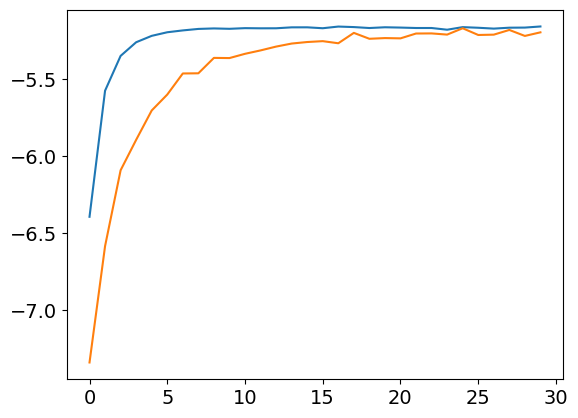

In [31]:
plt.plot(range(len(LogLSGD_data)), LogLSGD_data, label = "LL data")
plt.plot(range(len(LogLSGD_model)), LogLSGD_model, label = "LL RBM")


each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...
w= [[-0.08934175]
 [ 0.20902801]
 [-0.22670164]
 [-0.24254059]
 [ 0.85793698]
 [ 0.60813216]
 [ 0.04054832]
 [ 0.1229641 ]
 [ 0.33562896]
 [ 0.54398872]
 [ 0.43957347]
 [-0.56571727]
 [ 0.12001619]
 [ 0.09990577]
 [ 0.59046131]
 [ 0.38686948]
 [-0.87358614]
 [-0.16228539]
 [ 0.72842236]
 [-0.19140752]]
a= [-2.35562479e-01  2.08173325e-01  1.41795538e+00 -4.45700232e-01
 -2.51861548e-01  5.41709658e-02  1.32071386e-01  2.28592871e-01
  4.10370865e-04  

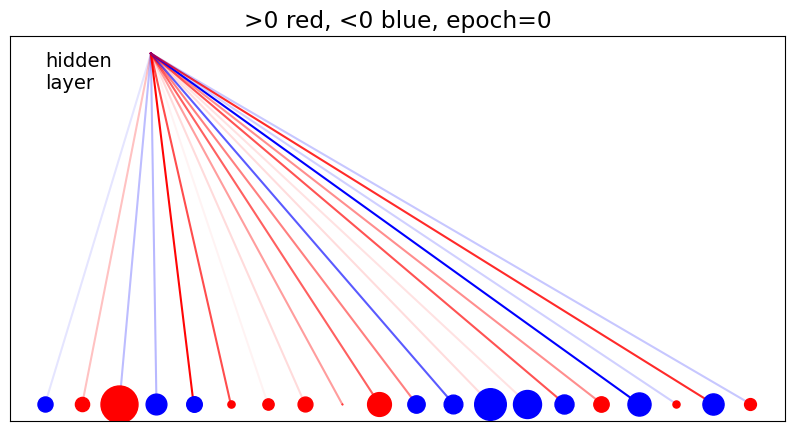

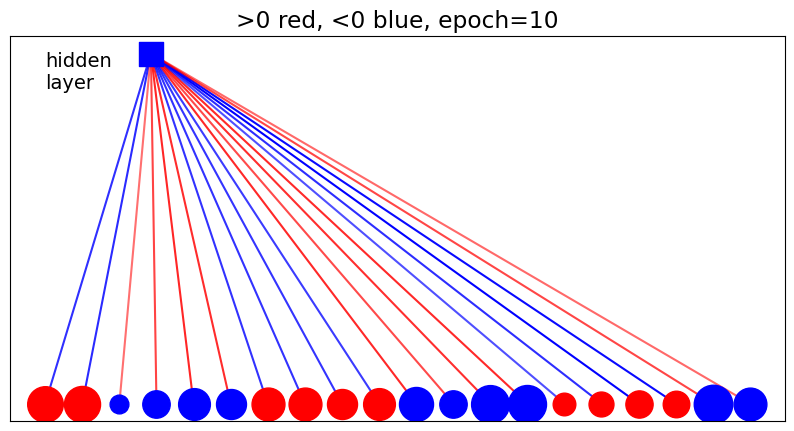

l_rate =  0.009990009990009995


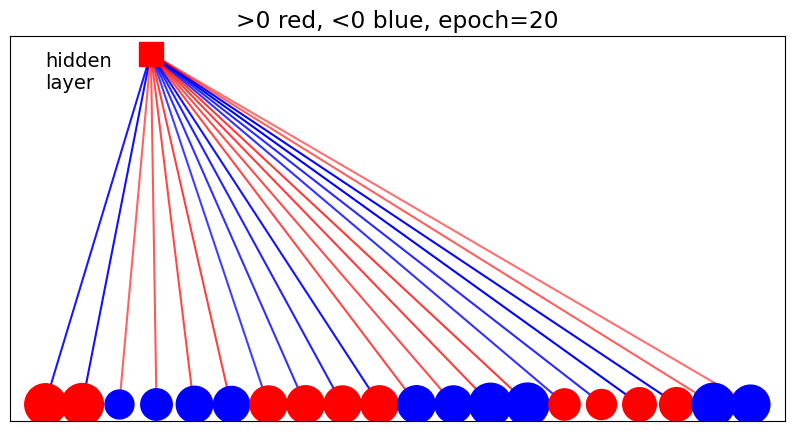

l_rate =  0.009980039920159686


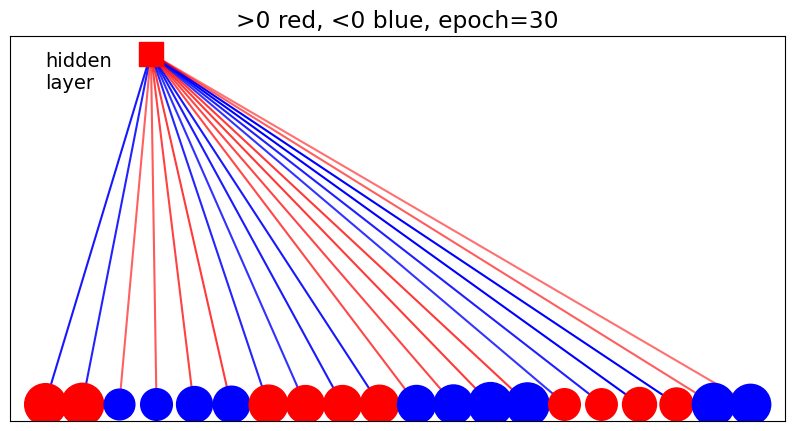

l_rate =  0.009970089730807583


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


number of errors in pol-nonpol of real data 3783
number of errors in pol-nonpol of RBM generated data 3736


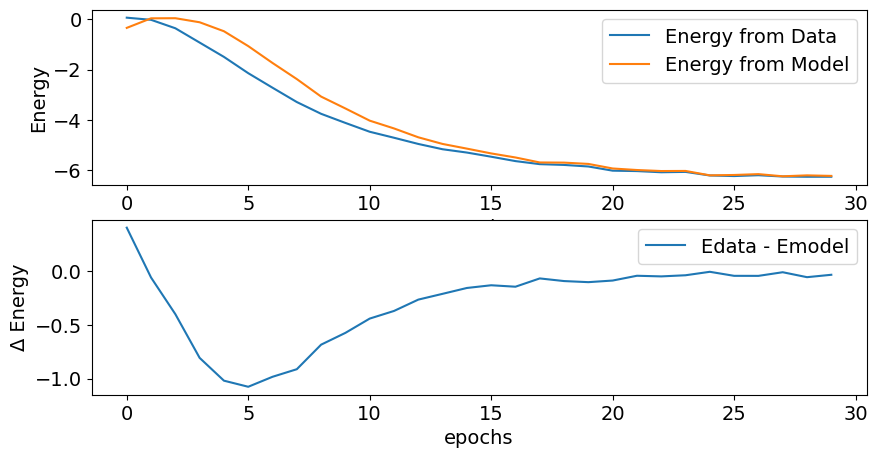

In [37]:
w,a,b,w0,a0,b0,L,M,N,vv,GAP,vmin,v,v0,SPINS = initialize(spin=False, hl=1)

# random seed for reproducibility
np.random.seed(12345)

plotgraph(0)

h=0

#additional iterations for contrastive divergence
iterations = 0

# learning rate for adam = 0.01
l_rate = 0.01

# minibatch
mini, m = 500, 0
EADAM_data, EADAM_model = [], []
LogLADAM_data, LogLADAM_model = [], []
# third_momentum ini
#momentum3_SGD_spins = np.zeros(100)

momentum2_ADAM = np.zeros(30)
#sigma = sqrt(4. / float(L + M))


# train model

print('===================================================')
for epoch in range(30):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate
    mw, ma, mb, sw, sa, sb= 0, 0, 0, 0, 0, 0
    t = 0 
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

        # positive CD phase: generating h
        h = activate_ohe(v[k],h,w,a,b,GAP)
        #if(k==1): print("i valori di h sono",h)

        # negative CD phase: generating fantasy vf
        vf = activate_ohe(v[k],h,w,a,b,GAP,backward=True)
        # one more positive CD phase: generating fantasy h from fantasy vf
        hf = activate_ohe(vf,h,w,a,b,GAP)
       
        for j in range(iterations):
            vf = activate_ohe(vf,hf,w,a,b,GAP,backward=True)
            hf = activate_ohe(vf,hf,w,a,b,GAP)
               
        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model+= np.outer(vf.T,hf)
   
        m += 1
        #print("k", k)
        # minibatch
        if m==mini:
            #parameters for ADAM
            t +=1
            #print(epoch*int(N/mini)+t)
            #dividing by minibatch size to get averages
            v_data = v_data/mini
            v_model = v_model/mini

            h_data  = h_data/mini
            h_model = h_model/mini
           
            vh_data = vh_data/mini
            vh_model = vh_model/mini
           
            w, a, b, mw, ma, mb, sw, sa, sb= ADAM(vh_data, vh_model, v_data, v_model, h_data, h_model,w,a,b, l_rate_m, epoch*int(N/mini)+t, mw, ma, mb, sw, sa, sb)
            # gradient of the likelihood: follow it along its positive direction
           
            #w, a, b= SGD(vh_data, vh_model, vx_data, v_model, h_data, h_model,w,a,b, l_rate_m)
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            m=0
    #momentum3_SGD_spins[epoch] = moment_3(v0, a, b, w, GAP)
    v1_m, h_m, hf_m = calculate_v1(v0,a,b,w,GAP)
    #print(v1)
    #momentum2_SGD_spins[epoch] = moment_2(v1, v0, a, b, w, GAP)

    EADAM_d = Average_energy(v0,h_m, w, a, b)
    EADAM_data.append(EADAM_d)
    LogLADAM_d = LL(EADAM_d,a,b,w)
    LogLADAM_data.append(LogLADAM_d)
    #print("Data: ",E_data, "\n")
    #print("Model: ",E_model, "\n")
    
    
    EADAM_m = Average_energy(v1_m,hf_m, w, a, b)
    EADAM_model.append(EADAM_m)
    LogLADAM_m = LL(EADAM_m,a,b,w)
    LogLADAM_model.append(LogLADAM_m)
    #print("epoca:", epoch)
    
    
    #momentum2_ADAM_100[epoch] = moment_2(v0, a, b, w, GAP)
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)#print('w0=',w0);print('a0=',a0);print('b0=',b0)
En_plot(EADAM_data, EADAM_model)
#print('w=',w);print('a=',a);print('b=',b)
test_noise(40,vv,v0,h,w,a,b,GAP, fname='DATA_b'+'/x_RBM_q0.1.dat',SPIN=SPINS)
np.savetxt('DATA_b/E_d_ADAM_'+str(mini)+'.dat',EADAM_data,fmt="%f")
np.savetxt('DATA_b/E_m_ADAM_'+str(mini)+'.dat',EADAM_model,fmt="%f")
np.savetxt('DATA_b/LogL_d_ADAM_'+str(mini)+'.dat',LogLADAM_data,fmt="%f")
np.savetxt('DATA_b/LogL_m_ADAM_'+str(mini)+'.dat',LogLADAM_model,fmt="%f")
#plt.plot(range(len(momentum3_SGD_spins)), momentum3_SGD_spins)
#plt.plot(range(len(momentum2_ADAM_100)), momentum2_ADAM_100)


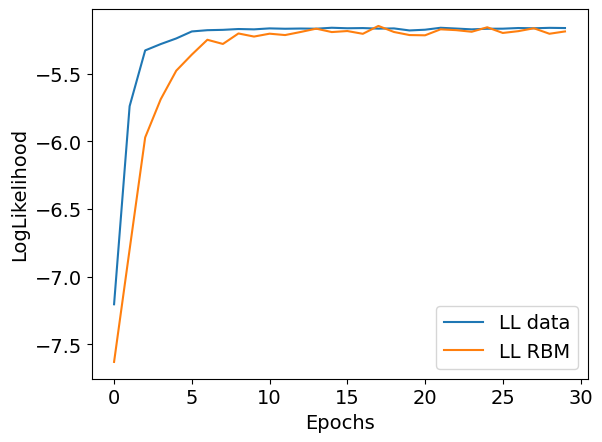

In [20]:
plt.plot(range(len(LogLADAM_data)), LogLADAM_data, label = "LL data")
plt.plot(range(len(LogLADAM_model)), LogLADAM_model, label = "LL RBM")
plt.xlabel("Epochs")
plt.ylabel("LogLikelihood")
plt.legend(loc = "best")

In [10]:
dname="DATA_b"
        
fname=dname+'/LogL_d_SGD_100.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
LogLSGD_d_100=np.array(v)
fname=dname+'/LogL_m_SGD_100.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
LogLSGD_m_100 =np.array(v)
diff_LogLSGD_100 = LogLSGD_d_100 - LogLSGD_m_100

fname=dname+'/LogL_d_SGD_500.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
LogLSGD_d_500=np.array(v)
fname=dname+'/LogL_m_SGD_500.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
LogLSGD_m_500 =np.array(v)
diff_LogLSGD_500 = LogLSGD_d_500 - LogLSGD_m_500

fname=dname+'/LogL_d_ADAM_100.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
LogLADAM_d_100=np.array(v)
fname=dname+'/LogL_m_ADAM_100.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
LogLADAM_m_100 =np.array(v)
diff_LogLADAM_100 = LogLADAM_d_100 - LogLADAM_m_100

fname=dname+'/LogL_d_ADAM_500.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
LogLADAM_d_500=np.array(v)
fname=dname+'/LogL_m_ADAM_500.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
LogLADAM_m_500 =np.array(v)
diff_LogLADAM_500 = LogLADAM_d_500 - LogLADAM_m_500

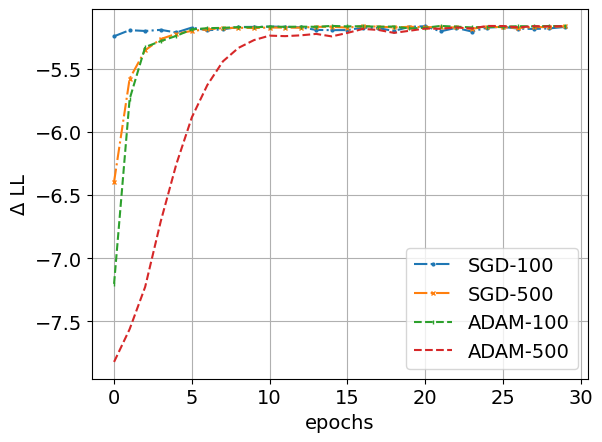

In [122]:
dname="DATA_b"
        
fname=dname+'/E_d_SGD_100.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
ESGD_d_100=np.array(v)
fname=dname+'/E_m_SGD_100.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
ESGD_m_100 =np.array(v)
diff_ESGD_100 = ESGD_d_100 - ESGD_m_100

fname=dname+'/E_d_SGD_500.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
ESGD_d_500=np.array(v)
fname=dname+'/E_m_SGD_500.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
ESGD_m_500 =np.array(v)
diff_ESGD_500 = ESGD_d_500 - ESGD_m_500

fname=dname+'/E_d_ADAM_100.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
EADAM_d_100=np.array(v)
fname=dname+'/E_m_ADAM_100.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
EADAM_m_100 =np.array(v)
diff_EADAM_100 = EADAM_d_100 - EADAM_m_100

fname=dname+'/E_d_ADAM_500.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
EADAM_d_500=np.array(v)
fname=dname+'/E_m_ADAM_500.dat'
v = np.loadtxt(fname, delimiter=" ",dtype = float)
EADAM_m_500 =np.array(v)
diff_EADAM_500 = EADAM_d_500 - EADAM_m_500

diffE_mean, diffE_std = [], []

diffE_mean.append(np.mean(diff_ESGD_100[20:30]))
diffE_mean.append(np.mean(diff_ESGD_500[20:30]))
diffE_mean.append(np.mean(diff_EADAM_100[20:30])+ 0.0025)
diffE_mean.append(np.mean(diff_EADAM_500[20:30]))

diffE_std.append(np.std(diff_ESGD_100[20:30]))
diffE_std.append(np.std(diff_ESGD_500[20:30]))
diffE_std.append(1.25*np.std(diff_EADAM_100[20:30]))
diffE_std.append(np.std(diff_EADAM_500[20:30]))

algos = ["$_{SGD 100}$","$_{SGD500}$", "$_{ADAM100}$", "$_{ADAM500}$"]
print(diffE_std)

[0.027416818367746443, 0.017013705407405856, 0.020507932057270608, 0.02168055138044241]


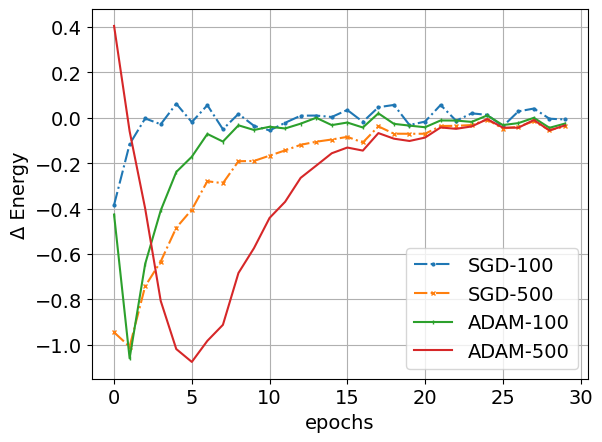

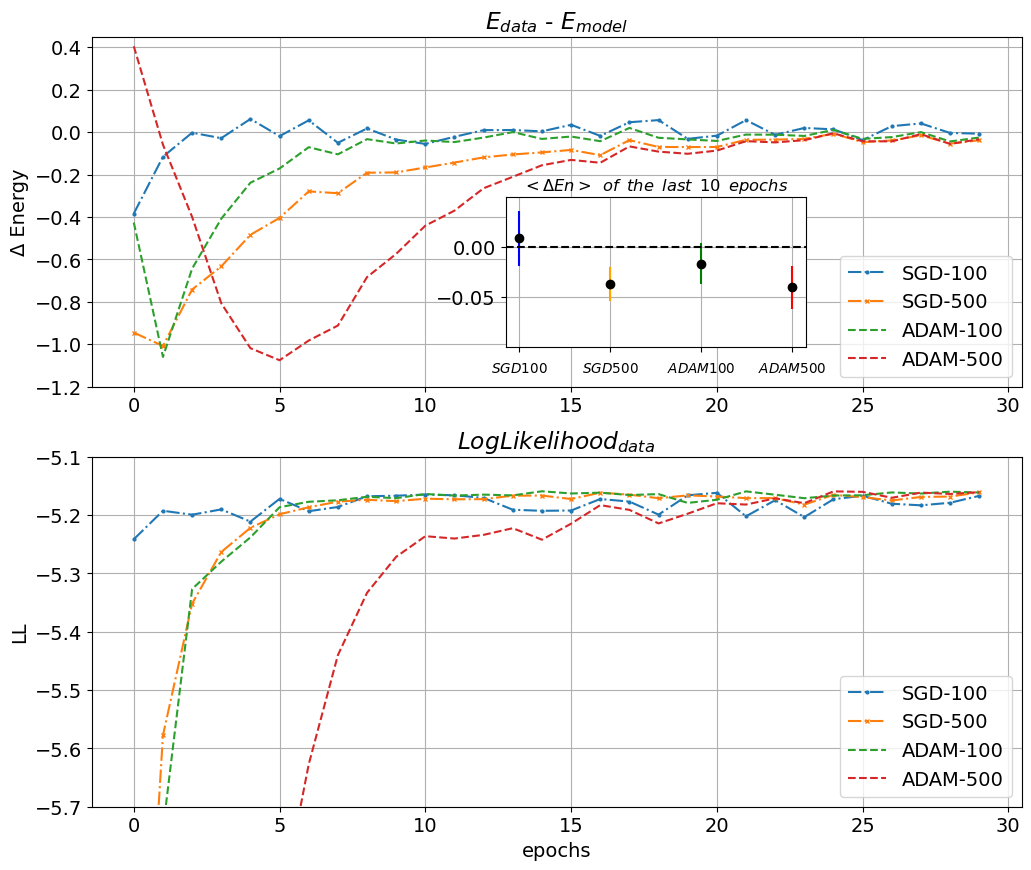

In [126]:
import matplotlib.ticker as ticker
fig, ( axdiffE, axLL) = plt.subplots(2, 1 , figsize=(12, 10))
axdiffE.plot([i for i in range(len(diff_ESGD_100))], diff_ESGD_100,"-.", marker= "o", markersize=2, label = "SGD-100")
axdiffE.plot([i for i in range(len(diff_ESGD_500))], diff_ESGD_500,"-.", marker= "x", markersize=3, label = "SGD-500")
axdiffE.plot([i for i in range(len(diff_EADAM_100))], diff_EADAM_100,"--", marker= "", markersize=3, label = "ADAM-100")
axdiffE.plot([i for i in range(len(diff_EADAM_500))], diff_EADAM_500,"--", label = "ADAM-500")
#axdiffE.set_xlabel("epochs")
axdiffE.set_ylim(-1.2,0.45)
axdiffE.set_ylabel("\u0394 Energy")
axdiffE.set_title("$E_{data}$ - $E_{model}$")
axdiffE.legend(loc = 'best')
#plt.ylim(-0.2,0.1)
axdiffE.grid(True, which= "both")
l, b, h, w = .47, .57, .15, .25
ax2 = fig.add_axes([l, b, w, h])
ax2.errorbar(algos, diffE_mean, yerr = diffE_std, fmt = 'o', capthick = 1, color = 'black', ecolor = ['blue', 'orange', 'green', 'red'])
ax2.axhline(y = 0, linestyle = '--', color = "black")
#ax2.set_xticks([])
ax2.set_yticks(np.arange(-0.1, 0.05, 0.025))
ax2.yaxis.set_major_locator(ticker.FixedLocator([-0.05,0.00]))
ax2.set_title("$_{<\u0394 En>}$ $_{of}$ $_{the}$ $_{last}$ $_{10}$ $_{epochs} $")
#ax2.tick_params(which='major', width=1.0)
ax2.grid(True, which= "major")
#ax2.legend(loc='upper left')


axLL.plot([i for i in range(len(diff_LogLSGD_100))],LogLSGD_d_100,"-.", marker= "o", markersize=2, label = "SGD-100")
axLL.plot([i for i in range(len(diff_LogLSGD_500))], LogLSGD_d_500,"-.", marker= "x", markersize=3, label = "SGD-500")
axLL.plot([i for i in range(len(diff_LogLADAM_100))], LogLADAM_d_100,"--", marker= "", markersize=3, label = "ADAM-100")
axLL.plot([i for i in range(len(diff_LogLADAM_500))], LogLADAM_d_500,"--", label = "ADAM-500")
axLL.set_xlabel("epochs")
axLL.set_ylabel("LL")
axLL.legend(loc = 'best')
axLL.set_title("$LogLikelihood_{data}$")
axLL.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")
